# Nettoyage des données
Created by: Thomas Durand-Texte, Jan. 2023
***

# Imports
## Import des packages

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option("display.max_columns", 200)
import missingno as msno

import datetime as dt
import scipy.stats as st


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


import tools
cm = 1./2.54


## Reload module (for updates)

In [3]:
import importlib
cm = 1./2.54
importlib.reload(tools)
tools.set_theme( white_font=True )
# tools.plot_test_figure()

## Chargement des données

In [4]:
data = pd.read_pickle( 'data_clean.pkl' )

***
# Stastistique

## pnns_groups / food_grade

keys: ['nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2']


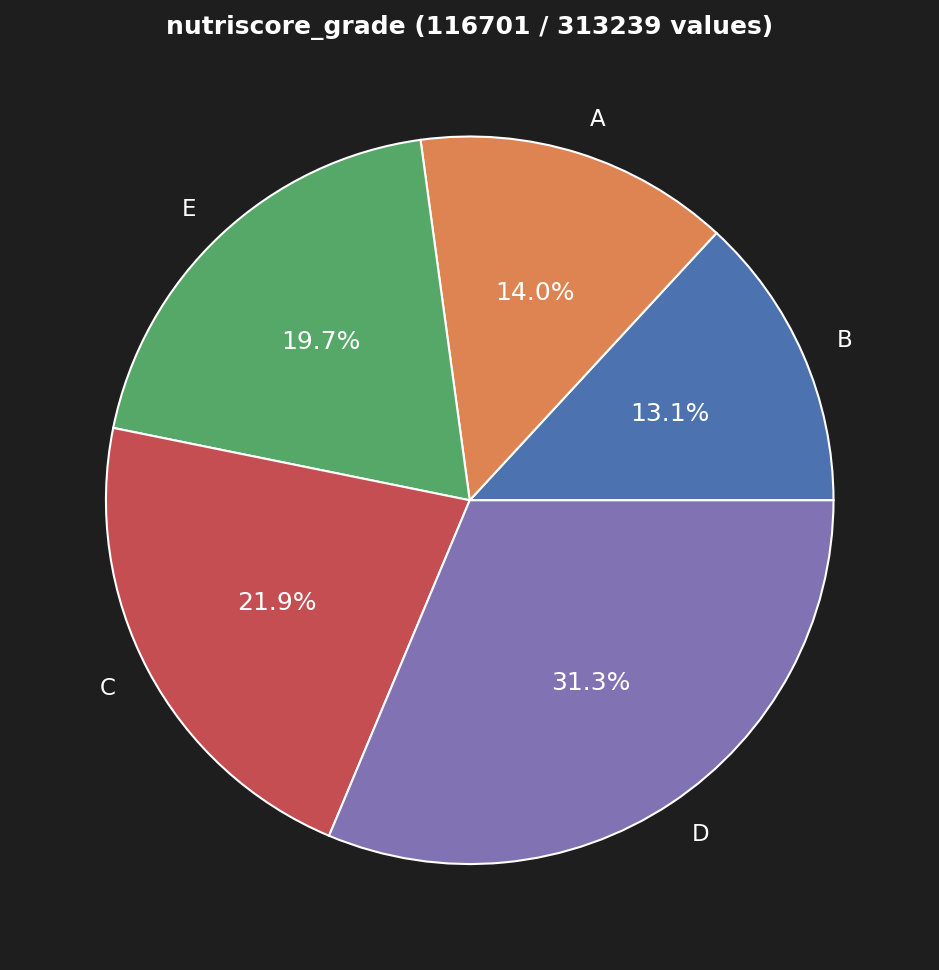

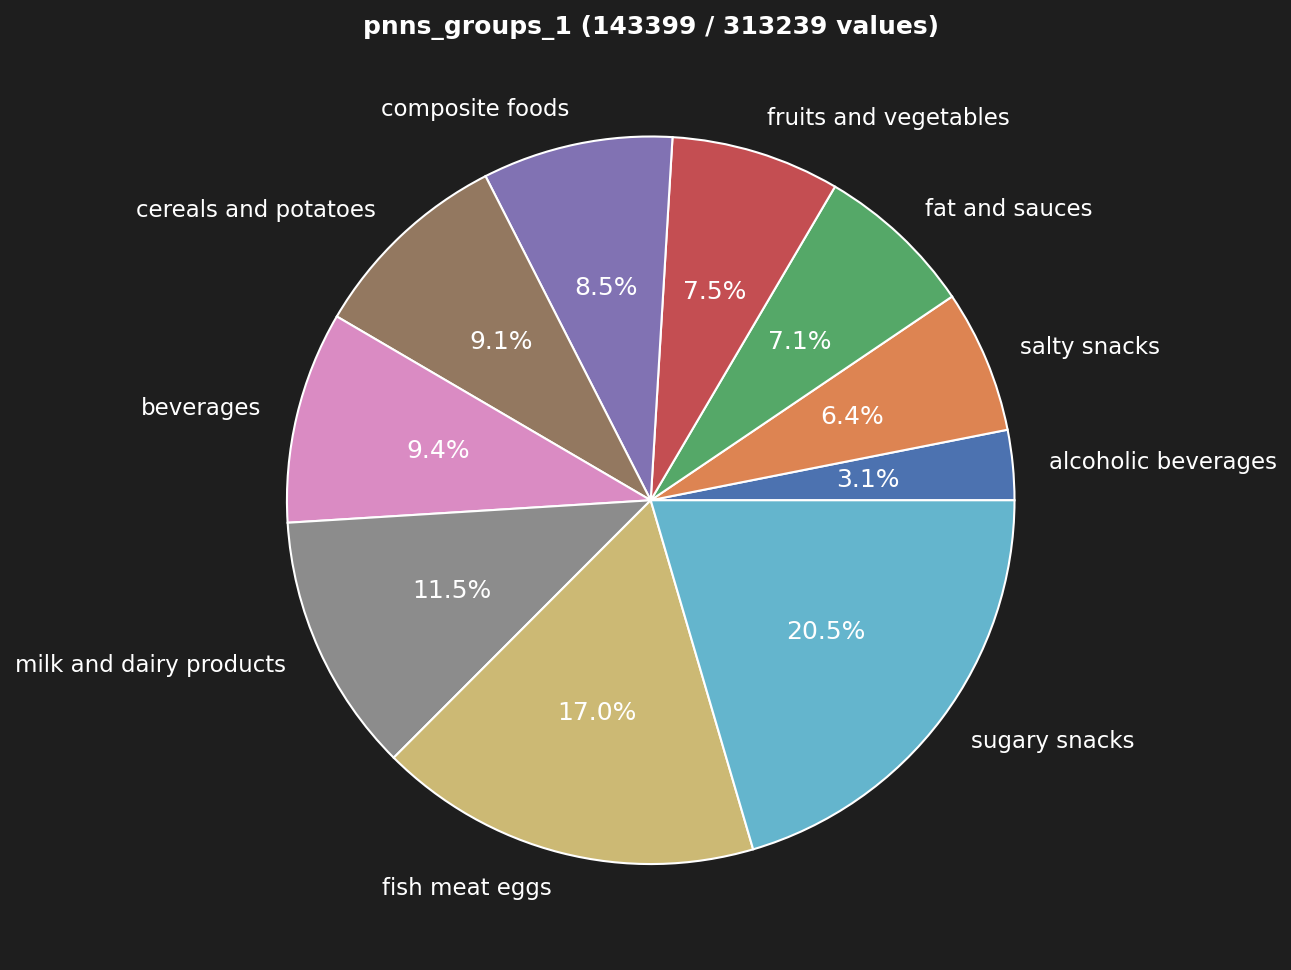

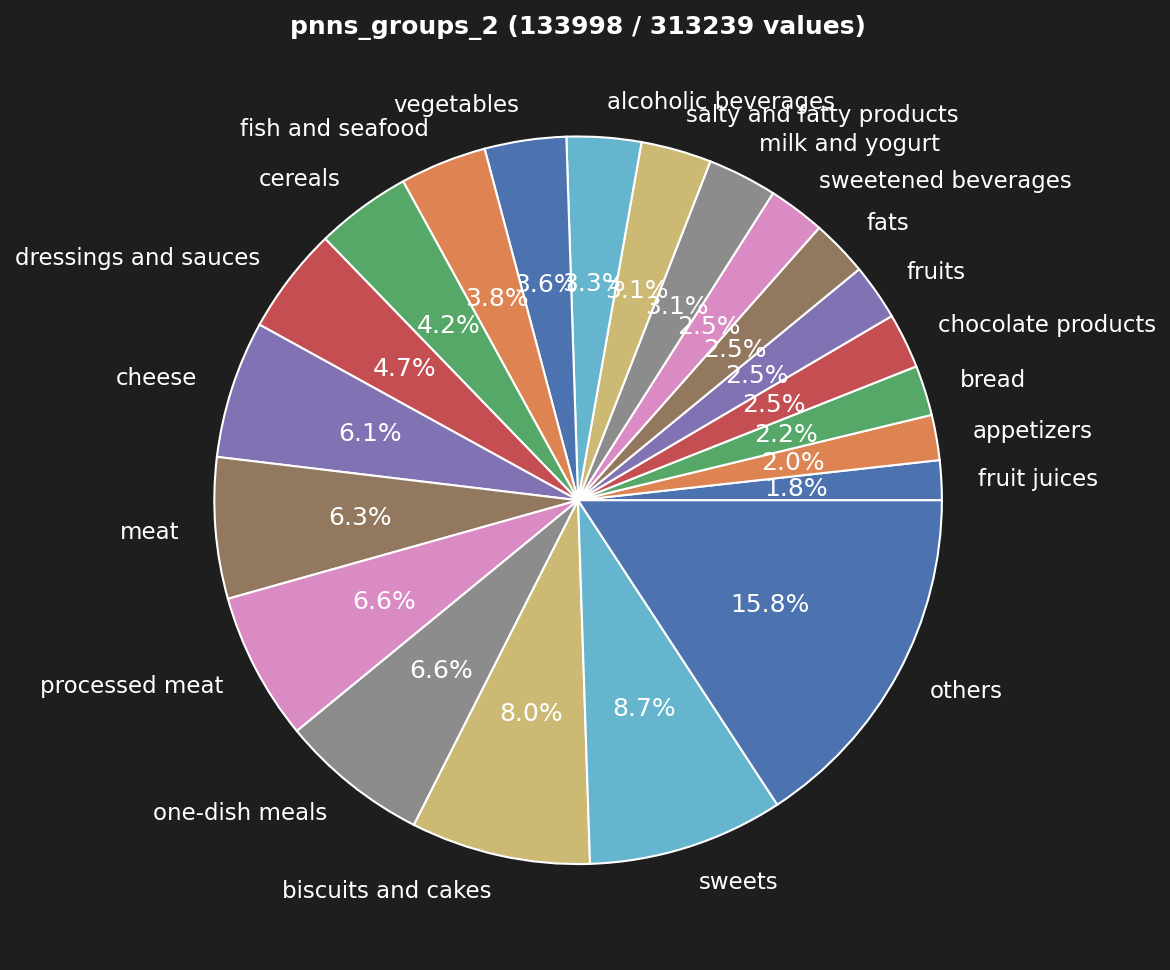

In [5]:
keys = data.keys()[data.keys().str.contains('pnns|nutriscore_grade')] #|main_categ|food_grou')]
print('keys:', keys.tolist())


n_lim_categories = 20
for key in keys:
    sr_plot = data[key].value_counts()
    n_sum = sr_plot.sum()

    if sr_plot.size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, len(data)), weight='bold')
    ax.set_ylabel('')

***
## Display NaN
### bar plot

<AxesSubplot: >

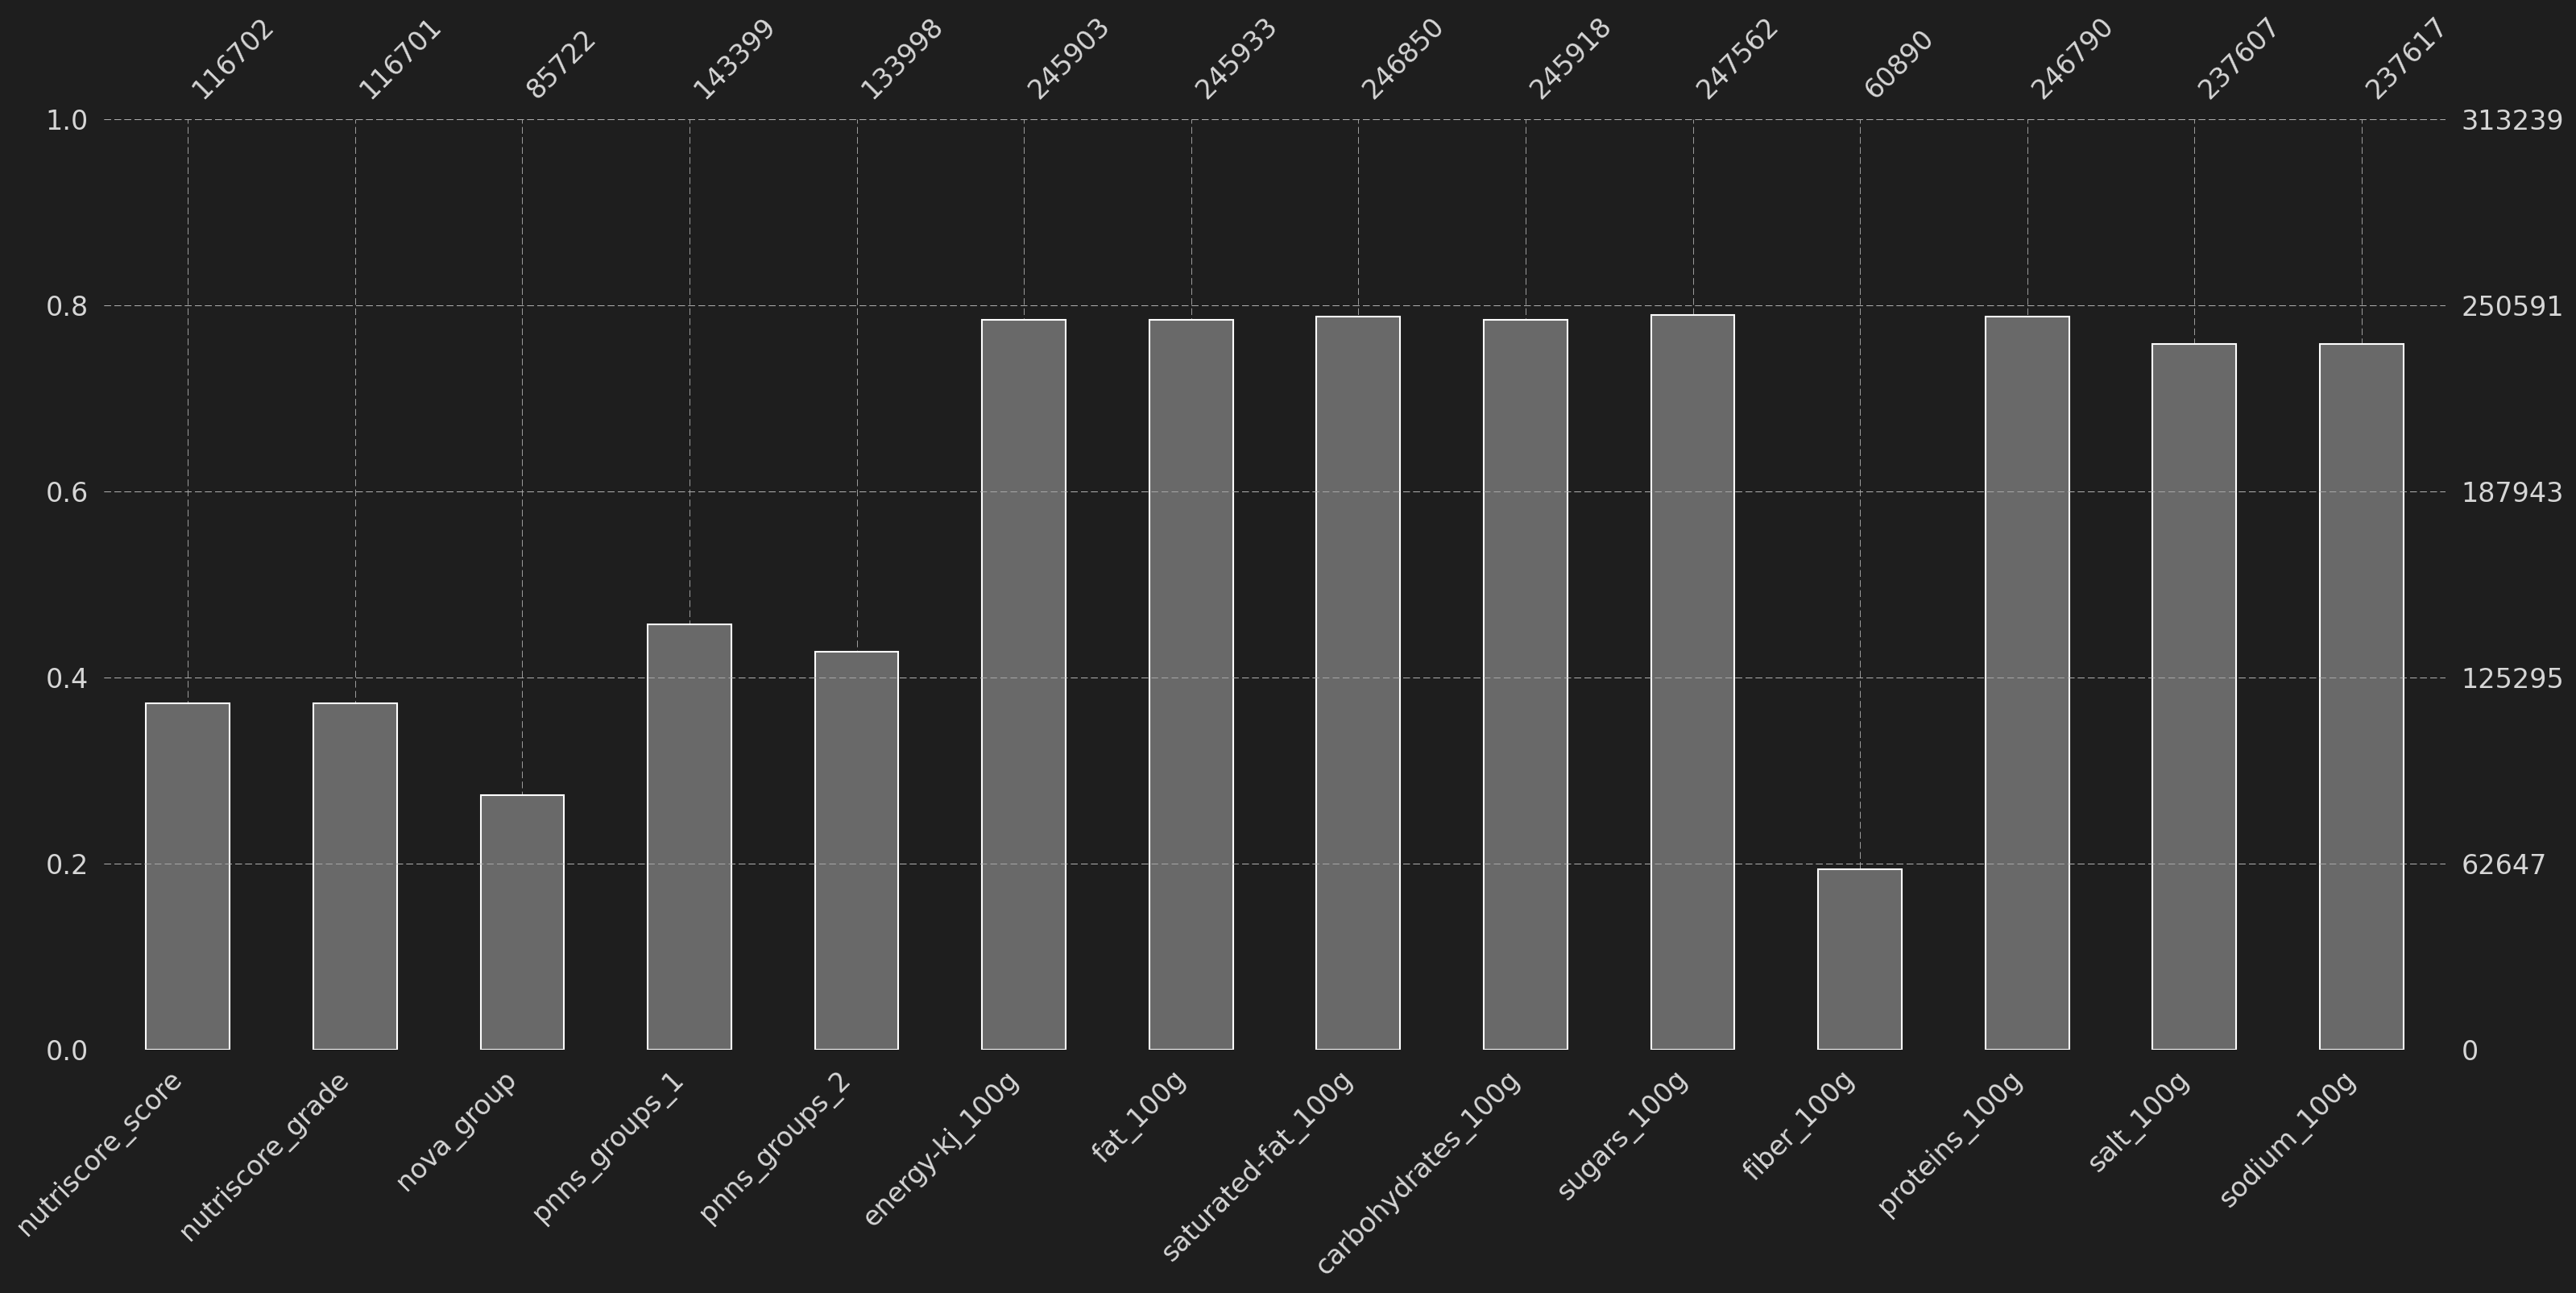

In [6]:
lst_to_hide = [ 'code',
                'name','quantity', 'labels', 'ingredie', 'allerg',
                'addit', 'ecoscore']
# lst_to_hide = ['code']
keys_used_0 = data.keys()[ ~data.keys().str.contains('|'.join(lst_to_hide)) ]
msno.bar( data[ keys_used_0 ] )

### choix des variables numériques
Les données sur les fibres sont relativement peu nombreuses, donc elles sont enlevées.

In [7]:
keys_100g = pd.Series( keys_used_0[ keys_used_0.str.contains('_100g') 
                        & ~keys_used_0.str.contains('fiber') ] )
print( 'keys 100g:', keys_100g.tolist() )

keys 100g: ['energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


### Matrix plot

<AxesSubplot: >

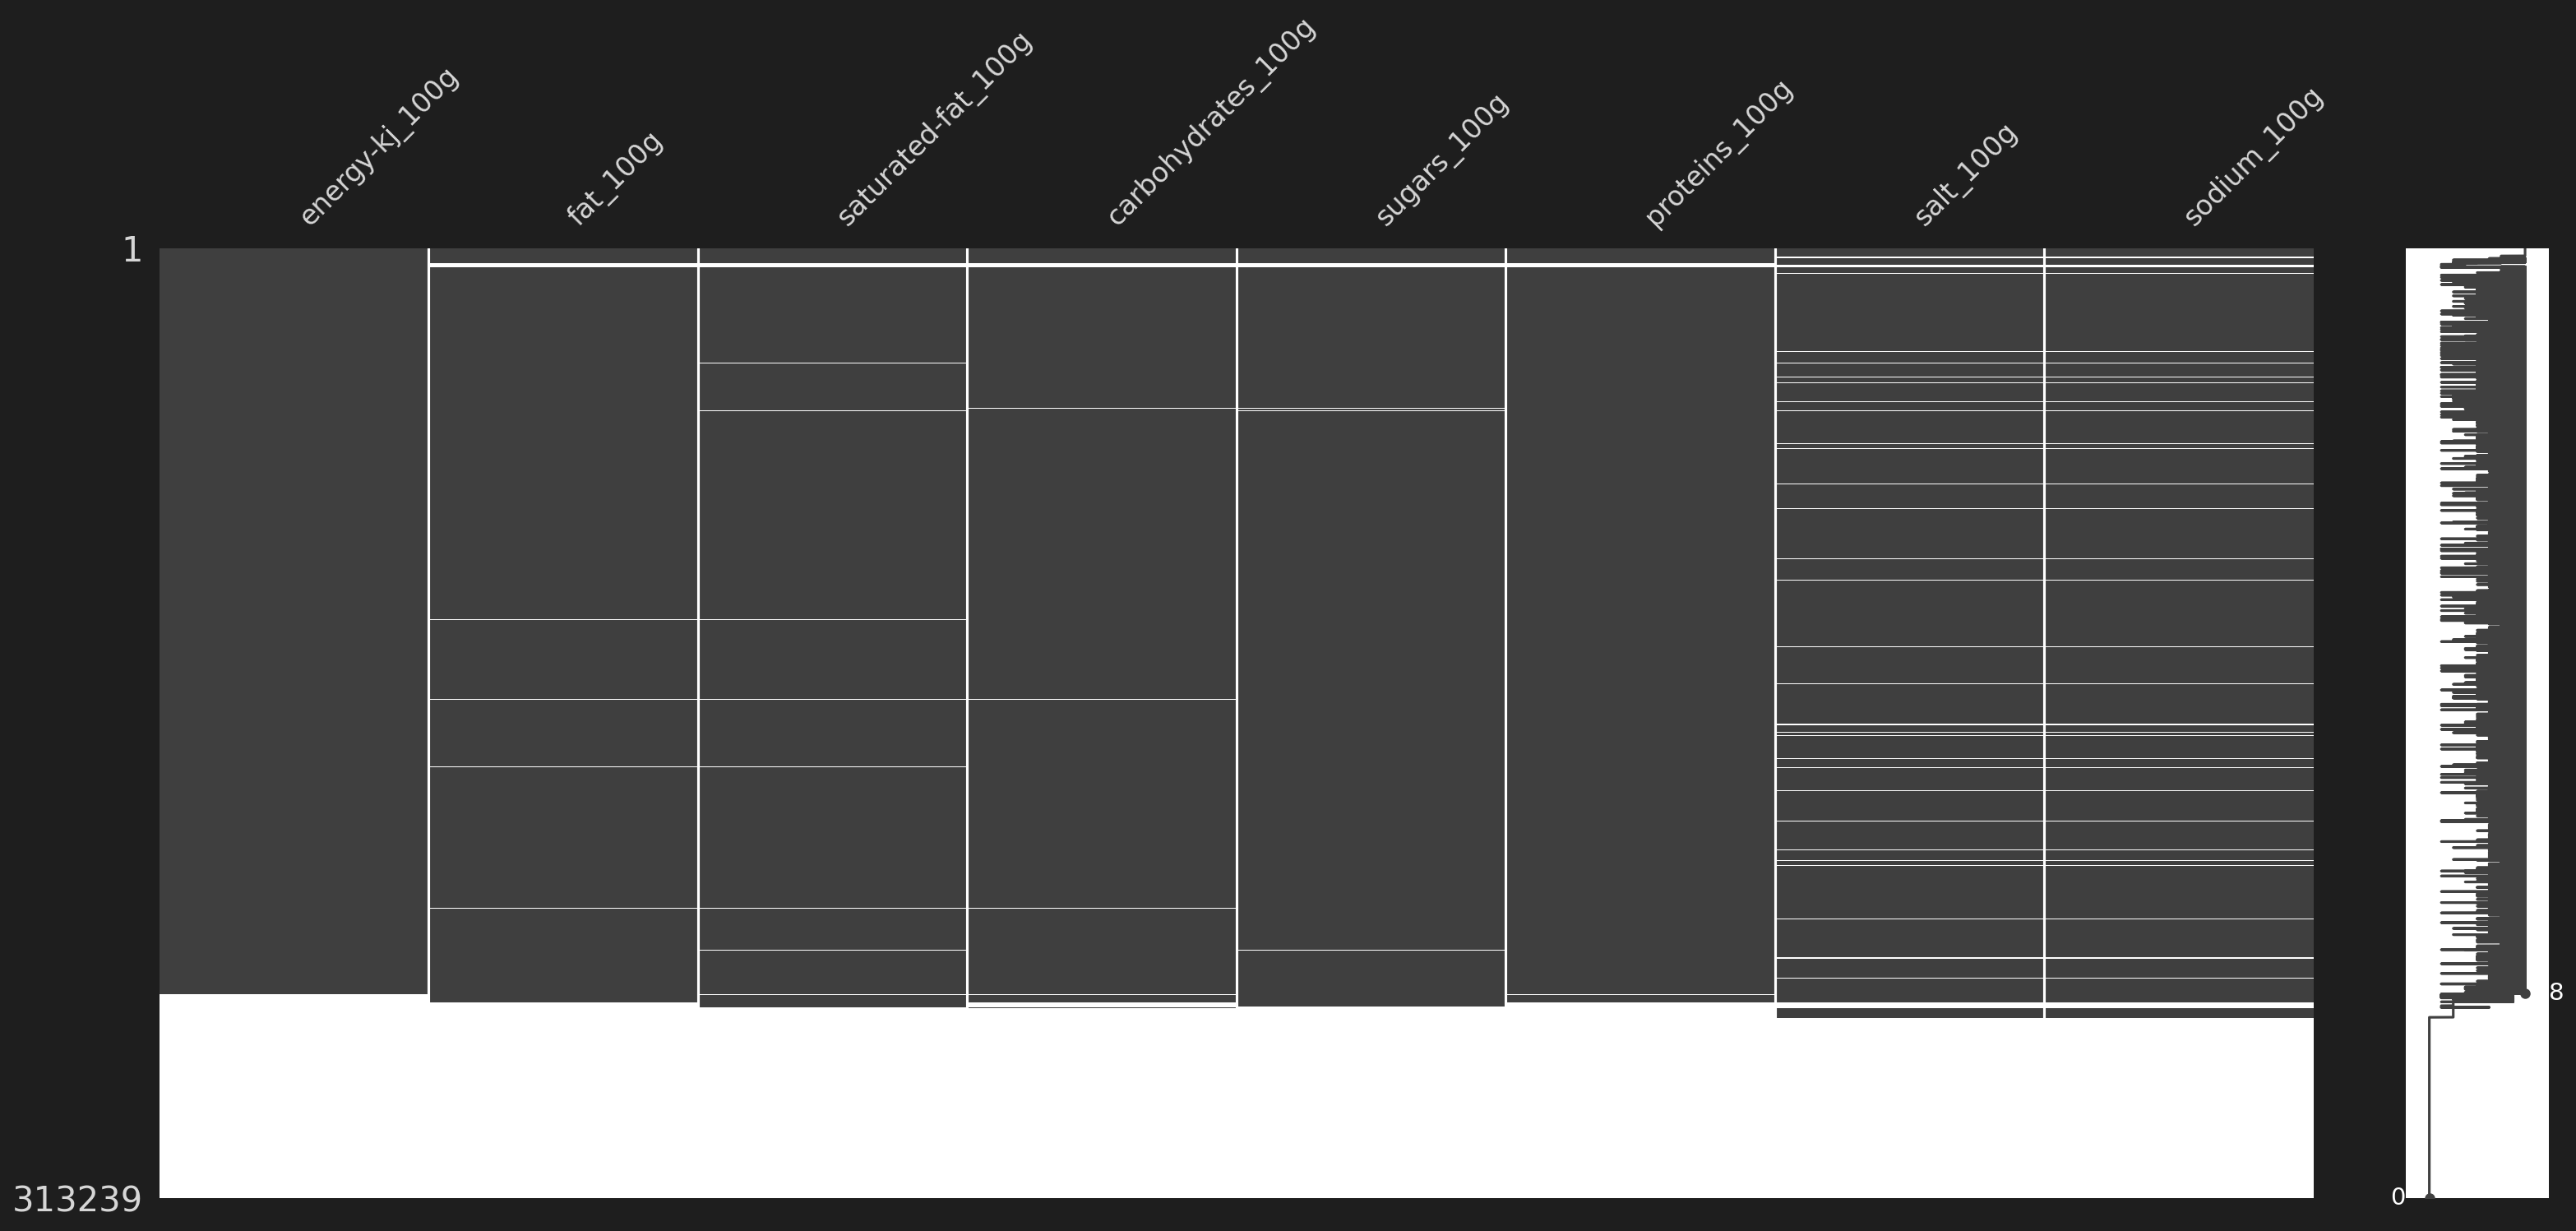

In [8]:
msno.matrix( data[keys_100g].sort_values( by=keys_100g.tolist()) )

Quelques NaN éparses sont visibles, mais pour la majeur partie des NaN sont sur toute la ligne.
Le plus sain est donc d'enlever les lignes pour lequelles toutes les valeurs sont NaN.

<AxesSubplot: >

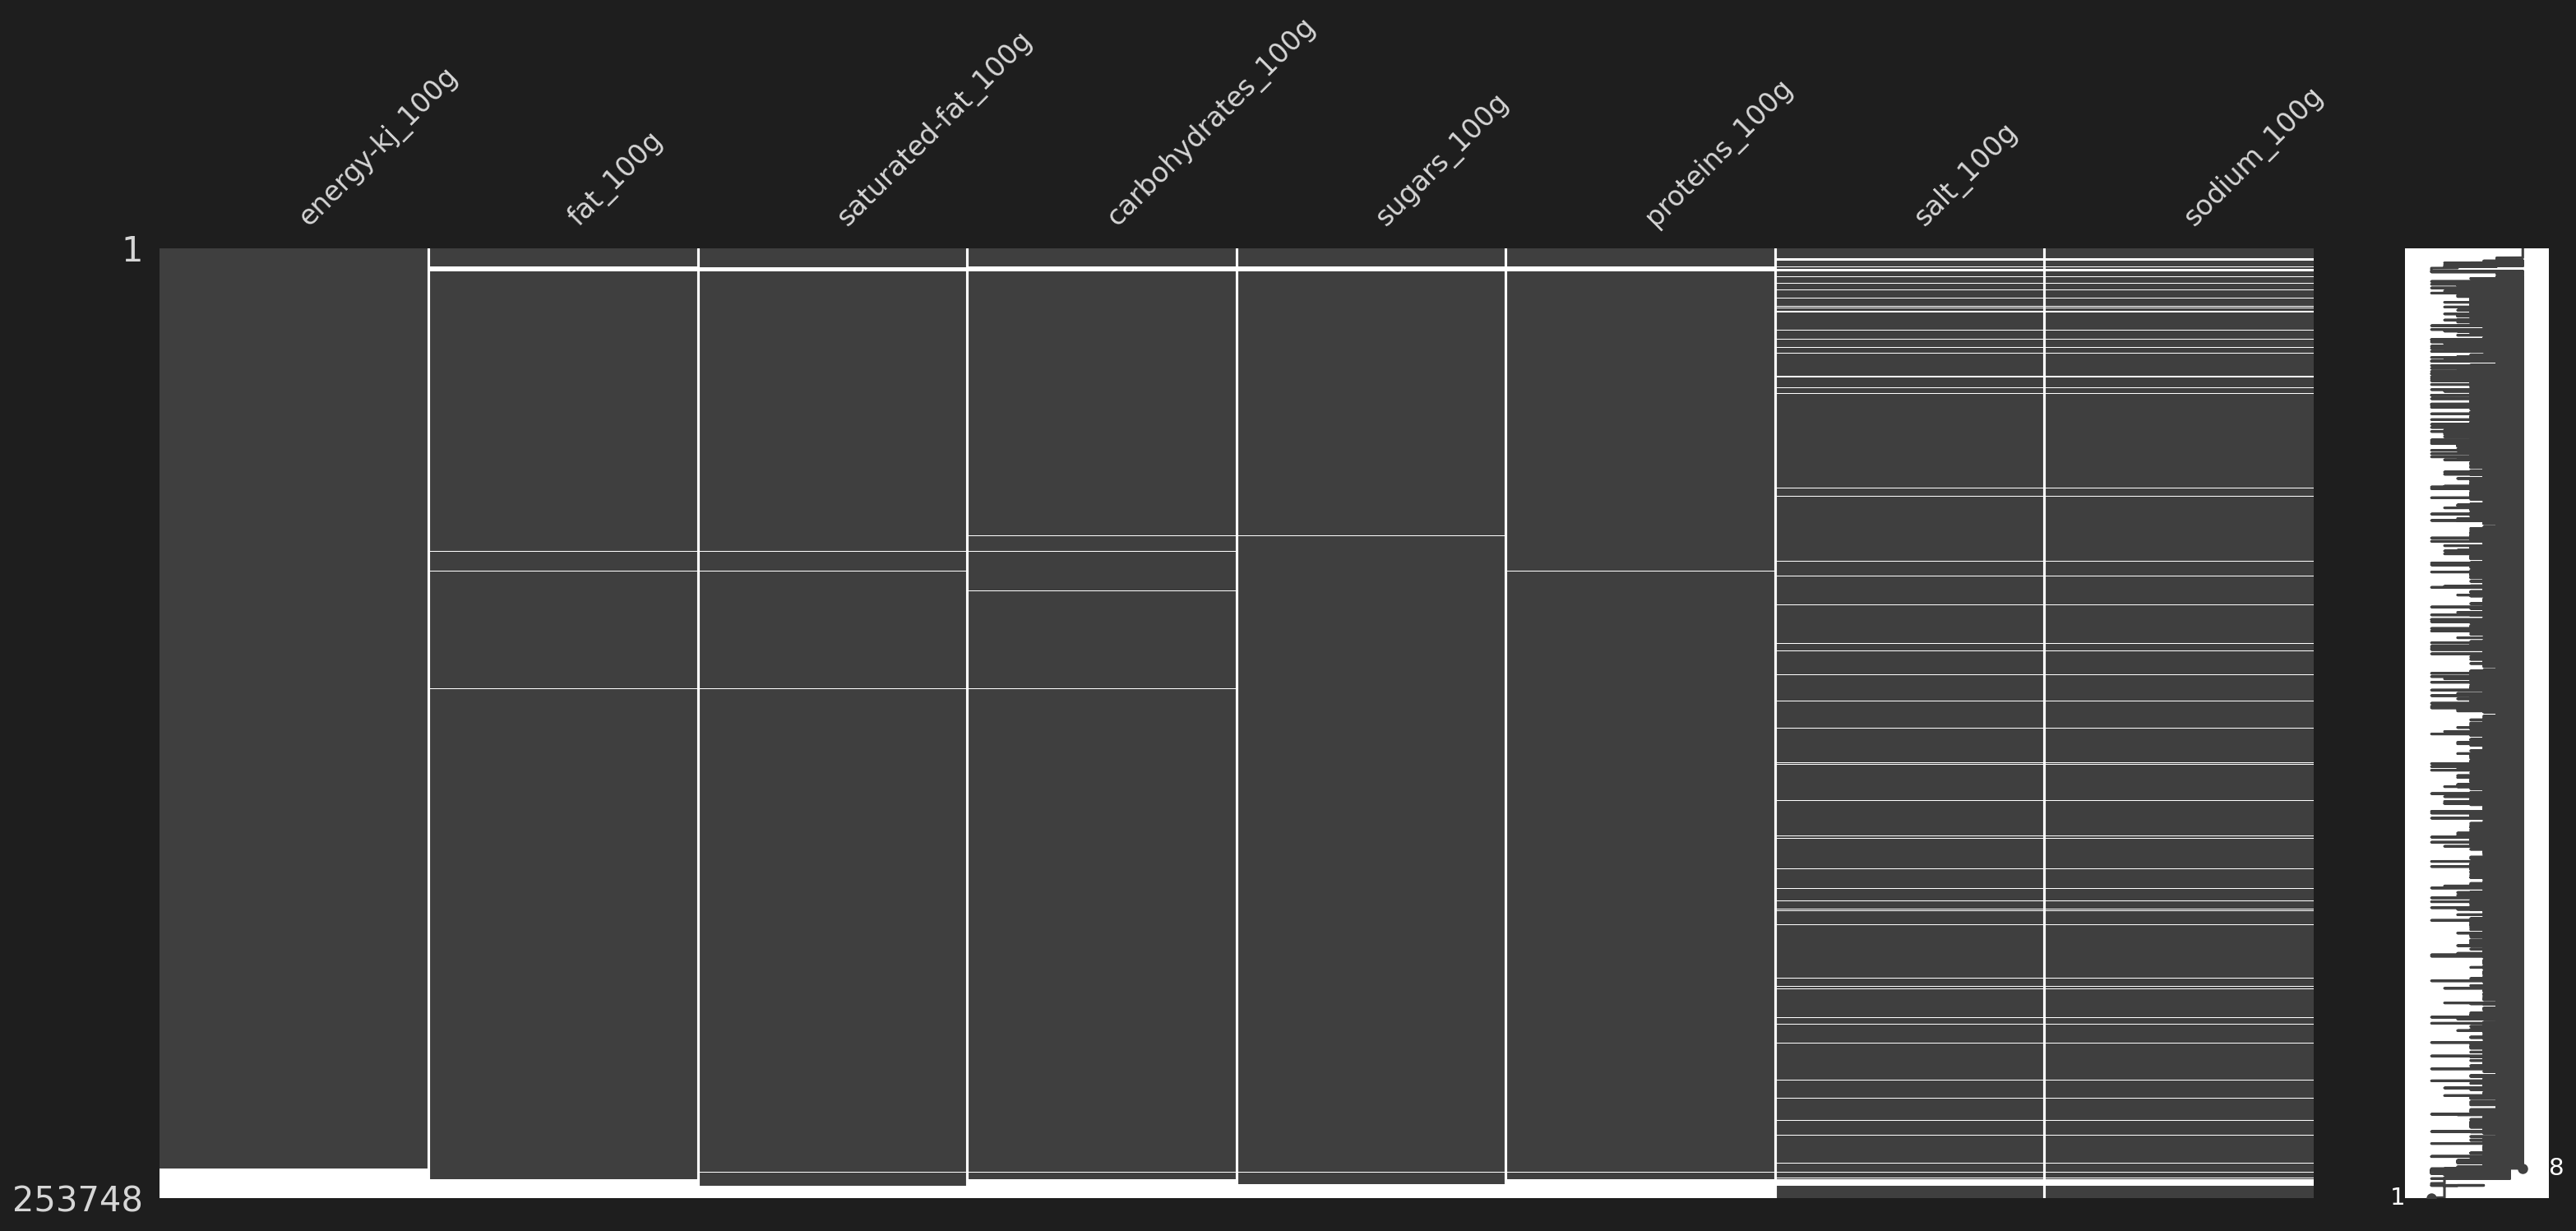

In [9]:
sr_is_ful_na = data[keys_100g].isna().sum(1) == len(keys_100g)
data.drop( index = sr_is_ful_na[sr_is_ful_na].index , inplace=True )
msno.matrix( data[keys_100g].sort_values( by=keys_100g.tolist()) )

Il reste quelques lignes avec trop peu de valeurs, qui sont donc préférables d'enlever

<AxesSubplot: >

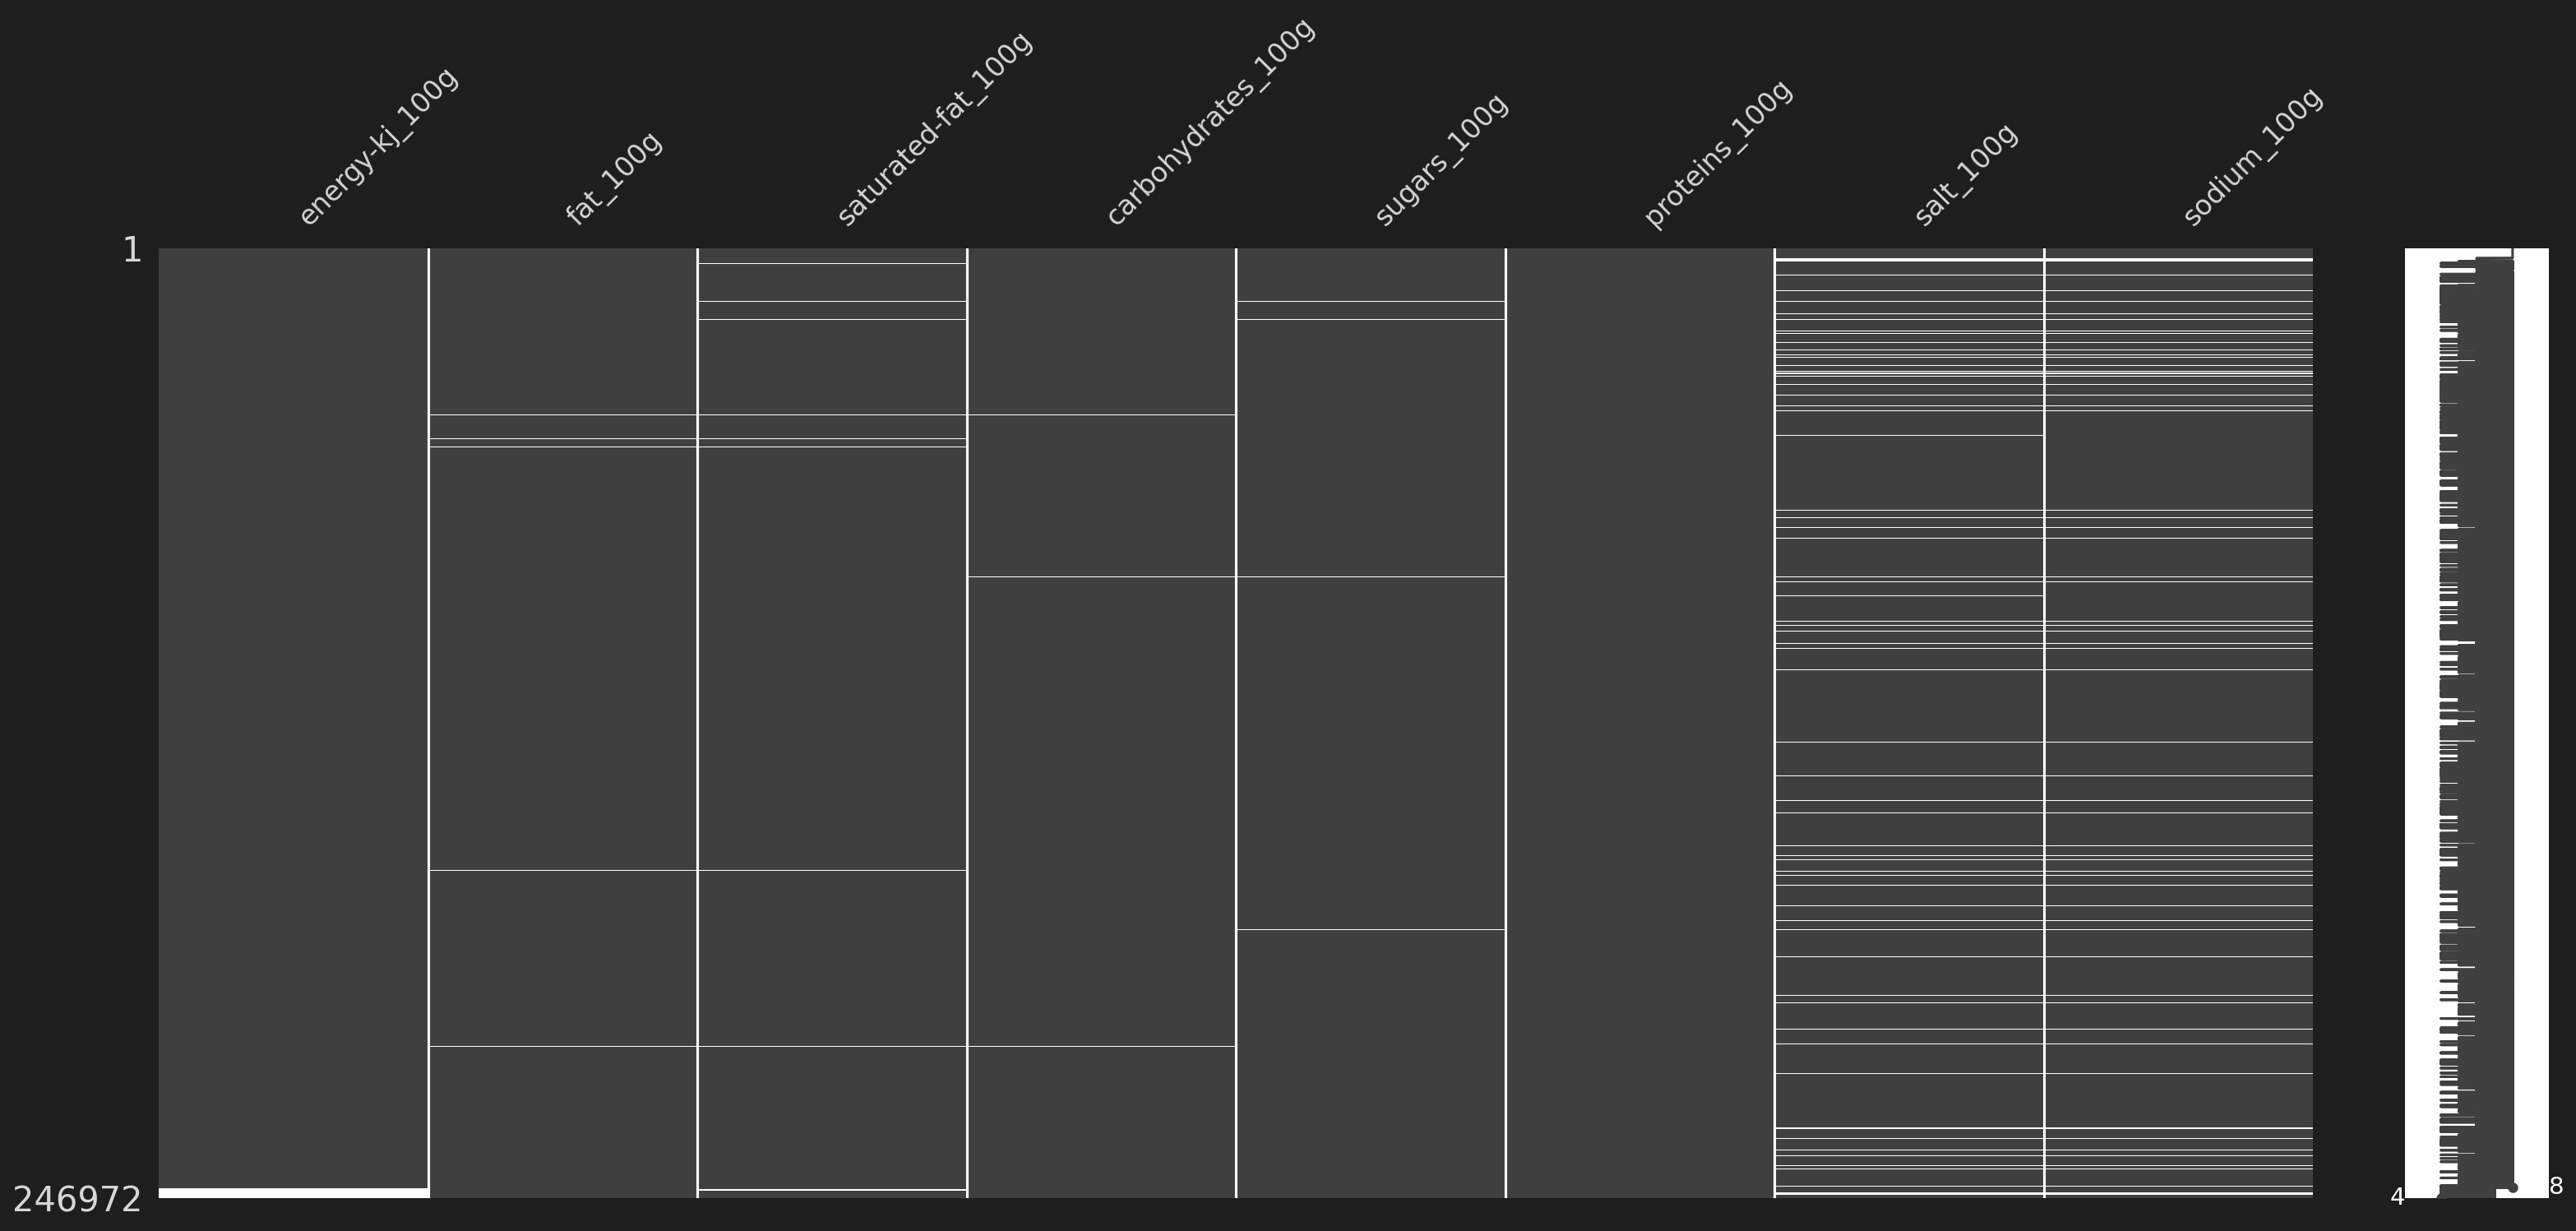

In [10]:
sr_loc = data[keys_100g].isna().sum(1) > (len(keys_100g) - 4 )

data_2 = data.drop( index=sr_loc[sr_loc].index )
msno.matrix( data_2[keys_100g].sort_values( by=keys_100g.tolist()) )

## Uniquement valeurs == 0

In [11]:
sr_loc = data[keys_100g].max(1)==0
print('n max(row) == 0 :', sr_loc.sum() )
data.drop( index= sr_loc[sr_loc].index, inplace=True )

n max(row) == 0 : 8932


## Analyse proteins + carbohydrates + fat

In [12]:
# help( data.boxplot )
help( plt.boxplot )

Help on function boxplot in module matplotlib.pyplot:

boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, capwidths=None, *, data=None)
    Draw a box and whisker plot.
    
    The box extends from the first quartile (Q1) to the third
    quartile (Q3) of the data, with a line at the median.  The
    whiskers extend from the box by 1.5x the inter-quartile range
    (IQR).  Flier points are those past the end of the whiskers.
    See https://en.wikipedia.org/wiki/Box_plot for reference.
    
    .. code-block:: none
    
              Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                           |-----:-----|
           o      |--------|    

count    244816.000000
mean         50.385033
std          31.033769
min           0.000000
25%          23.300000
50%          46.900000
75%          82.600000
max         382.000000
Name: Prot+carbo+fat, dtype: float64

Q3+1.5*IQ: 171.550, n_outliers : 7
n > 100 : 727


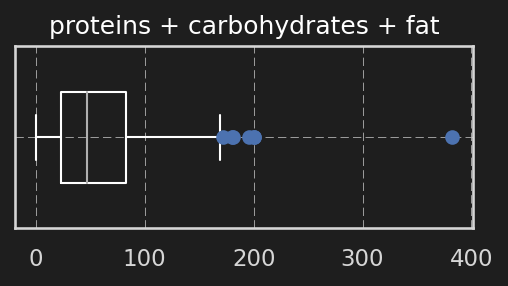

In [13]:
key = 'Prot+carbo+fat'
data[key] = data[['proteins_100g', 'fat_100g', 'carbohydrates_100g']].fillna(0.).sum(1)
df = data[key].describe()
display(df)
Q3, IQ = df['75%'], df['75%']-df['25%']
sr_out = data[key] > Q3 + 1.5*IQ
print('Q3+1.5*IQ: {:.3f}, n_outliers :'.format(Q3+1.5*IQ), sr_out.sum() )

sr_out = data[key] > 100.
print('n > 100 :', sr_out.sum() )

fig, ax = plt.subplots( figsize=(10*cm,4*cm))
data.boxplot( column=key, vert=False, ax=ax, sym='bo', 
            boxprops={'color':'w'}, whiskerprops={'color':'w'},
            capprops={'color':'w'}, widths=0.5 )
# print('label', ax.get_yticklabels()[0].get_text())
ax.set_title( 'proteins + carbohydrates + fat' )
ax.set_yticklabels( [] )

if False:
    data = data.drop( index=sr_out[sr_out].index, inplace=True )

    fig, ax = plt.subplots()
    data.boxplot( column=key, vert=False, ax=ax )


## Remplissage avec la valeur moyenne par pnns_groups_1
Clairement, les distributions ne sont `pas Gaussiennes` dans chaque catégorie: plusieurs `modes` sont visibles. `Remplacer` les `NaN` avec la `valeur moyenne` dans chaque catégorie `modifie` la `forme` des `distributions`.

<span style="color:red"> Problème d'affichages due au violin sur alcoholic beverages </span>

<span style="color:red"> Faire un équivalent violin avec histogrammes ? + 2 moustaches ? </span>

In [14]:
if False:
    # plot histogram chart for var2
    n_bins = 20
    # get positions and heights of bars
    heights, bins = np.histogram(df.var2, density=True, bins=n_bins) 
    # multiply by -1 to reverse it
    heights *= -1
    bin_width = np.diff(bins)[0]
    bin_pos =( bins[:-1] + bin_width / 2) * -1

    # plot
    plt.bar(bin_pos, heights, width=bin_width, edgecolor='black')

In [15]:
sr_loc = data['pnns_groups_1'] == 'alcoholic beverages'
alcohol_isna = data.loc[ sr_loc, 'fat_100g' ].isna()
print('{:} (over {:}) data on alcoholic beverages are NaN'.format( alcohol_isna.sum() , len(alcohol_isna) ) )

54 (over 421) data on alcoholic beverages are NaN


Number of added values:


energy-kj_100g        1775
fat_100g               882
saturated-fat_100g    1591
carbohydrates_100g     888
sugars_100g            882
proteins_100g          517
salt_100g             3313
sodium_100g           3309
dtype: int64

12
mean energy-kj_100g: 1144.209
126886   NaN
132310   NaN
149655   NaN
177306   NaN
188269   NaN
202215   NaN
204807   NaN
228478   NaN
246624   NaN
247715   NaN
265246   NaN
312572   NaN
Name: energy-kj_100g, dtype: float64
126886    302.888753
132310    302.888753
149655    302.888753
177306    302.888753
188269    302.888753
202215    302.888753
204807    302.888753
228478    302.888753
246624    302.888753
247715    302.888753
265246    302.888753
312572    302.888753
Name: energy-kj_100g, dtype: float64

data energy-kj_100g (alcoholic beverages) mean: 302.889, modified: 302.889

data energy-kj_100g (alcoholic beverages) mean: 302.889, modified: 302.889


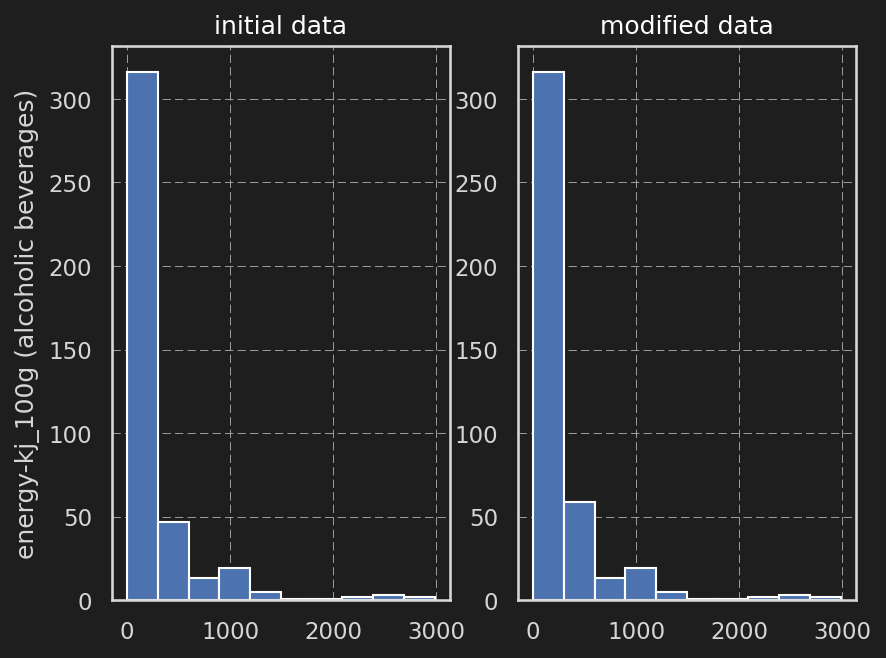

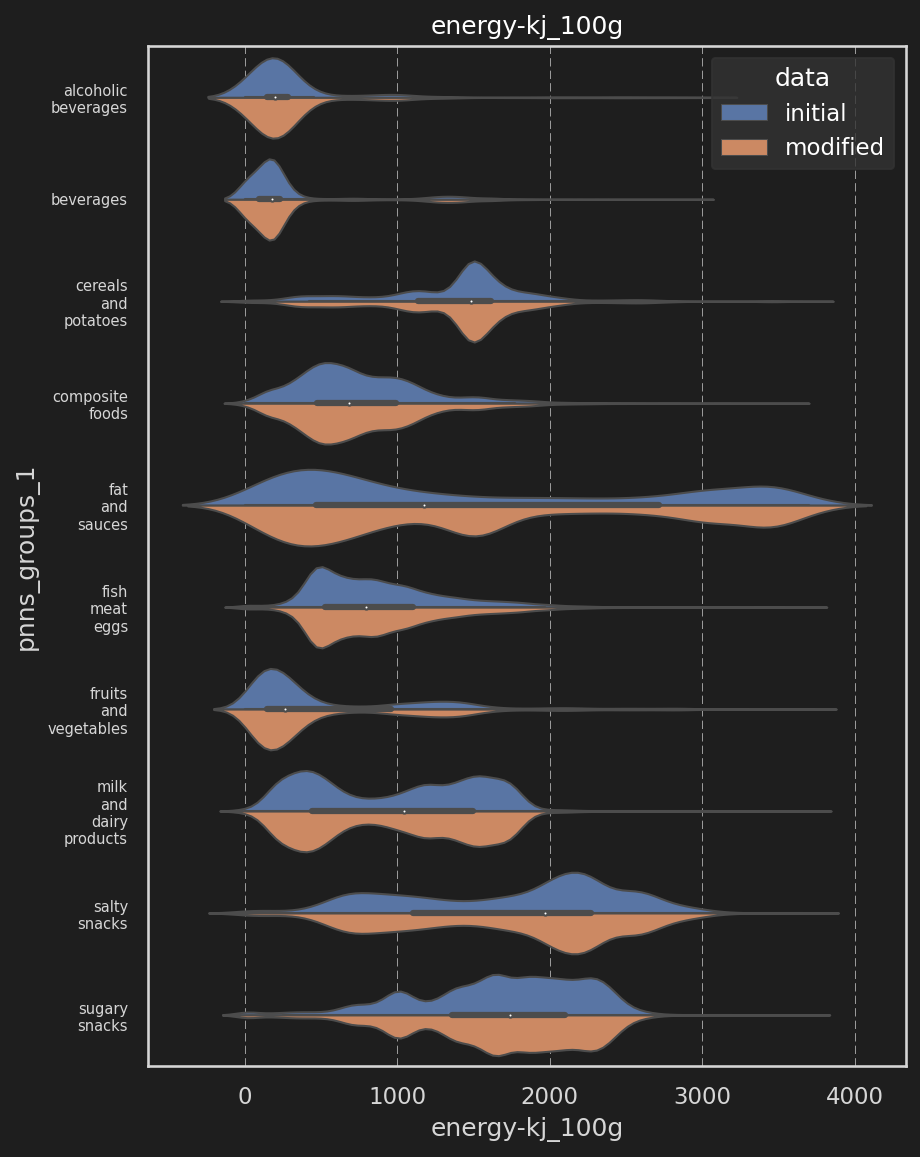

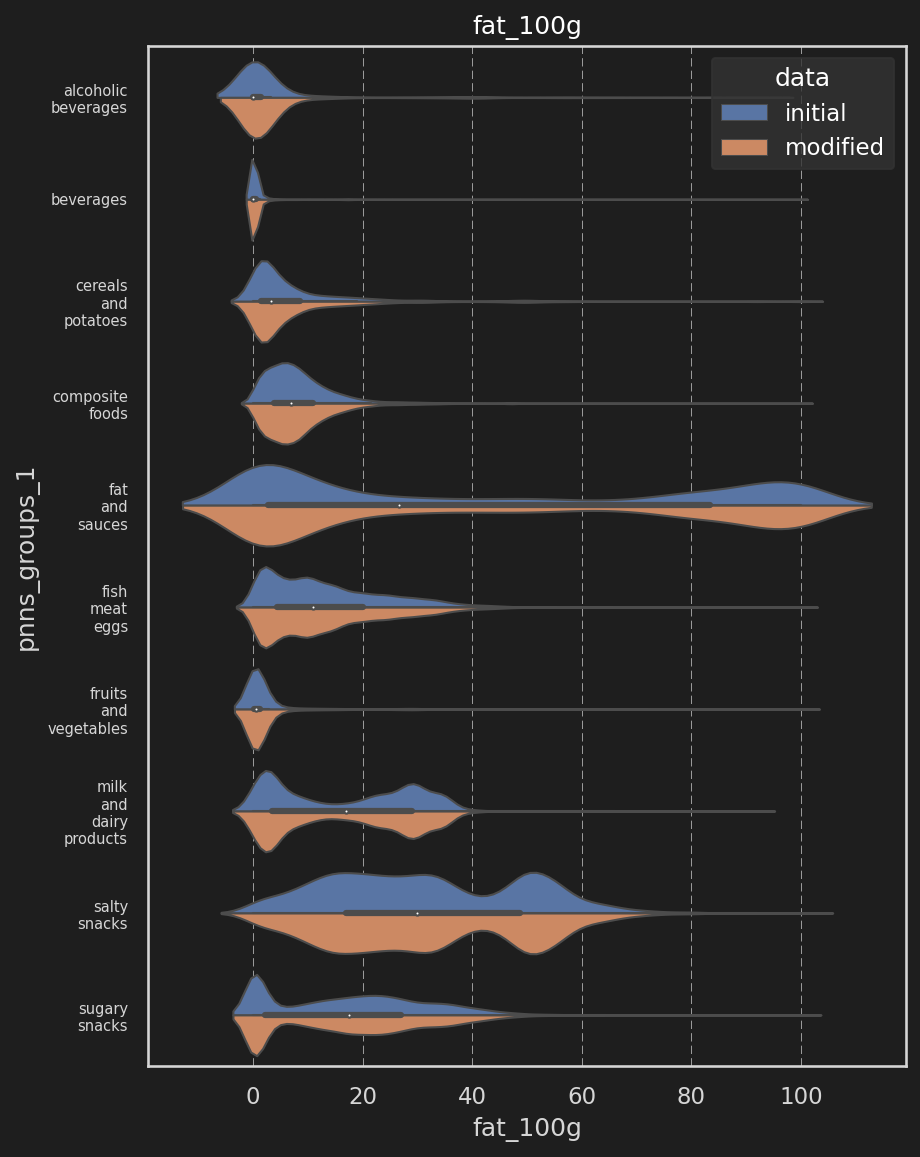

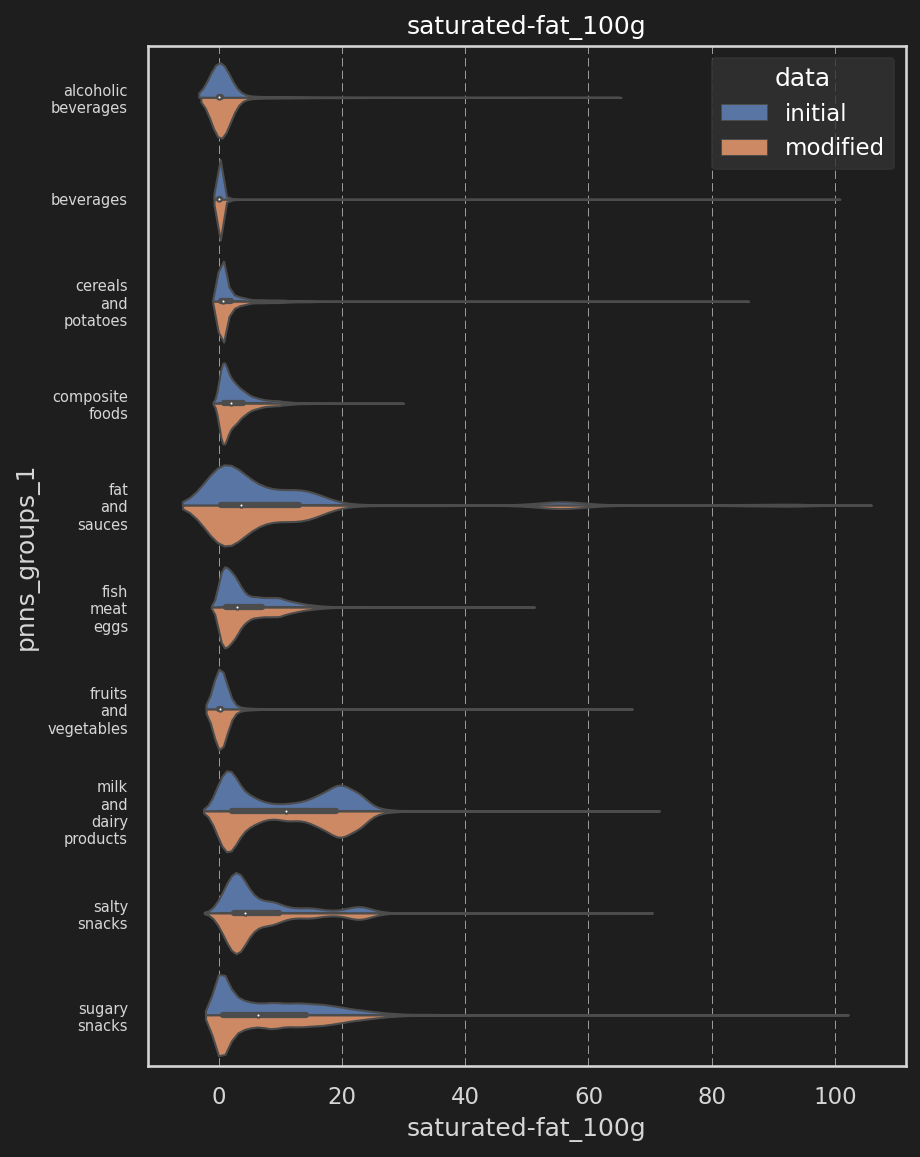

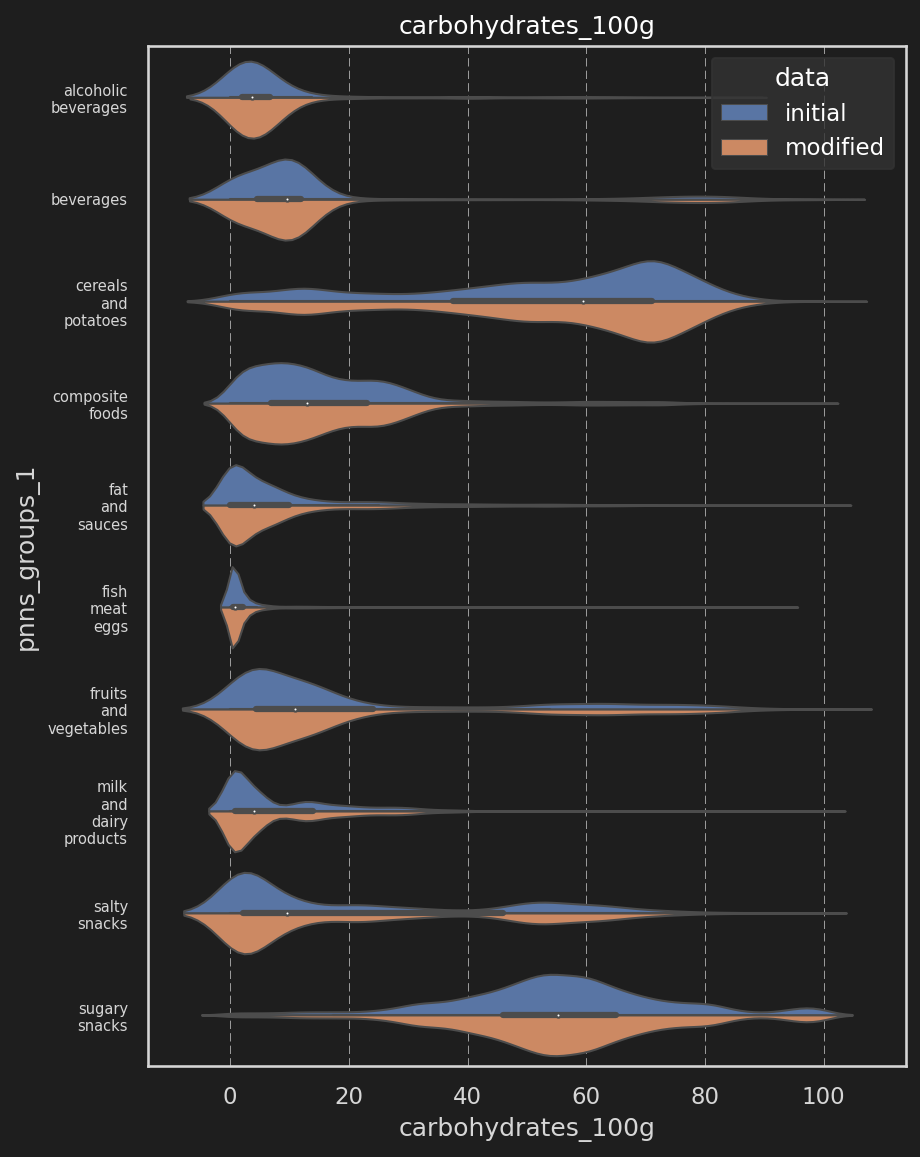

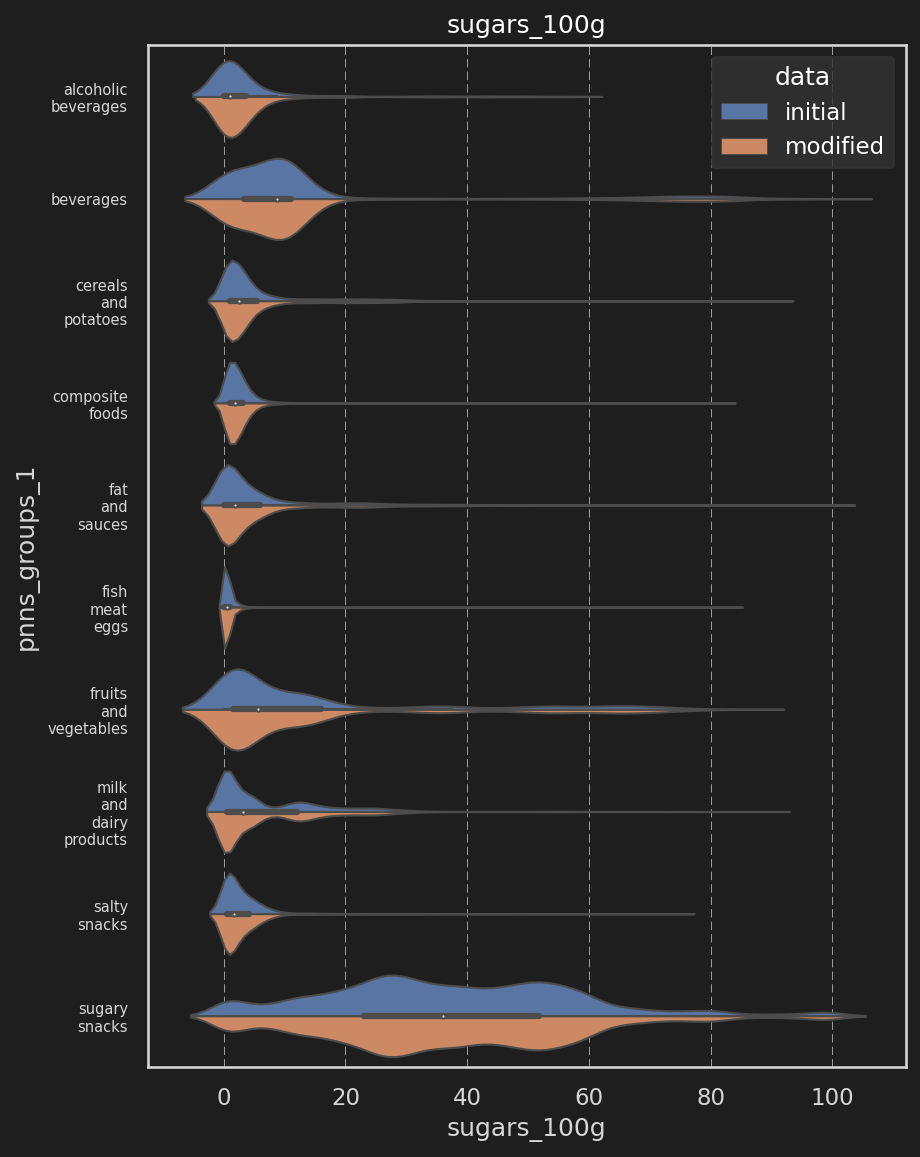

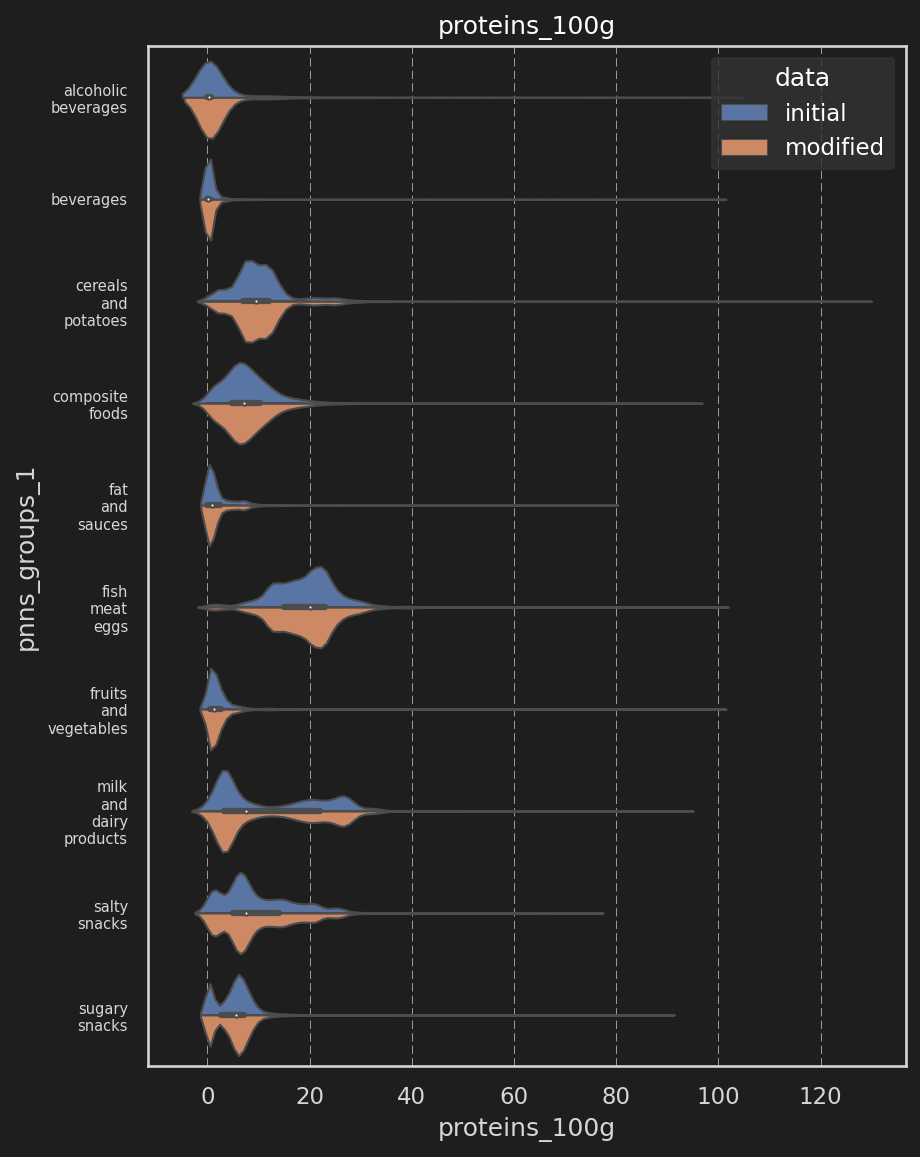

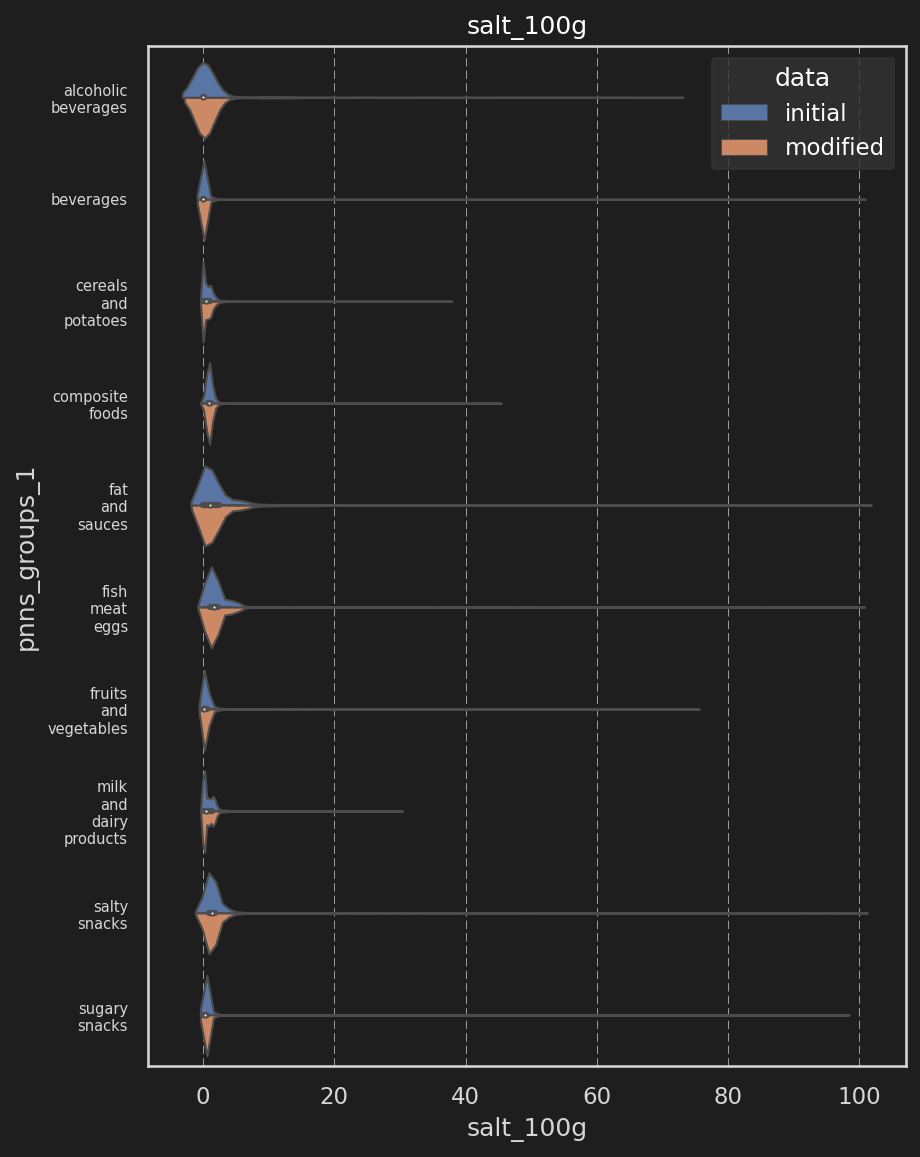

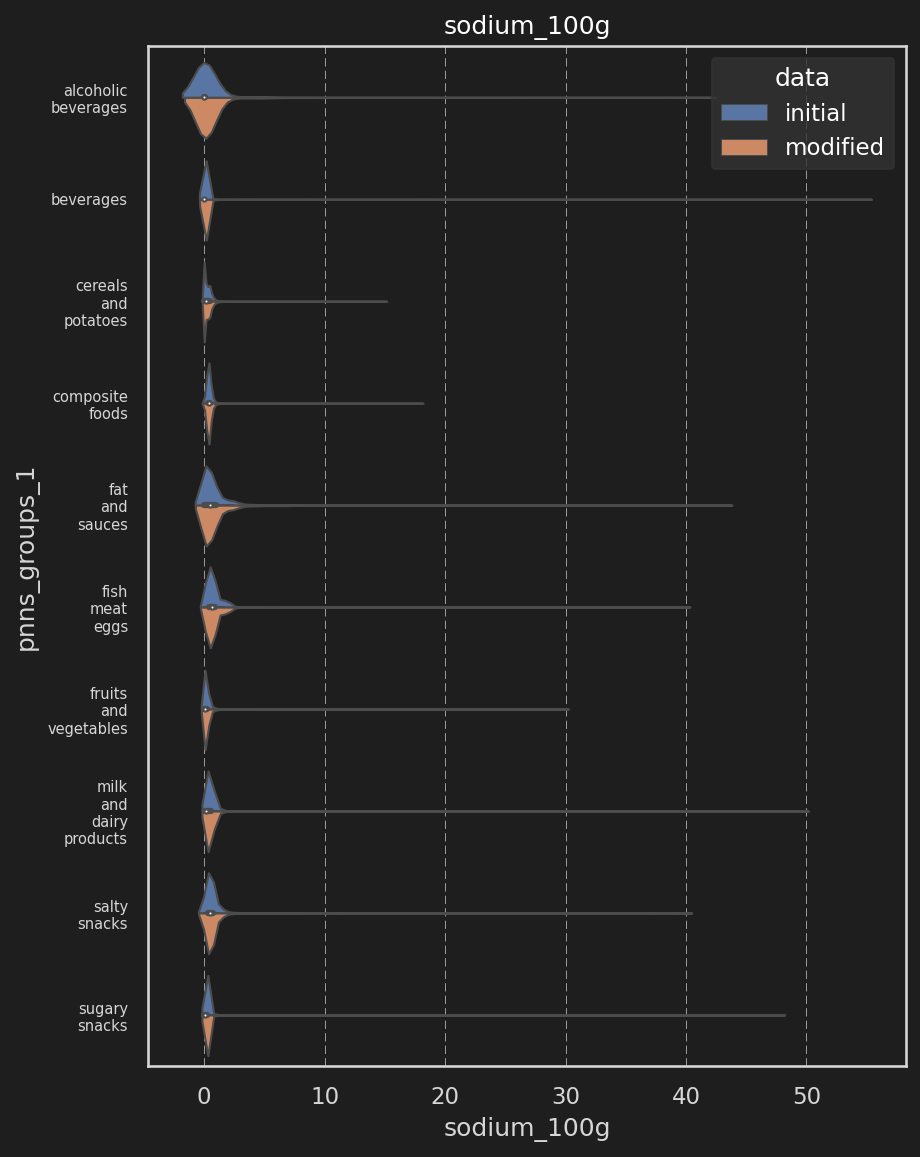

In [16]:
data['data'] = pd.Series('initial', index=data.index, dtype='category')

# new data set with fillna with median value in each pnns_groups_1
data_mean = data.copy()
data_mean['data'] = data_mean['data'].map( {'initial':'modified'} )
groups = data[ keys_100g.tolist() + ['pnns_groups_1'] ].groupby( 'pnns_groups_1' )

# apply only if pnns_groups is defined
data_mean.loc[ ~(data_mean['pnns_groups_1'].isna()) , keys_100g ] = data_mean[keys_100g].fillna( groups.transform('mean') )

print('Number of added values:')
display( data[keys_100g].isna().sum(0) - data_mean[keys_100g].isna().sum(0) )

# check process
key = 'energy-kj_100g'
pnns = 'alcoholic beverages'
sr_loc = data[key].isna() & (data['pnns_groups_1'] == pnns)
sr_loc0 = ~data[key].isna() & (data['pnns_groups_1'] == pnns)

print( (data_mean.loc[sr_loc, key] != data[key].mean()).sum() )
print('mean {:}: {:.3f}'.format(key, data[key].mean()  ))
print( data.loc[sr_loc, key]  )
print( data_mean.loc[sr_loc, key]  )

sr_loc2 = (data['pnns_groups_1'] == pnns)
print('\ndata {:} ({:}) mean: {:.3f}, modified: {:.3f}'.format( key, pnns, data.loc[sr_loc0,key].mean(), data_mean.loc[sr_loc,key].mean() ) )
print('\ndata {:} ({:}) mean: {:.3f}, modified: {:.3f}'.format( key, pnns, data.loc[sr_loc2,key].mean(), data_mean.loc[sr_loc2,key].mean() ) )

fig, axs = plt.subplots( ncols=2 )
axs[0].hist( data.loc[sr_loc2, key] )
axs[1].hist( data_mean.loc[sr_loc2, key] )
axs[0].set_ylabel( '{:} ({:})'.format(key, pnns) )
axs[0].set_title('initial data')
axs[1].set_title('modified data')

for key in keys_100g:
    fig, ax = plt.subplots( figsize=(16*cm,20*cm) )
    ax.set_title( key )
    sns.violinplot( y='pnns_groups_1', x=key, data=pd.concat( (data, data_mean) ), ax=ax,
        linewidth=1, scale='count', hue='data', split=True )
    # sns.violinplot( x='pnns_groups_1', y=key, data=data_mean, ax=axs[1],
    #     linewidth=1, scale='width' )
    # ax.set_xticklabels([])
    ax.set_yticklabels( [label.get_text().replace(' ', '\n') for label in ax.get_yticklabels()] , fontsize=7 )
    # axs[1].set_ylabel( axs[1].get_ylabel() + ' (ajout mean)')
    # ax.set_xlabel('')
    # ax.set_ylabel('initial')
    # axs[1].set_ylabel('modifié')

    fig.tight_layout()

    # ax.legend( ncols=4, fontsize=7 )
    # break


## Affichage des histogrammes pour les différentes variabes float
- Au moins 2 groupes sont visibles pour différentes variables
- les distributions présentent un `skweness empirique > 0`
- 1 second groupe (très petit) est parfois visible 
    - on imagine facilement les huiles / les pacquets de sel pour les variables "fat" et "salt"

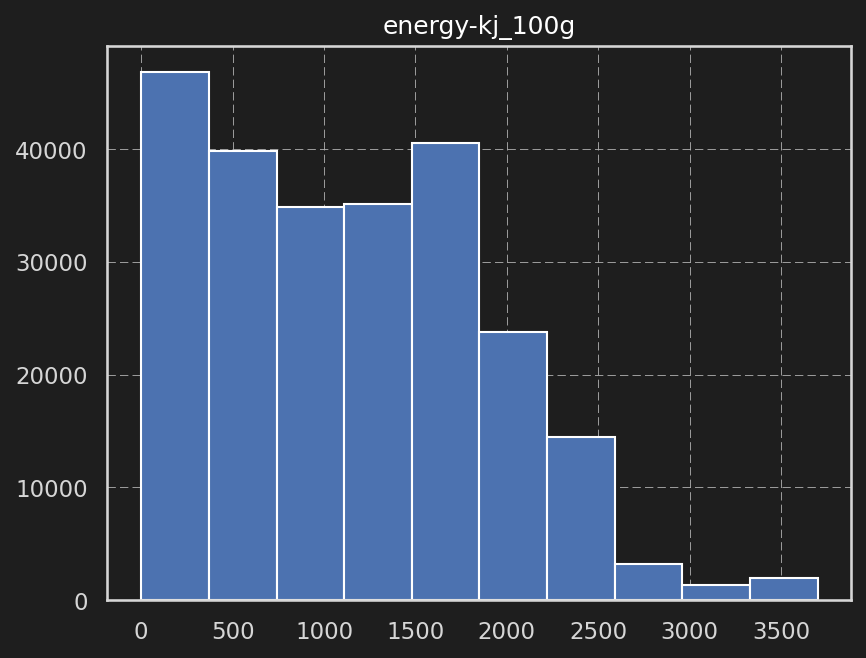

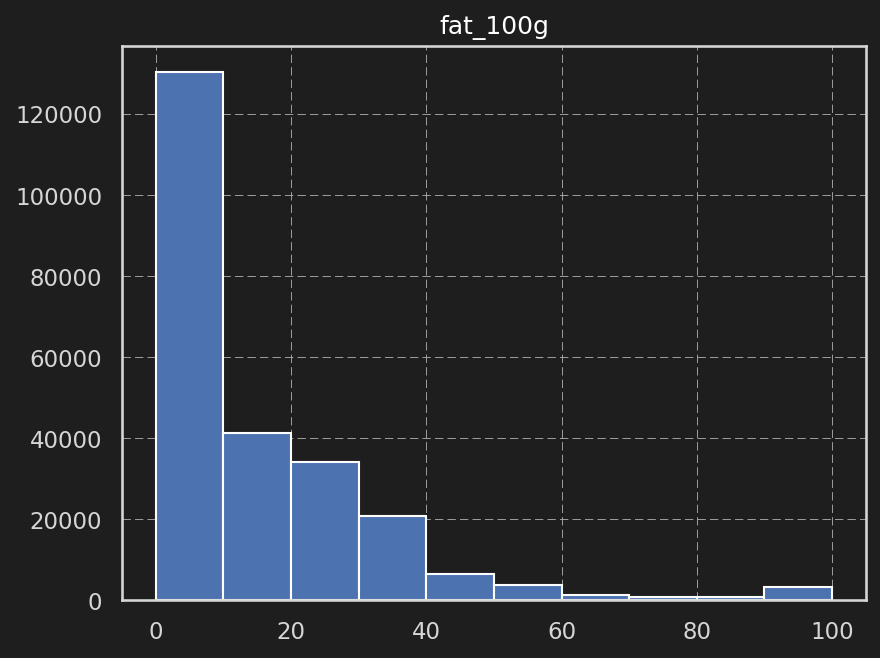

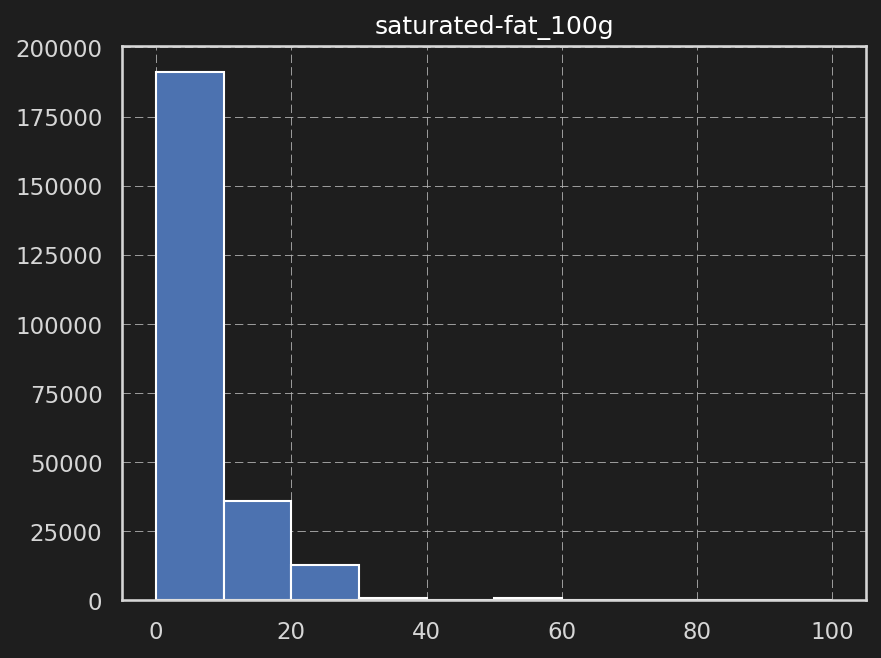

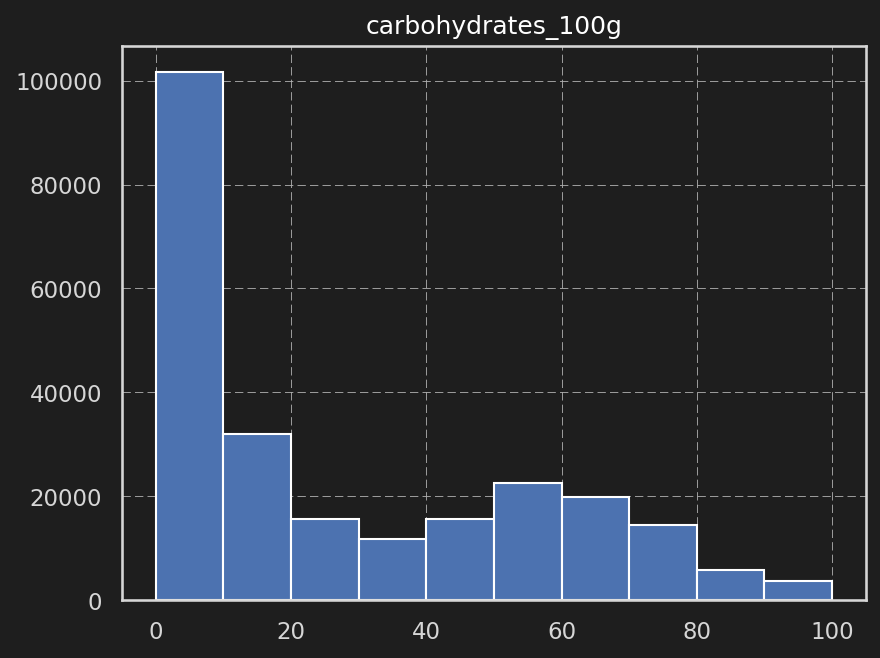

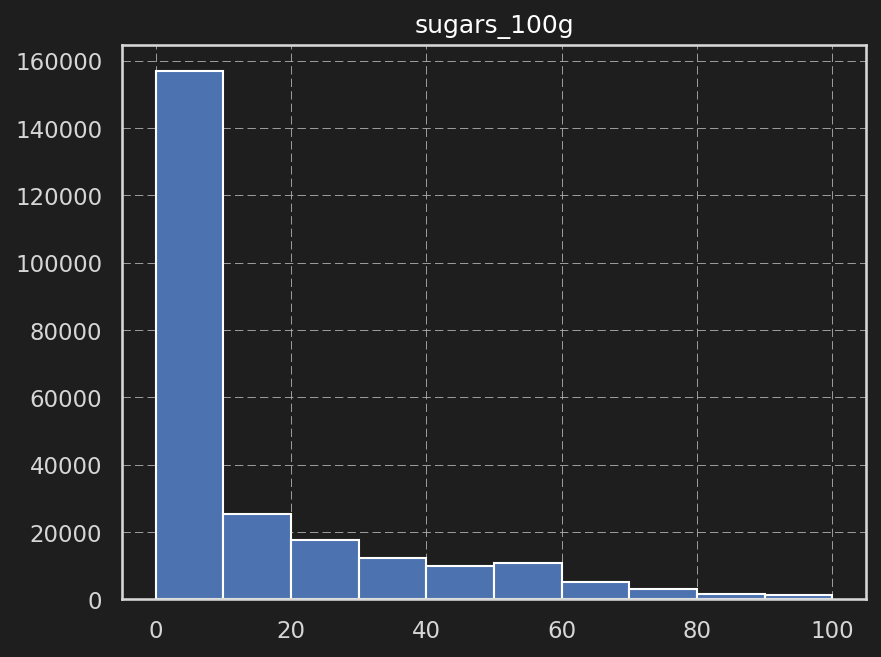

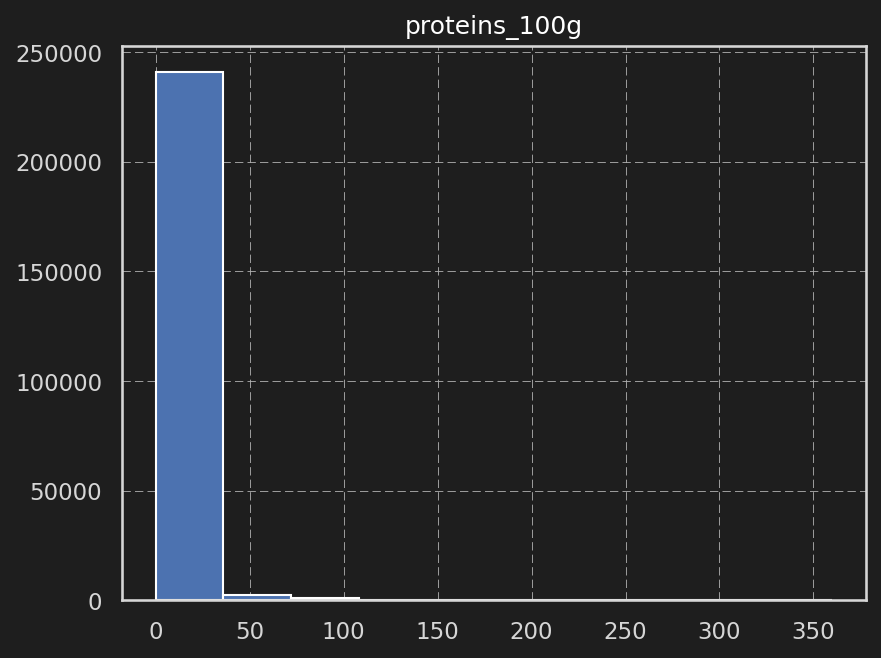

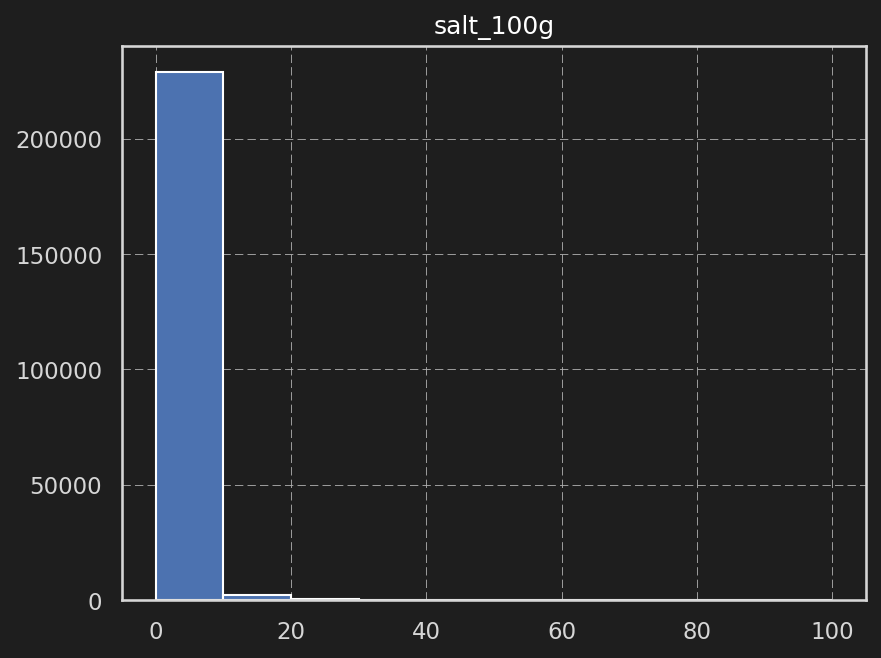

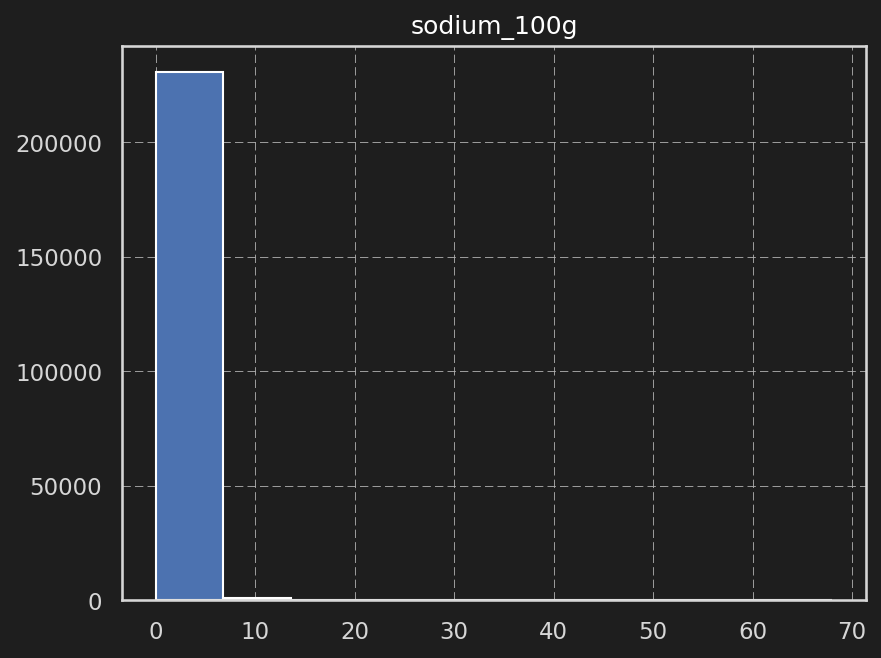

In [17]:
for key in keys_100g:
    fig, ax = plt.subplots()
    data[ key ].hist( ax=ax )
    ax.set_title(key)

In [18]:
data[keys_100g].describe()

energy-kj_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count   241768.000000  243100.000000       242100.000000        243094.00000   
mean      1144.209250      14.382636            5.513154            27.33147   
std        754.646525      17.499107            7.976424            27.65882   
min          0.000000       0.000000            0.000000             0.00000   
25%        485.000000       1.200000            0.280000             2.90000   
50%       1105.000000       8.300000            2.100000            14.00000   
75%       1670.000000      22.622500            8.100000            52.00000   
max       3700.000000     100.000000          100.000000           100.00000   

         sugars_100g  proteins_100g      salt_100g    sodium_100g  
count  243371.000000  243950.000000  232120.000000  232130.000000  
mean       13.808533       8.995807       1.289560       0.518297  
std        20.007984      10.004242       4.309487       1.761309  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.700000       1.700000       0.090000       0.036000  
50%         3.570000       6.300000       0.590000       0.236000  
75%        20.000000      13.000000       1.370000       0.548000  
max       100.000000     360.000000     100.000000      68.000000

## Iterative imputer
Les résultats semblent `corrects` (peu de modification des distributions) excepté pour les boissons alcolisées qui montrent une forte modification

<span style="color:red"> Problème affichage violinplot </span>

Number of added values:


energy-kj_100g         3048
fat_100g               1716
saturated-fat_100g     2716
carbohydrates_100g     1722
sugars_100g            1445
proteins_100g           866
salt_100g             12696
sodium_100g           12686
dtype: int64

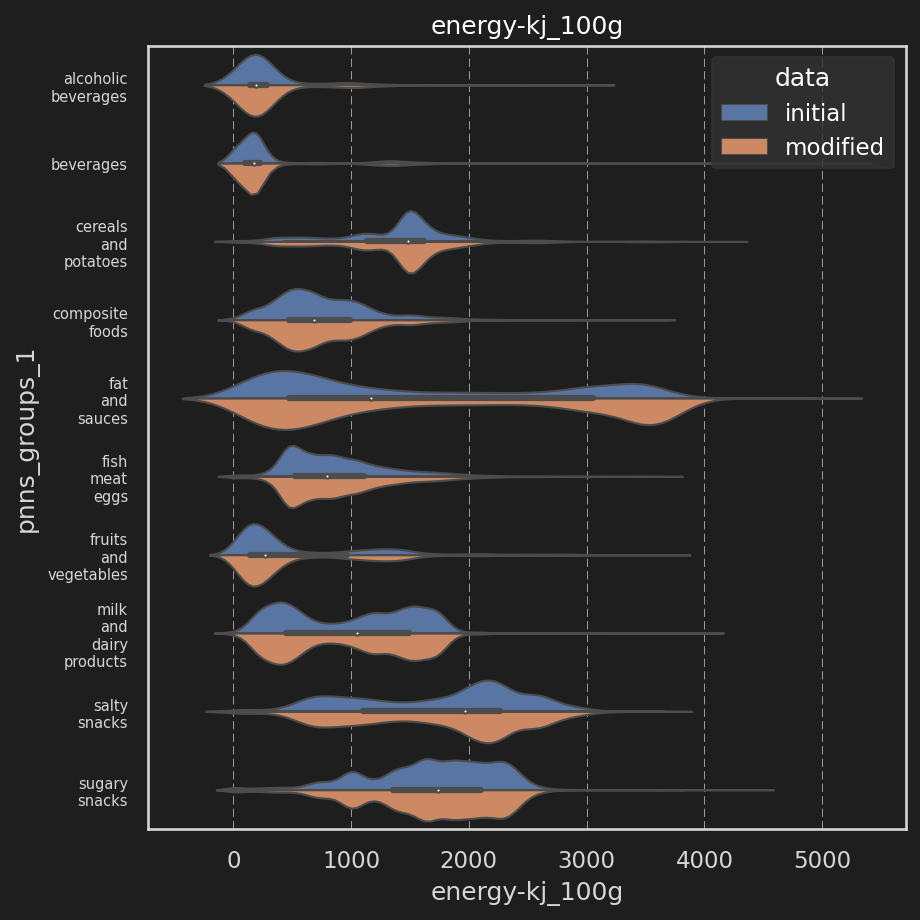

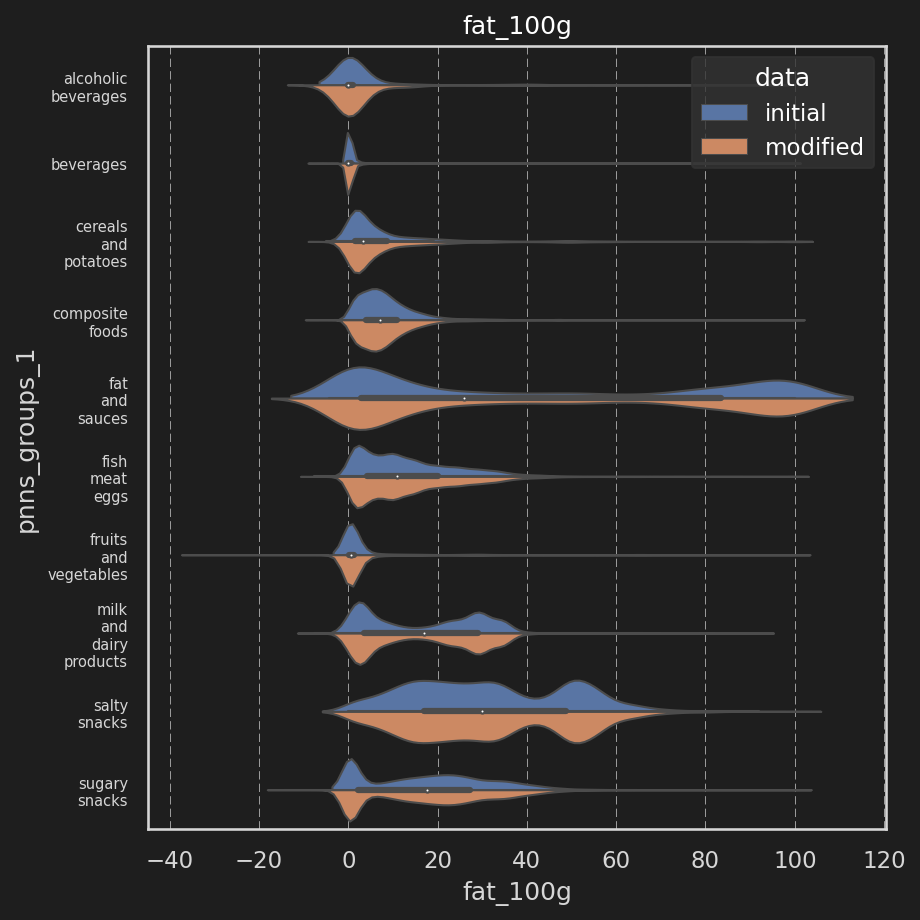

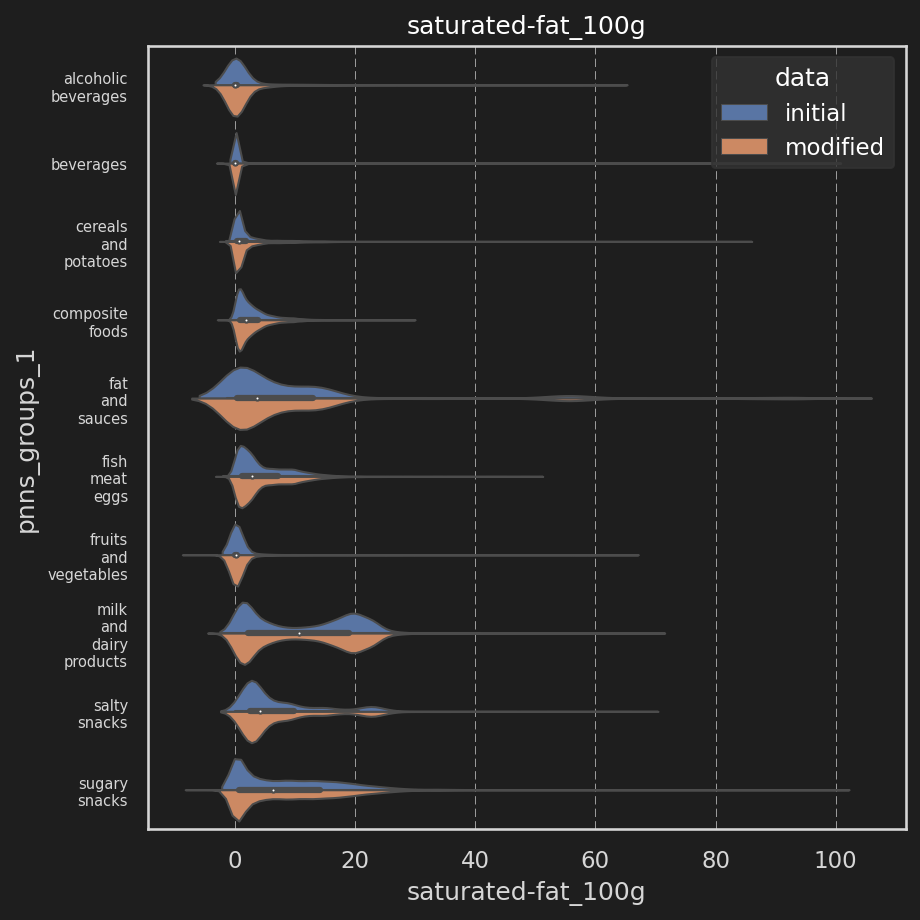

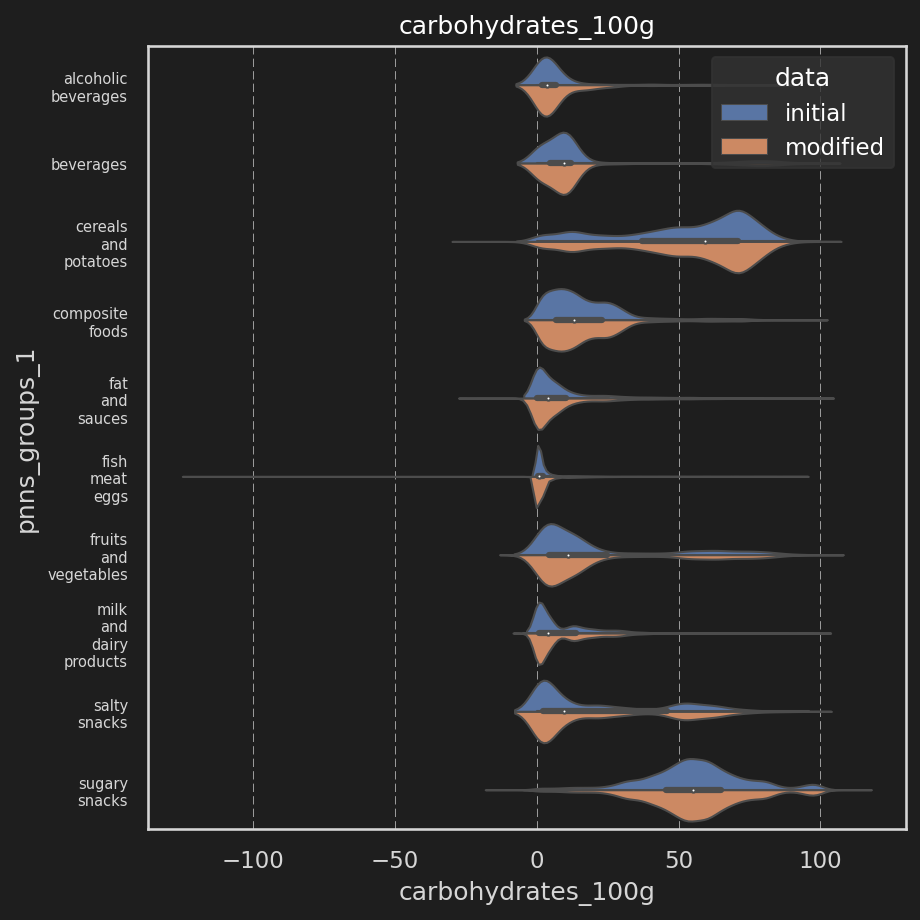

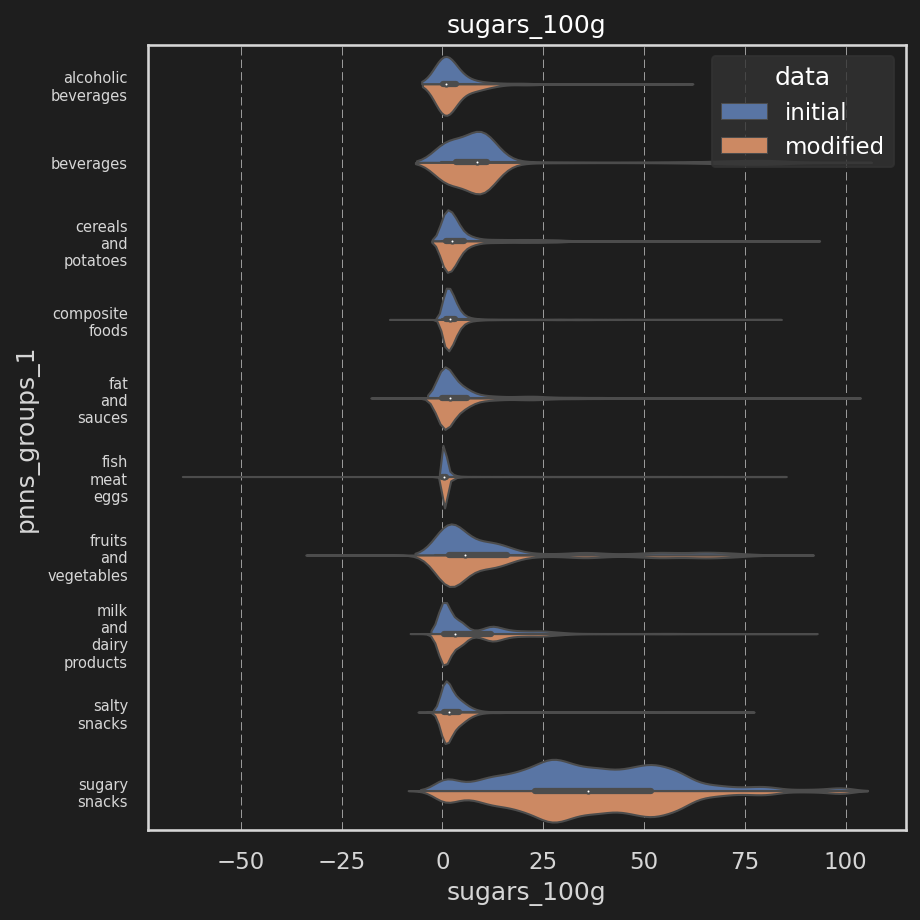

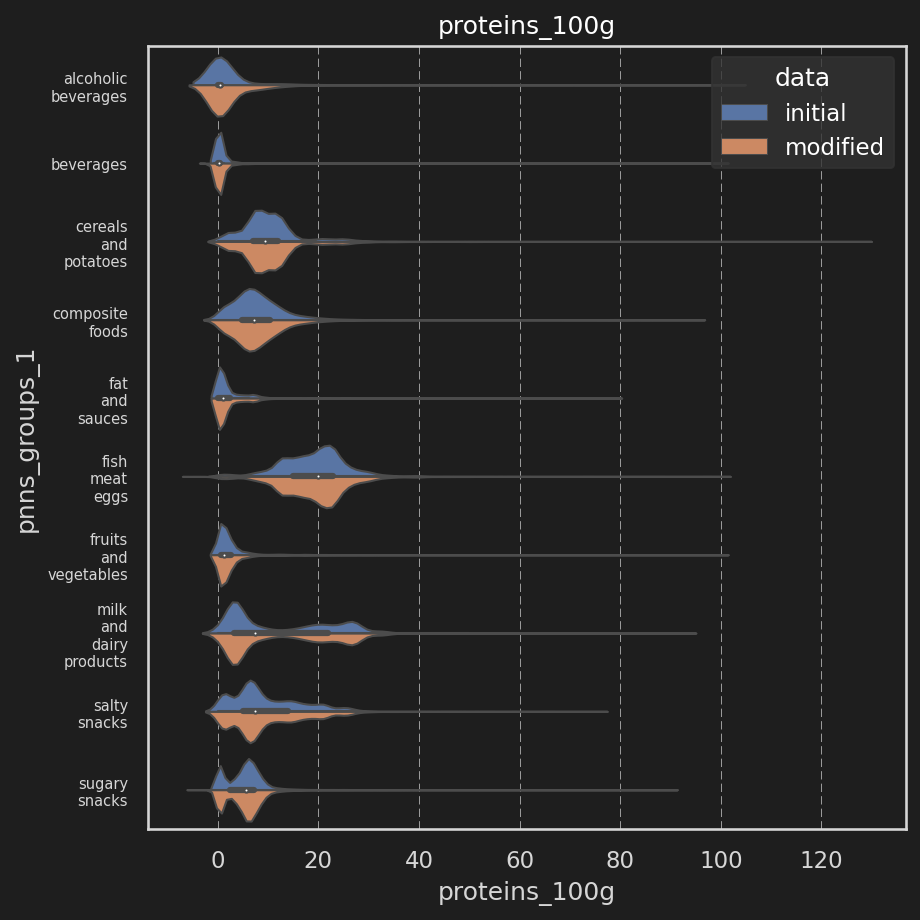

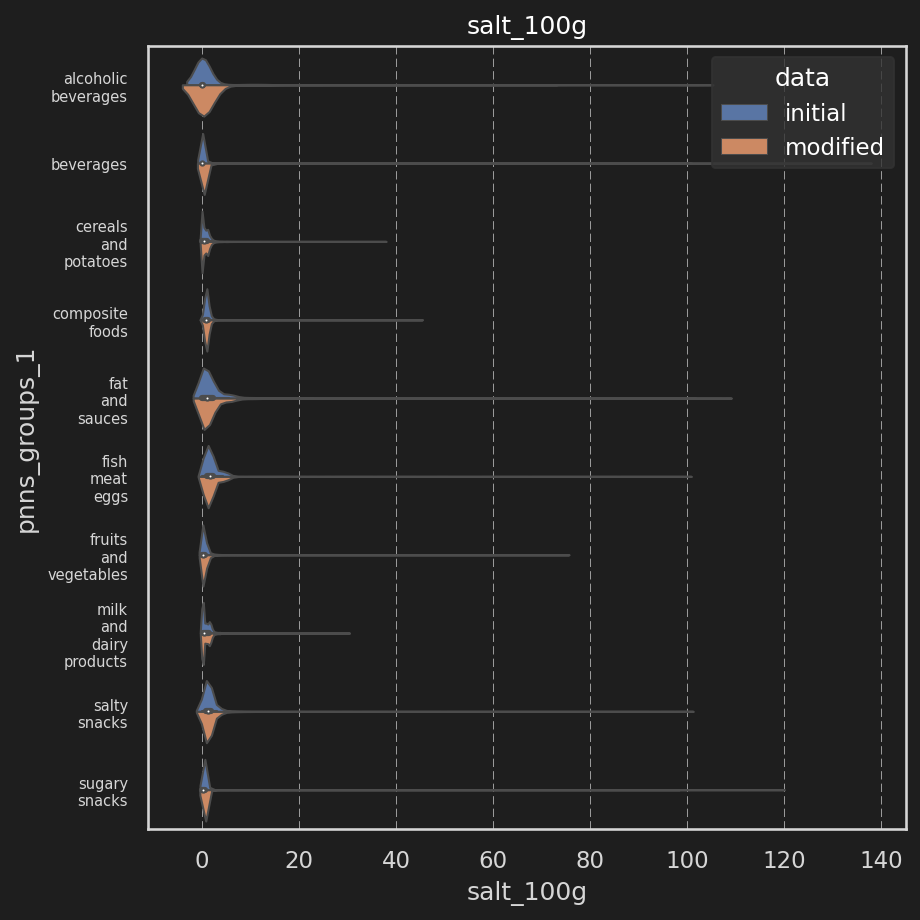

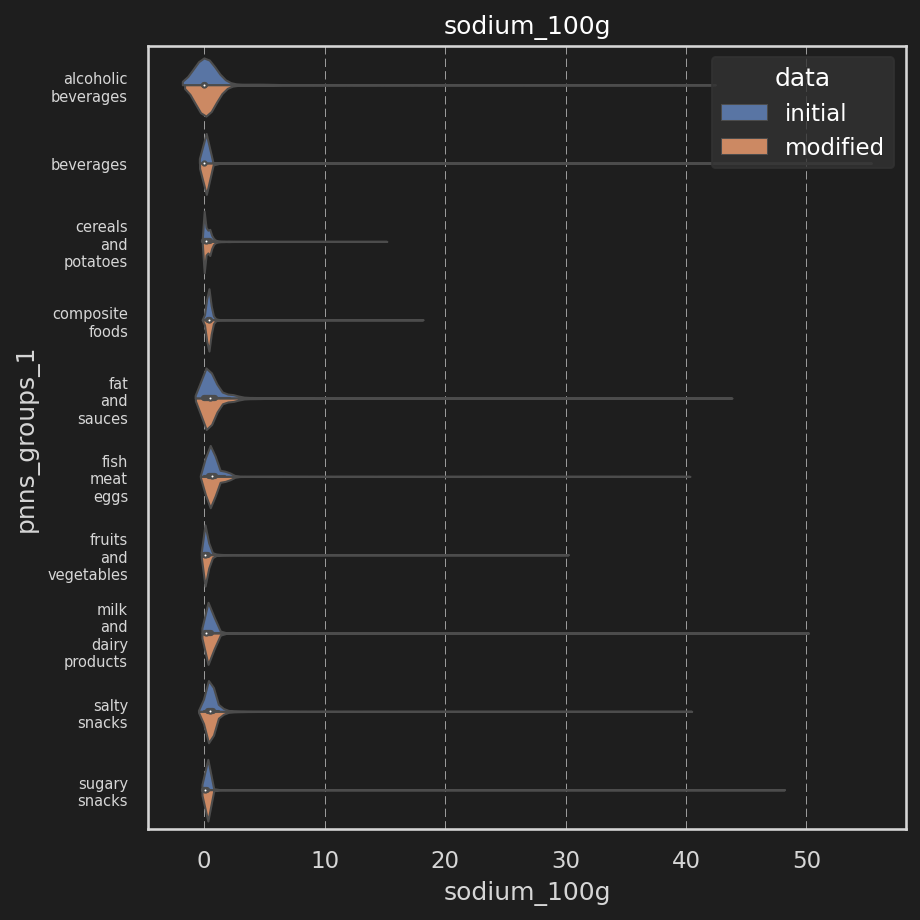

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


v_isall_filled = data[keys_100g].isna().sum(1) == 0


imp = IterativeImputer(max_iter=20, random_state=0)

# X_fit = np.hstack( (xtrain, ytrain.reshape(-1,1)) )

imp.fit( data.loc[ v_isall_filled, keys_100g].values )
IterativeImputer(random_state=0)

# X_test = np.hstack( (xtest, np.full(shape=xtest[:,:1].shape, fill_value=np.nan) ) )

# X_pred = imp.transform( data[keys_100g].values )
# data_imputer = pd.Series( {key: x for key,x in zip( keys_100g, X_pred.T )} )
# data_imputer['pnns_groups_1'] = data['pnns_groups_1']

data_imputer = data.copy()
data_imputer['data'] = data_imputer['data'].map( {'initial': 'modified'} )

data_imputer.loc[ ~v_isall_filled, keys_100g ] = \
                imp.transform( data.loc[~v_isall_filled, keys_100g ].values )

print('Number of added values:')
display( data[keys_100g].isna().sum(0) - data_imputer[keys_100g].isna().sum(0) )


for key in keys_100g:
    fig, ax = plt.subplots( figsize=(16*cm,16*cm) )
    ax.set_title( key )
    sns.violinplot( y='pnns_groups_1', x=key, data=pd.concat((data, data_imputer)), ax=ax,
        linewidth=1, scale='count', hue='data', split=True )
    # axs[0].set_xticklabels([])
    ax.set_yticklabels( [label.get_text().replace(' ', '\n') for label in ax.get_yticklabels()] , fontsize=7 )
    # axs[1].set_ylabel( axs[1].get_ylabel() + ' (ajout Imputer)')

    fig.tight_layout()

    # ax.legend( ncols=4, fontsize=7 )
    # break


***
# K-nn : nutriscore

Définition d'une fonction k-nn

In [99]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors

def fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax ):
    errors, dico_knn = [], {}
    for k in range(kmin, min(kmax+1, len(ytrain) ) ):
        print('k: {:02}'.format(k), end='\r')
        if ytrain.dtype in ['object', 'category']:
            knn = neighbors.KNeighborsClassifier(k)
        else:
            knn = neighbors.KNeighborsRegressor(k)
        dico_knn[k] = knn
        # knn.fit(xtrain, ytrain)
        errors.append(100*(1-knn.fit(xtrain, ytrain).score(xtest, ytest) ) )
    return dico_knn, np.array(errors)

Définition d'une fonction plot

In [101]:
def plot_knn( kmin, errors, ntrain, ntest, xtest_scaled, ytest, knn, key_target, key=None ):
    imin_error_knn = np.argmin(errors)
    k_min_error = kmin + imin_error_knn
    fig, axs = plt.subplots( ncols=2, figsize=(20*cm, 8*cm))
    ax = axs[0]
    if key is None:
        fig.suptitle( 'n train: {:}, n test: {:}'.format( ntrain, len(ytest) ) )
    else:
        fig.suptitle( '{:} - n train: {:}, n test {:}'.format(key, ntrain, len(ytest) ) )
    ax.plot( range(kmin, kmin+len(errors)), errors, 'o-b')
    ax.plot( [k_min_error], [errors[imin_error_knn]], 'or' )
    ax.set_xlabel( 'n neighbors')
    ax.set_ylabel(r'100*(1-R$^2$)')
    ax.annotate( '{:.2f}%'.format(errors[imin_error_knn]), 
            [k_min_error, errors[imin_error_knn] + 0.1*np.ptp(errors) ],
            color='r', va='bottom', ha='center')

    argsort = ytest.argsort()
    ax = axs[1]
    ax.plot( ytest[argsort], 'b', label='y test' )
    ax.plot( knn.predict( xtest_scaled )[argsort], 'ro', 
                markersize=1, zorder=0, label='prediction' )
    lgnd = ax.legend( )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend

    ax.set_xlabel( 'i test' )
    ax.set_ylabel( key_target )

    fig.tight_layout()

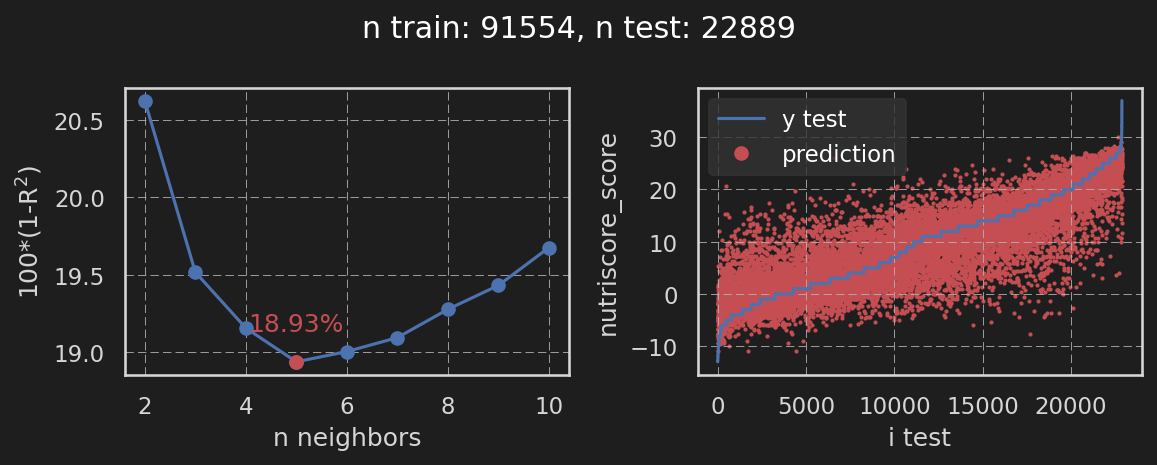

In [97]:
key_target = 'nutriscore_score'
sr_loc = data[keys_100g.tolist() + [key_target]].isna().sum(1) == 0


xtrain, xtest, ytrain, ytest = train_test_split( data.loc[sr_loc, keys_100g].values , 
                                    data.loc[sr_loc, key_target].values, train_size=0.8)

kmin, kmax = 2, 10

dico_knn, errors = fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

plot_knn( kmin, errors, len(ytrain), len(ytest), xtest, ytest, knn, key_target, key=None )

Les résultats semblent assez peu fiables. Des améliorations sont clairement à apporter.

## Vérification de la (non-)corrélation des variables
- `carbohydrates` et `sugars`, `fat` et `saturated-fat` sont assez évidemment corrélés
- `salt` et `sodium` sont quasi parfaitement corrélés 

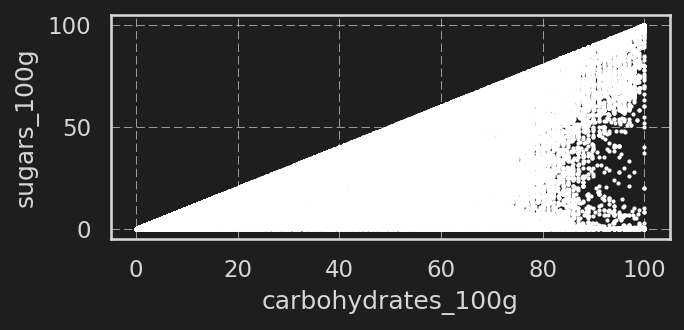

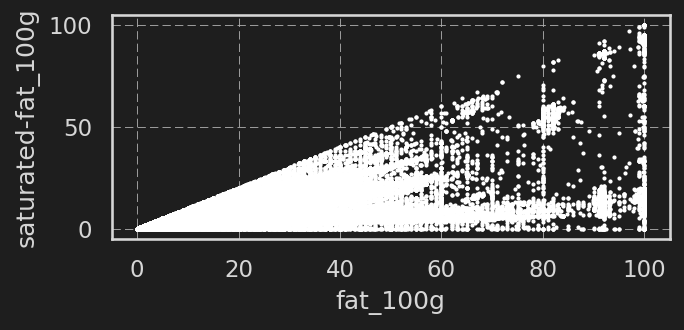

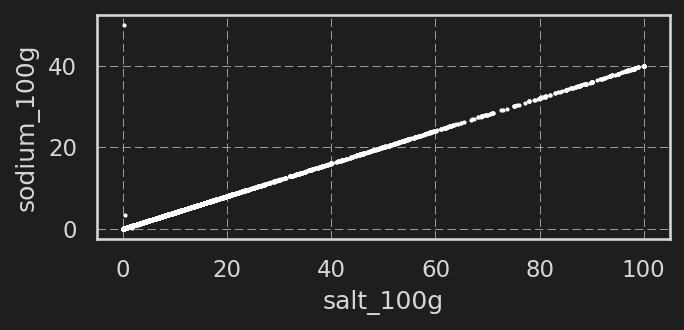

In [83]:
for key1,key2 in [('carbohydrates_100g','sugars_100g') , ('fat_100g', 'saturated-fat_100g'), ('salt_100g','sodium_100g') ]:
    df = data.loc[ data[[key1,key2]].isna().sum(1) == 0 , [key1,key2] ]
    fig, ax = plt.subplots( figsize=(12*cm,6*cm) )
    df.plot( kind='scatter', x=key1, y=key2, s=1, c='w' , ax=ax )
    fig.tight_layout()

## Mise à jour des variables
Fonction pour extraire un nouveau dataset:
- sans sodium
- fat $\rightarrow$ non-saturated-fat
- carbohydrates $\rightarrow$ non-sugar-carbohydrates

In [31]:
def updated_data( data ):
    data_new = data[ ['energy-kj_100g', 'saturated-fat_100g', 'sugars_100g',
                    'proteins_100g', 'salt_100g'] ].copy()
    data_new['non-saturated-fat_100g'] = data['fat_100g'] - data['saturated-fat_100g']
    data_new['non-sugar-carbohydrates_100g'] = data['carbohydrates_100g'] \
                                                - data['sugars_100g']
    return data_new

Test avec les nouvelles varialbes : pas d'amélioration flagrante pour le moment

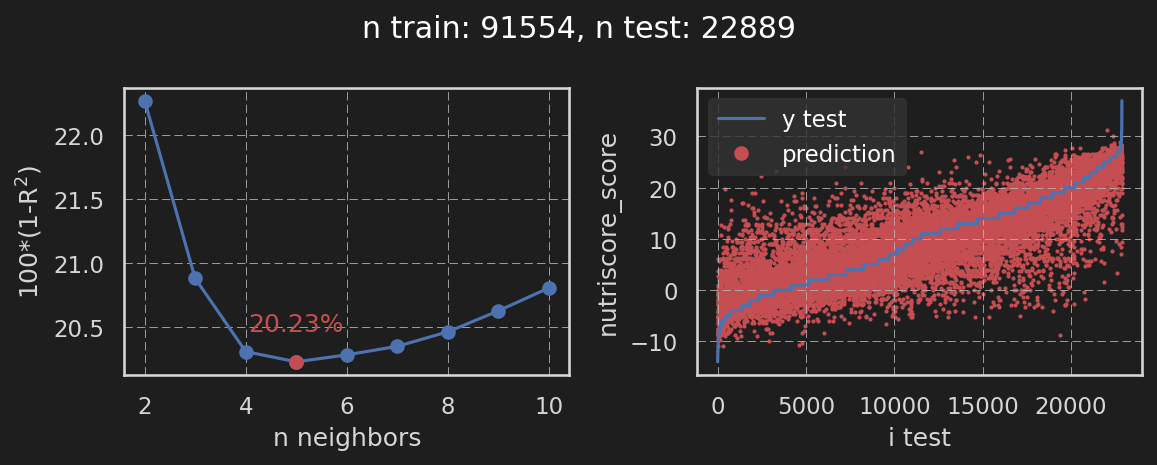

In [91]:
xtrain, xtest, ytrain, ytest = train_test_split( updated_data(data.loc[sr_loc, keys_100g]).values , 
                                    data.loc[sr_loc, key_target].values, train_size=0.8)



dico_knn, errors = fit_and_test_knn( xtrain,ytrain, xtest,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

plot_knn( kmin, errors, len(ytrain), len(ytest), xtest, ytest, knn, key_target, key=None )


## Scaling
Centrer et normer les données améliore les résultats, mais les écarts restent conséquents.

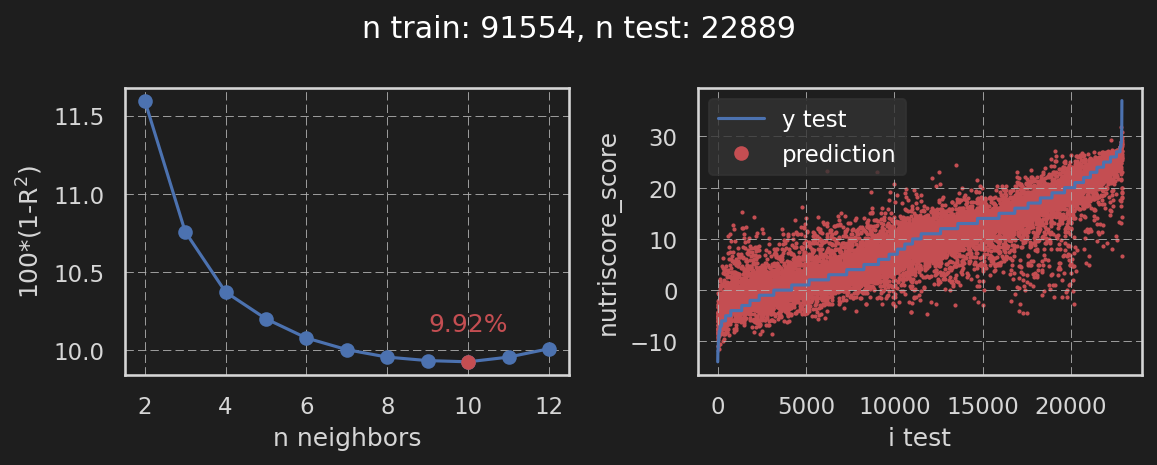

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
xtest_scaled = scaler.transform(xtest)


kmin, kmax = 2, 12


dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=None )

## Ajout de la variable pnns_group (code)
Amélioration non négligeable des résultats

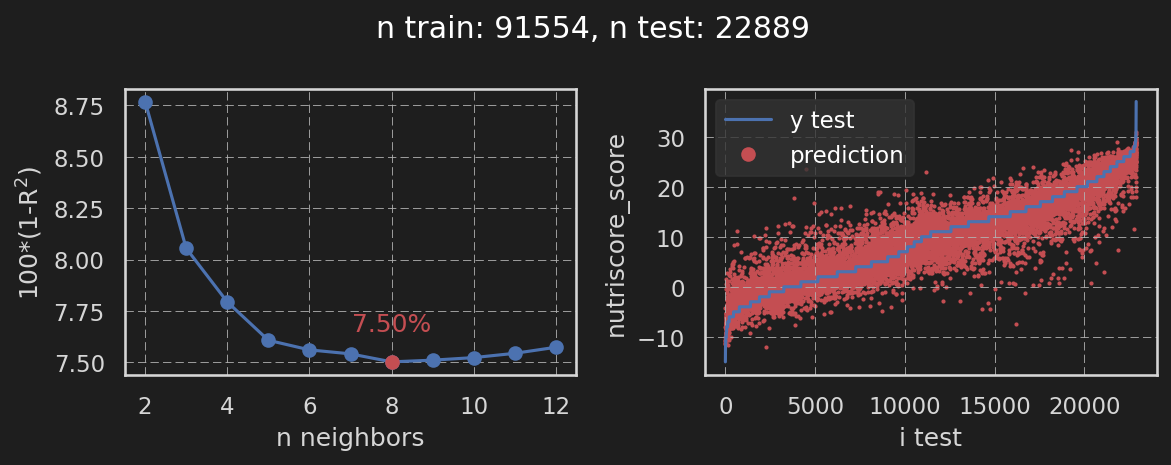

In [94]:
data_new = updated_data(data.loc[sr_loc, keys_100g.tolist() ])
data_new['pnns_groups_1'] = data['pnns_groups_1'].cat.codes
xtrain, xtest, ytrain, ytest = train_test_split( data_new.values , 
                                data.loc[sr_loc, key_target].values, train_size=0.8)


scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
xtest_scaled = scaler.transform(xtest)


kmin, kmax = 2, 12

dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

imin_error_knn = errors.argmin()
k_min_error = kmin + imin_error_knn
knn = dico_knn[imin_error_knn]

plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=None )


## K-NN par pnns_group
Résultats intéressants pour certaines catégories, mais pour la pluspart il n'y a pas asse de données

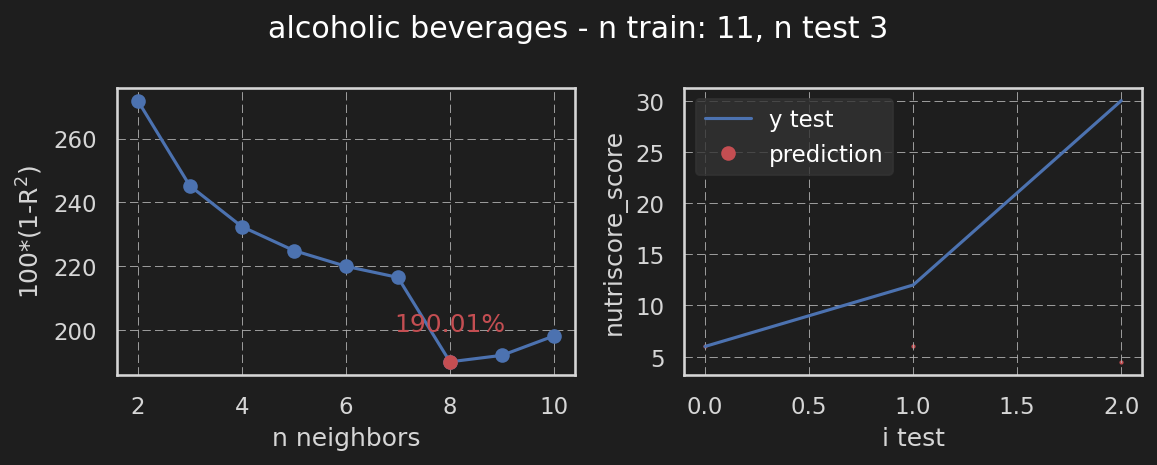

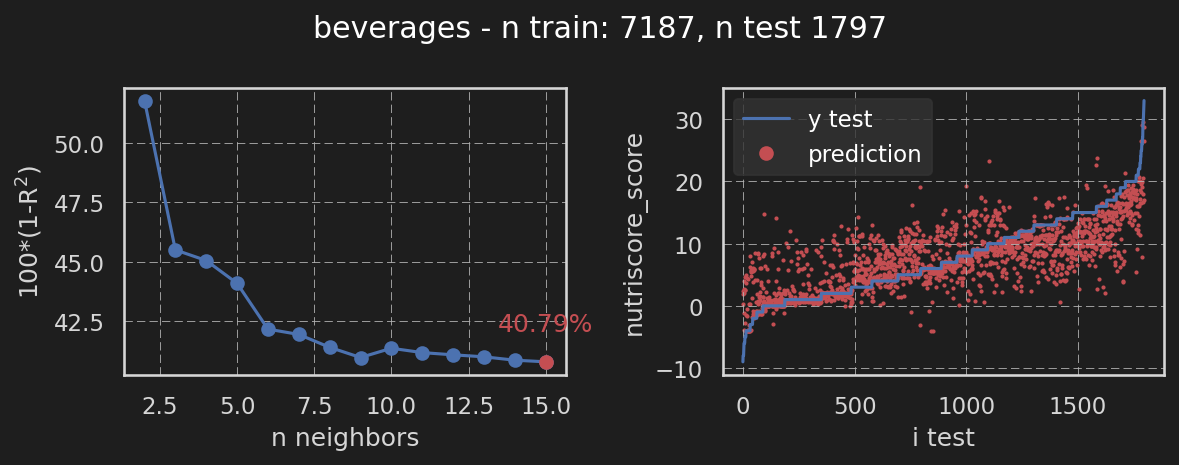

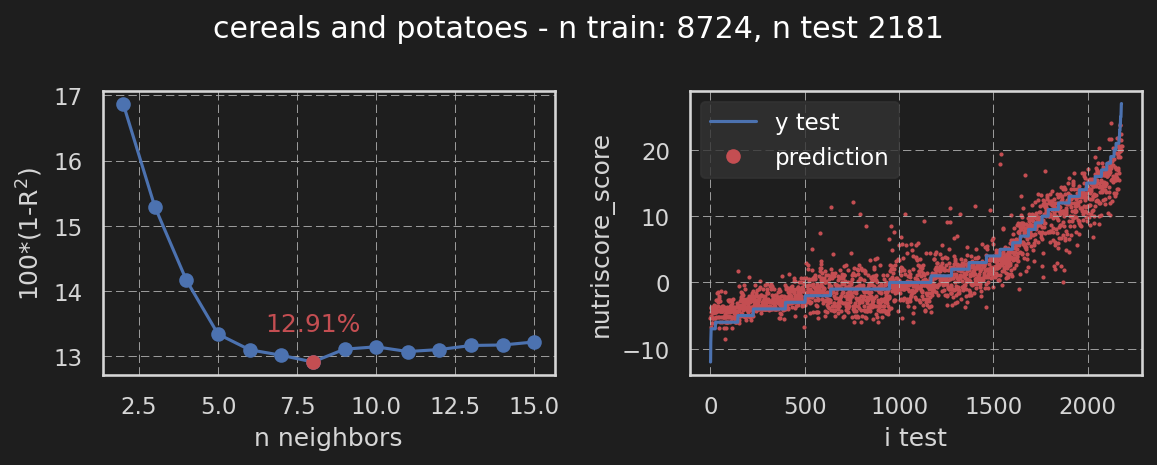

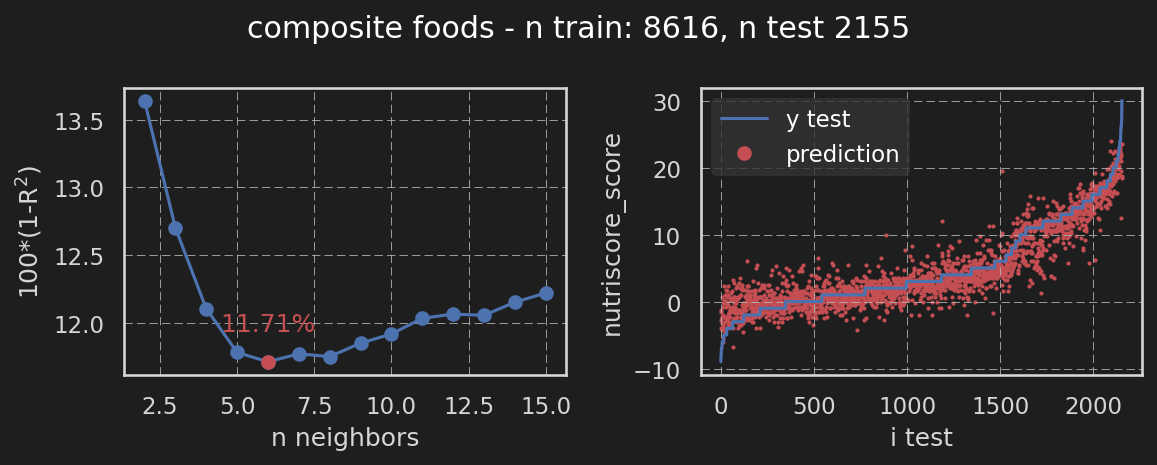

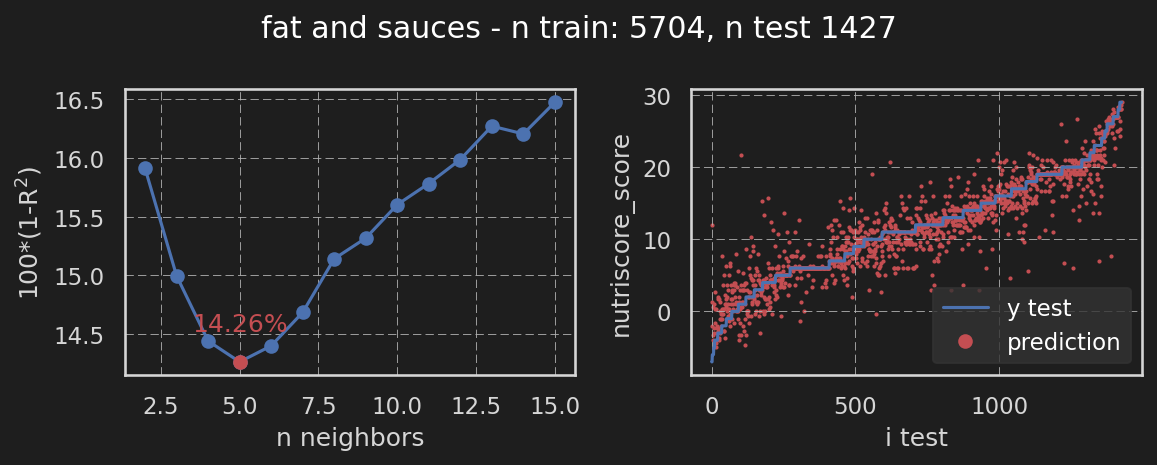

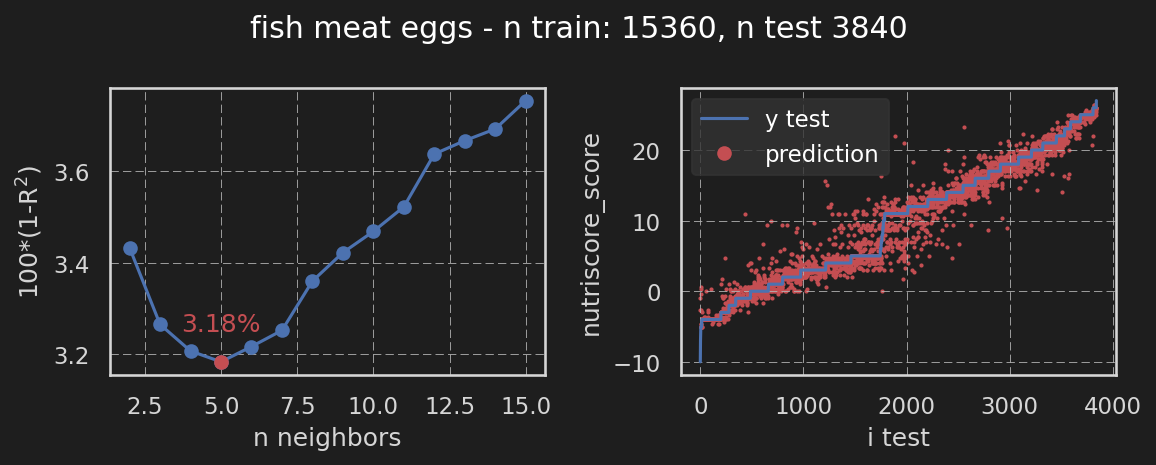

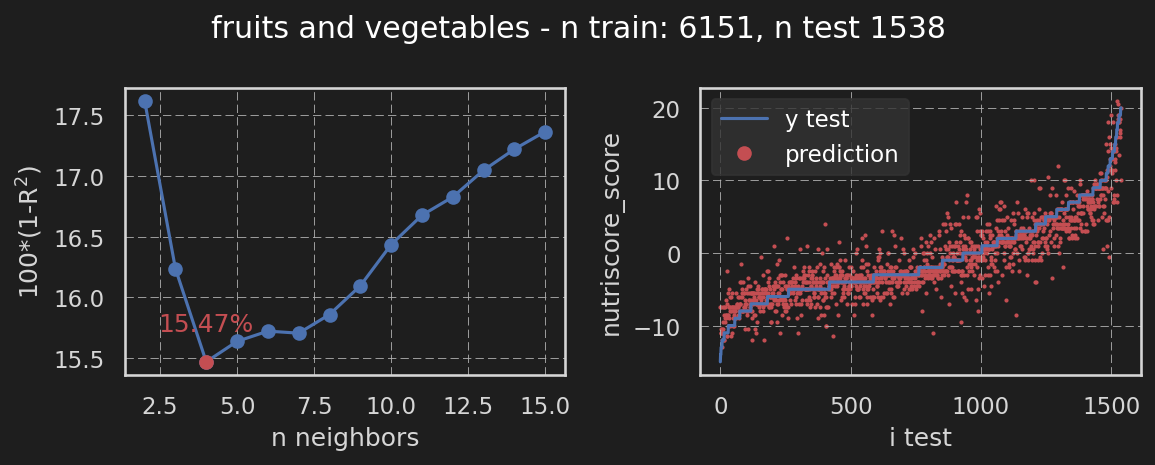

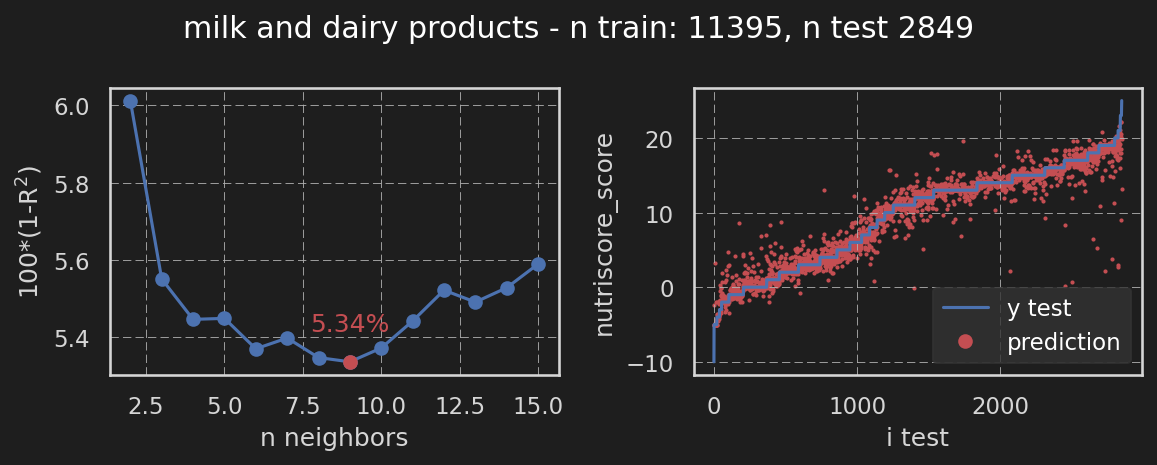

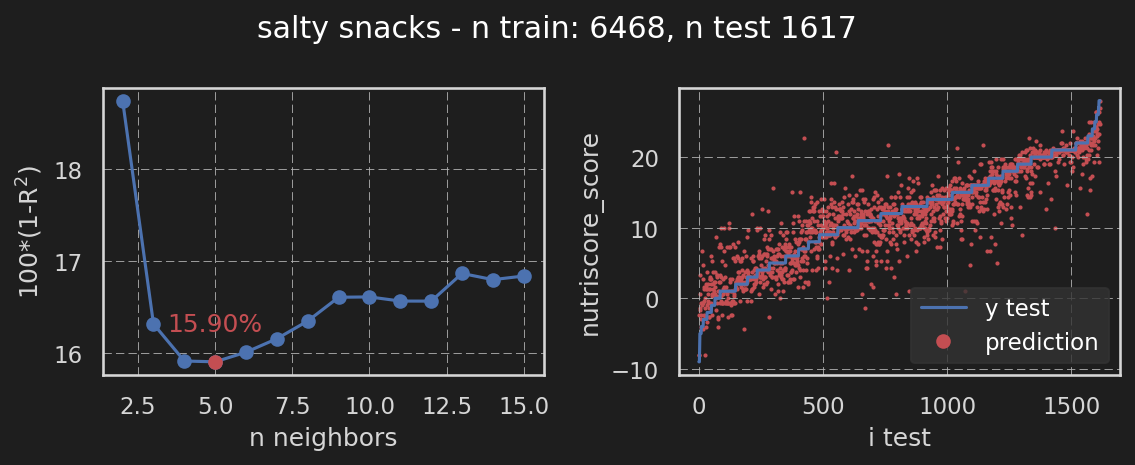

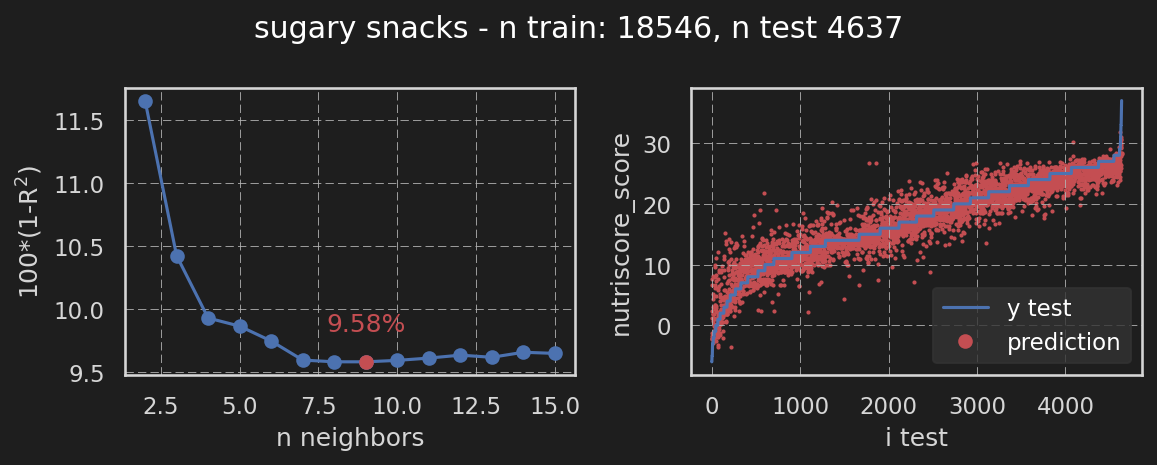

In [102]:
kmin, kmax = 2, 15

sr_0 = data[keys_100g.tolist() + [key_target]].isna().sum(1) == 0
None
dico_knns = {}
for key in data['pnns_groups_1'].cat.categories:
    sr_loc = (data['pnns_groups_1'] == key) & sr_0
    
    xtrain, xtest, ytrain, ytest = train_test_split( updated_data(data.loc[sr_loc, keys_100g]).values , 
                                    data.loc[sr_loc, key_target].values, train_size=0.8)

    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain_scaled = scaler.transform(xtrain)
    xtest_scaled = scaler.transform(xtest)


    dico_knn, errors = fit_and_test_knn( xtrain_scaled,ytrain, xtest_scaled,ytest, kmin, kmax )

    imin_error_knn = errors.argmin()
    k_min_error = kmin + imin_error_knn
    knn = dico_knn[imin_error_knn]

    plot_knn( kmin, errors, len(ytrain), len(ytest), xtest_scaled, ytest, knn, key_target, key=key )

    dico_knns[key] = (knn, scaler)

In [22]:
print(keys_100g.tolist())

['energy-kj_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


In [115]:
data[keys_100g].head().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>energy-kj_100g</th>\n      <th>fat_100g</th>\n      <th>saturated-fat_100g</th>\n      <th>carbohydrates_100g</th>\n      <th>sugars_100g</th>\n      <th>proteins_100g</th>\n      <th>salt_100g</th>\n      <th>sodium_100g</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>427.0</td>\n      <td>0.4</td>\n      <td>0.0</td>\n      <td>16.0</td>\n      <td>0.8</td>\n      <td>7.6</td>\n      <td>0.10</td>\n      <td>0.040</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>1397.0</td>\n      <td>0.0</td>\n      <td>0.0</td>\n      <td>79.0</td>\n      <td>64.0</td>\n      <td>4.5</td>\n      <td>0.10</td>\n      <td>0.040</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>79.0</td>\n      <td>0.5</td>\n      <td>0.1</td>\n      <td>4.5</td>\n      <td>4.4</td>\n      <td>0.5</td>\n      <td>0.01</td>\n      <td>0.004</td>\n    </tr>\n    <tr>\

***
# SUITE

## Remove empty and some usused/unusable columns

## Visualisation of NaN for new DataFrame

In [ ]:
print(sum_isnull.size, len(categories), len(data.keys()))
with pd.option_context('display.max_rows', None):
    print( sum_isnull[data.keys()].sort_values() )
msno.bar( data )

175 175 44
code                                                          0
created_t                                                     0
created_datetime                                              0
last_modified_t                                               0
last_modified_datetime                                        0
states_tags                                                   0
states                                                        0
states_en                                                     0
creator                                                       1
pnns_groups_2                                               108
pnns_groups_1                                               108
countries                                                  2300
countries_tags                                             2301
countries_en                                               2301
product_name                                              31080
energy_100g                  

## Check dtypes

In [ ]:
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

code                                                       object
creator                                                    object
created_t                                                   int64
created_datetime                                           object
last_modified_t                                             int64
last_modified_datetime                                     object
product_name                                               object
categories                                                 object
categories_tags                                            object
categories_en                                              object
labels                                                     object
labels_tags                                                object
labels_en                                                  object
countries                                                  object
countries_tags                                             object
countries_

## Création de listes des catégories: string / float64 / others

In [ ]:
categories_float, categories_others = [], []
for cat in data.keys():
    if data.dtypes[cat] == 'float64': categories_float.append( cat )
    else: categories_others.append( cat )
# ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )
categories_string = []
# print('\nstrings to lowercase')
for key in categories_others: 
    # print(key, 'type', data[key].dtype)
    if data[key].dtype != 'object': continue
    categories_string.append( key )
    # data[key].str.lower()

categories_others = [key for key in categories_others if not key in categories_string]
print("float categories:", categories_float )
print("\nstring categories:", categories_string )
print("\nothers categories:", categories_others )


float categories: ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']

string categories: ['code', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

others categories: ['created_t', 'last_modified_t', 'nutriscore_grade', 'nova_group']


## Pré-traitement des variables `"category"`
1. rename_categories 
    - nitriscore_grade $\rightarrow$ upper
    - nova_group $\rightarrow$ int
1. String columns $\rightarrow$ str.lower
1. `'pnn_groups'` et `'food_groups'`: `unknown` $\rightarrow$ `NaN`  
1. food_groups: `'en:'` $\rightarrow$ `''`,  `'-'` $\rightarrow$ `' '`(for readability)
1. print first values for each category

In [ ]:
string_catergories_to_value_count = ['nova_group', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups']

# Modification of categories (nitriscore_grade -> upper, nova_group -> int)
data['nutriscore_grade'] = data['nutriscore_grade'].cat.rename_categories( {cat:cat.upper() for cat in data['nutriscore_grade'].cat.categories} )
data['nova_group'] = data['nova_group'].cat.rename_categories( {cat:int(float(cat)) for cat in data['nova_group'].cat.categories} )


# lower all string
for key in string_catergories_to_value_count:
    print('\n', key, data[key].dtype.kind)
    # if data[key].dtype.kind != 'O': continue # Check if dtyp is object
    # if not pd.api.types.is_string_dtype( data[key].dtype ): continue
    if data[key].dtype != 'object': continue
    data[key] = data[key].str.lower()


# replace "en:" and "-" in food_groups to improve readability
data['food_groups'] = data['food_groups'].str.replace( 'en:' , '' , regex=False )
data['food_groups'] = data['food_groups'].str.replace( '-', ' ' , regex=False )


# replace 'unknown' to NaN
data.replace( {'pnns_groups_1':'unknown',
                'pnns_groups_2':'unknown',
                'food_groups':'unknown'}, np.nan, inplace=True )
# data.replace( { 'pnns_groups_1':{'unknown':np.nan},
#                 'pnns_groups_2':{'unknown':np.nan} }, inplace=True )



# astype category
# data[string_catergories_to_value_count] = data[string_catergories_to_value_count].astype('category')

for key in string_catergories_to_value_count:
    print('\n', key, data.dtypes[key])
    i = 0
    for value in data[key] :
        if pd.isnull( value ) : continue
        print(value )
        i += 1
        if i == 10: break


 nova_group O

 nutriscore_grade O

 pnns_groups_1 O

 pnns_groups_2 O

 food_groups O

 nova_group category
3
4
3
3
3
4
4
1
1
4

 nutriscore_grade category
D
E
D
A
D
B
B
B
A
D

 pnns_groups_1 object
beverages
milk and dairy products
beverages
fish meat eggs
fish meat eggs
milk and dairy products
fat and sauces
beverages
fish meat eggs
fish meat eggs

 pnns_groups_2 object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
meat
cheese
dressings and sauces
fruit juices
meat
meat

 food_groups object
teas and herbal teas and coffees
dairy desserts
waters and flavored waters
fish and seafood
poultry
cheese
dressings and sauces
unsweetened beverages
poultry
poultry


## Calcul et affichage: value_counts des varialbes category

nova_group  nutriscore_grade  pnns_groups_1  pnns_groups_2  food_groups
0           4                 5             10             40           45

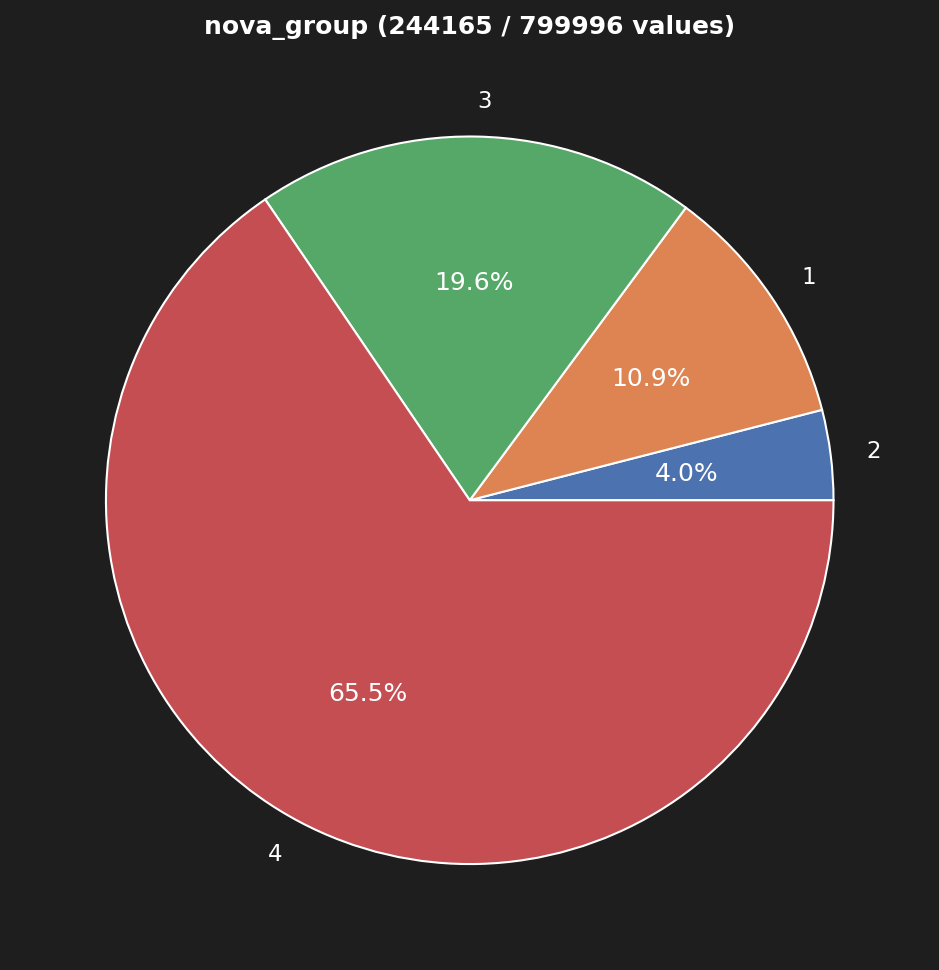

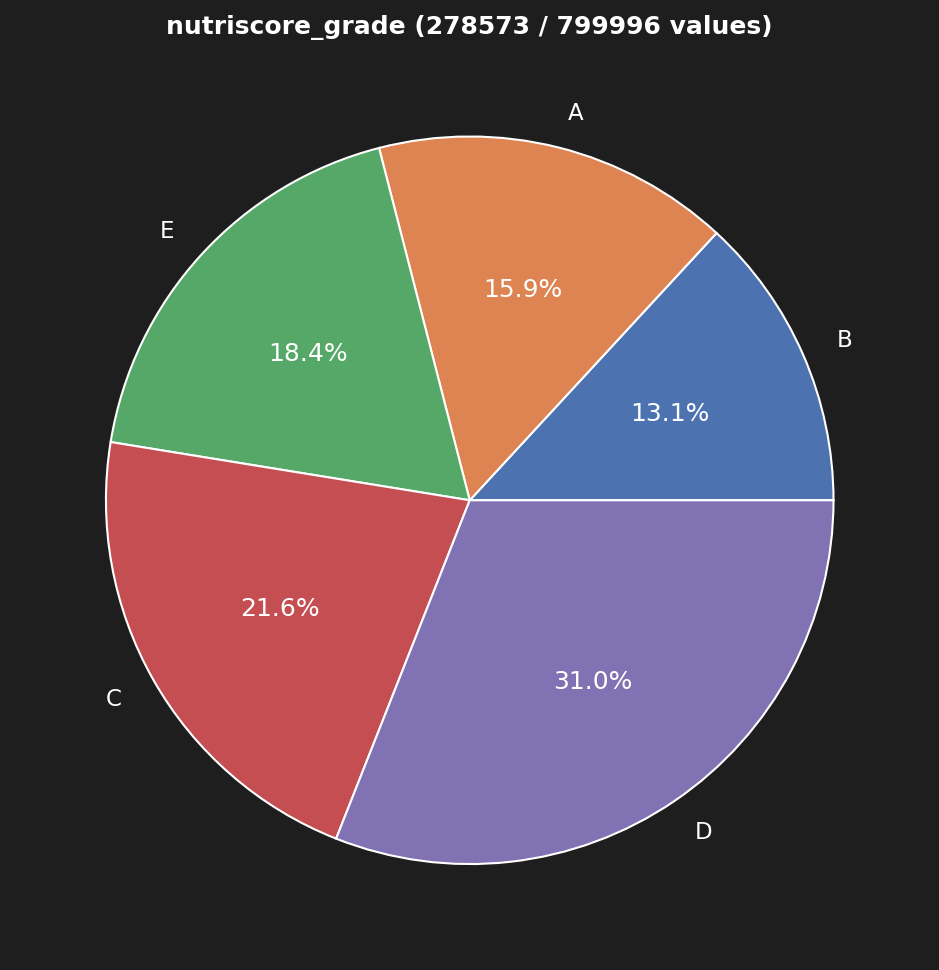

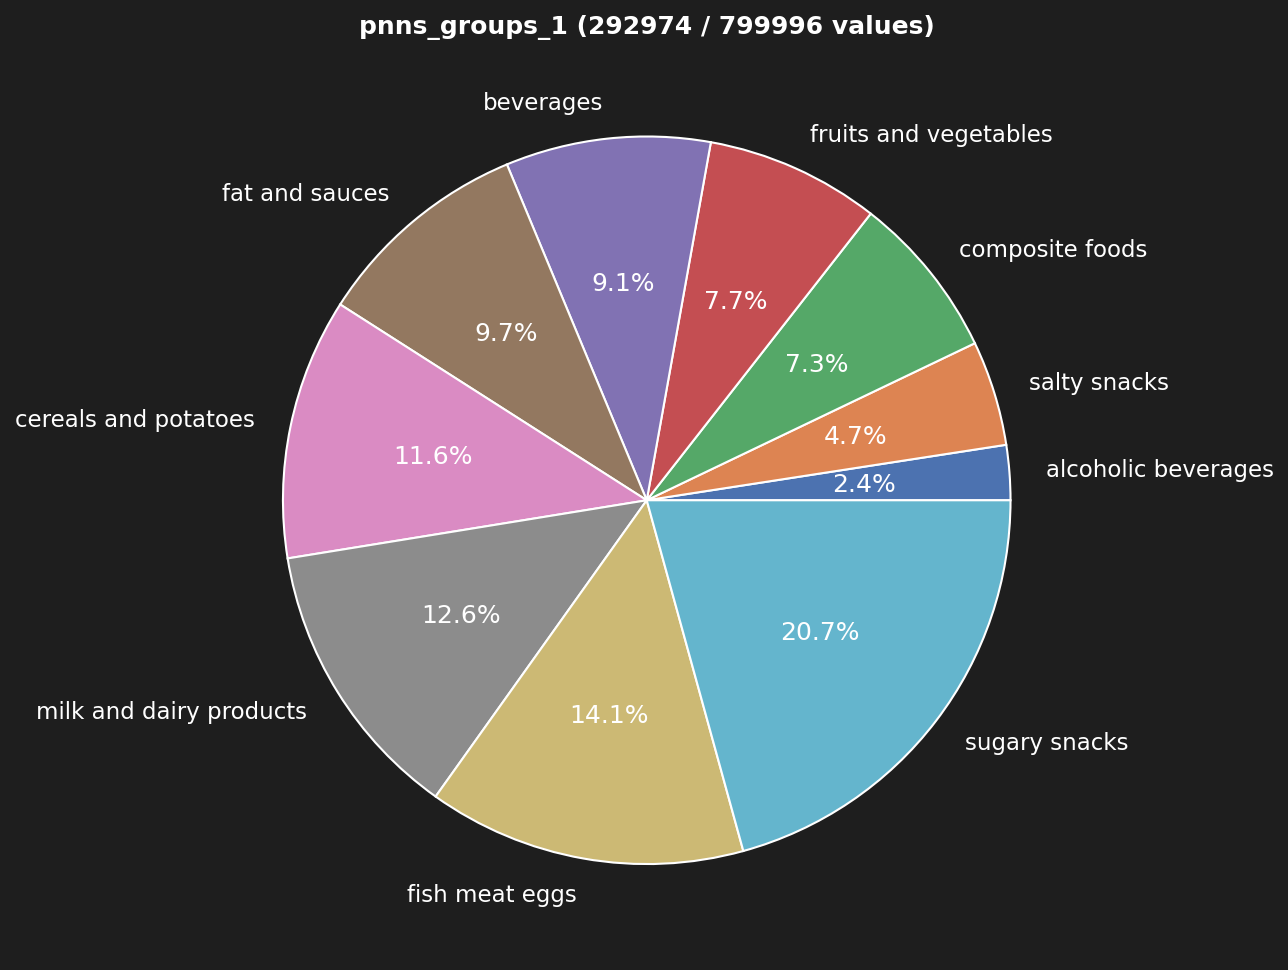

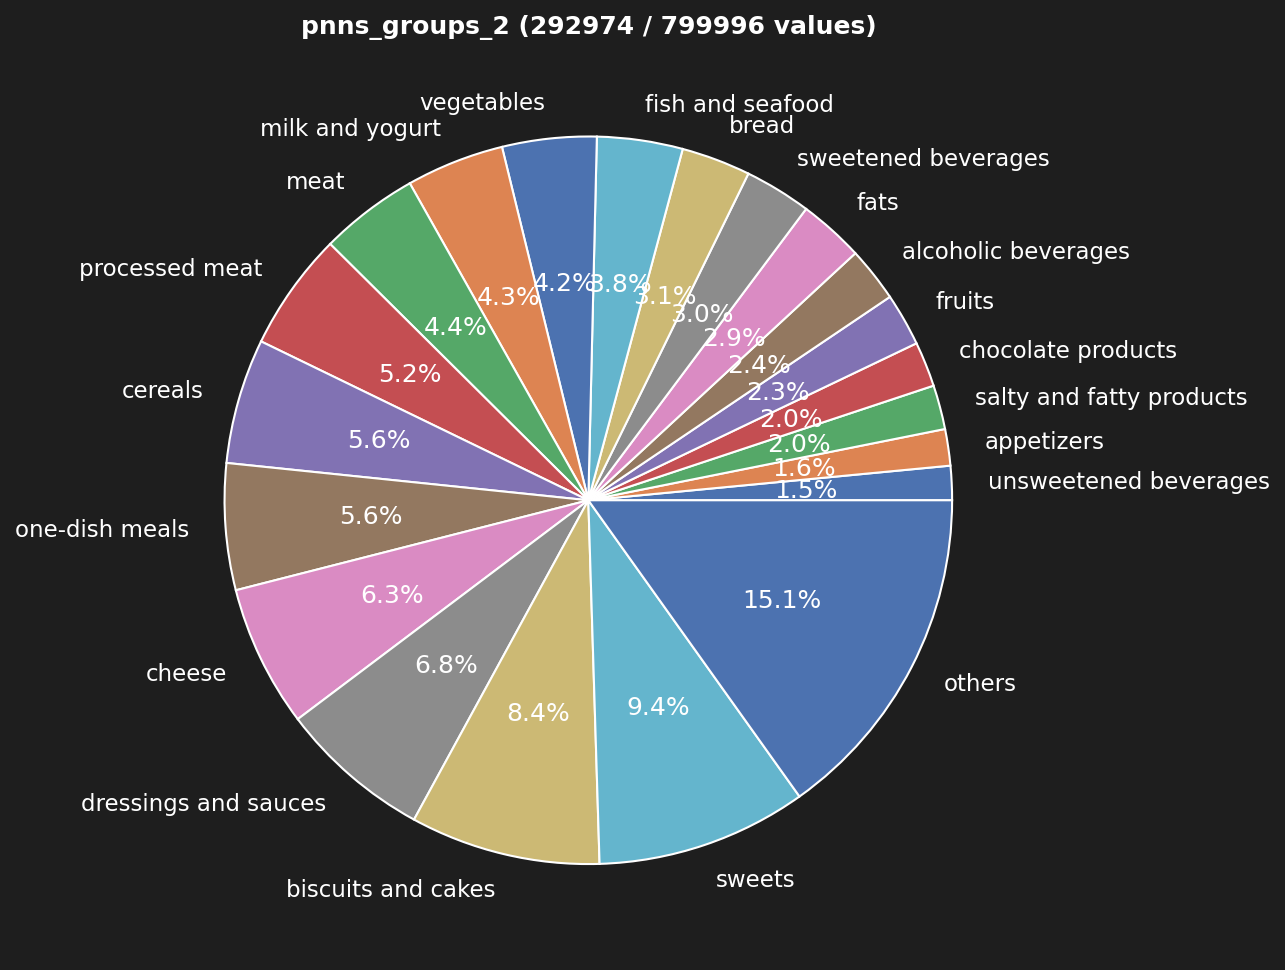

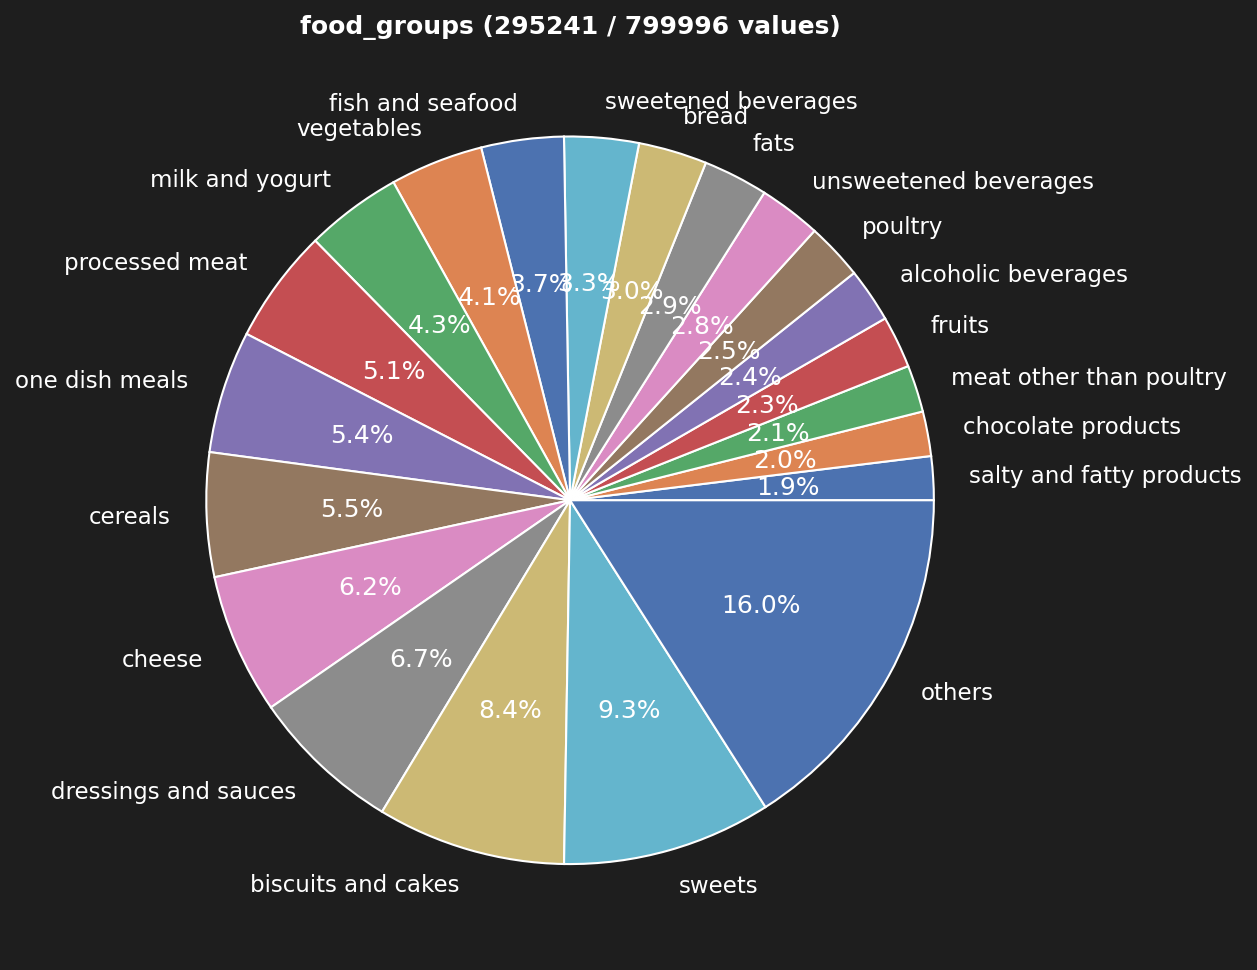

In [ ]:
dico_value_counts = { key: data[key].value_counts().sort_values() for key in string_catergories_to_value_count }
data_value_counts = pd.DataFrame( {key:[len(dico_value_counts[key])] for key in string_catergories_to_value_count} )
display(data_value_counts)
# data_value_counts.plot( kind='bar' )

# print('min counts', data_value_counts.iloc[0,:].min() )

n_lim_categories = 20
for key in string_catergories_to_value_count:
    sr_plot = dico_value_counts[key]
    n_sum = sr_plot.sum()

    if dico_value_counts[key].size > n_lim_categories:
        sr_plot = sr_plot.sort_values( ascending=False )
        sr_plot = pd.concat( [sr_plot[:n_lim_categories], 
                                pd.Series( [sr_plot[n_lim_categories:].sum()] , index=['others'] ),
                             ] )
        

    fig, ax = plt.subplots( figsize=(20*cm,20*cm))
    # pd.Series( sr_plot.sort_index( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    pd.Series( sr_plot.sort_values( ascending=True ) ).plot( kind='pie' , ax=ax, autopct='%.1f%%' )
    ax.set_title( '{:} ({:} / {:} values)'.format( key, n_sum, n), weight='bold')
    ax.set_ylabel('')

    # fig, ax = plt.subplots( figsize=(20*cm, 10*cm*(data_value_counts[key][0]/10)) )
    # pd.Series( dico_value_counts[key] ).plot( kind='barh' , ax=ax )
    # ax.set_title(key)

if False: # barplot
    cat_pos = np.arange( len(string_catergories_to_value_count) )
    print(cat_pos)
    fig, ax = plt.subplots( figsize=(20*cm,10*cm))
    if True: # horizontal
        ax.bar( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_xticks(cat_pos, labels=string_catergories_to_value_count)
    else:
        ax.barh( cat_pos, data_value_counts.iloc[0,:] , align='center')
        ax.set_yticks(cat_pos, labels=string_catergories_to_value_count)
        ax.invert_yaxis()  # labels read top-to-bottom

    fig.tight_layout()
    del cat_pos


## Comparaison pnns_groups_1/_2 et food_groups: tableaux de contingences
L'objectif est de vérifier si il est possible et utile de remplir la variable 'pnns_groups_1' à partir de 'pnns_groups_2' ou 'food_groups'

1. Copie des données pour pnns_groups et food_groups
1. msno heatmap $\rightarrow$ vérification de la corrélation entre les NaN des différentes variables
1. Drop des lignes avec au moin un NaN
1. Calcul et affichage d'une image type tableau de contingence

nan in data_chi:
pnns_groups_1    505679
pnns_groups_2    507982
food_groups      505717
dtype: int64

nan in data_chi:
pnns_groups_1    0
pnns_groups_2    0
food_groups      0
dtype: int64


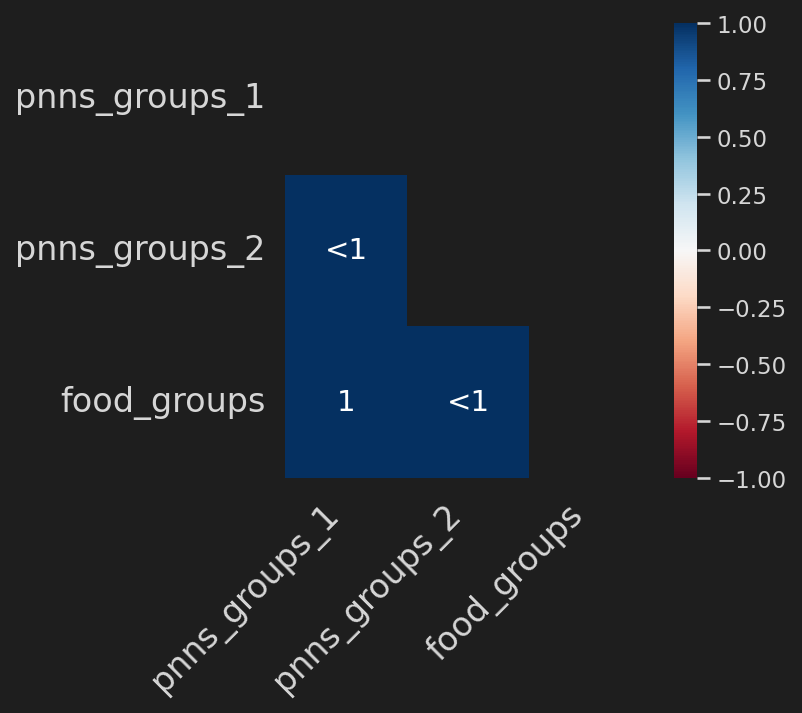

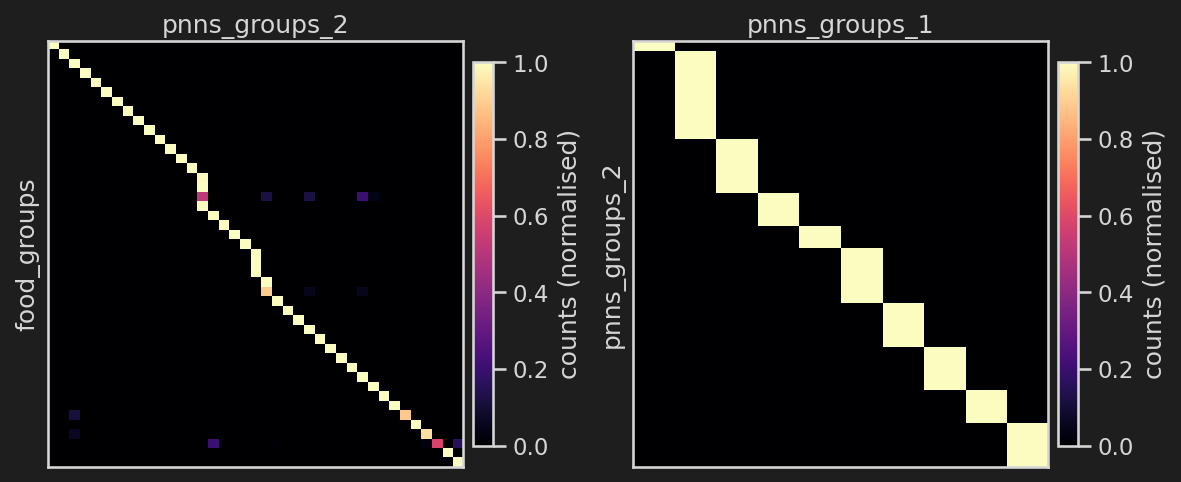

In [ ]:
data_chi = data[['pnns_groups_1', 'pnns_groups_2', 'food_groups']].copy()

print('nan in data_chi:')
print( data_chi.isnull().sum() )


fig, ax = plt.subplots( figsize=(10*cm,10*cm))
msno.heatmap( data_chi , ax=ax )

data_chi_isnull = data_chi.isnull()

# drop all rows with at least one NaN
data_chi.drop( data_chi.index[ data_chi_isnull.sum(1) > 0 ] , inplace=True )

# check drop
print('\nnan in data_chi:')
print( data_chi.isnull().sum() )

type_plot = ['xi', 'count'][1]

X2, Y2 = 'pnns_groups_2', 'pnns_groups_1'
X1, Y1 = 'food_groups', 'pnns_groups_2'

maps = [ None, None ]
fig, axs = plt.subplots( 1,2, figsize= (20*cm, 8*cm) )
for i, (X,Y) in enumerate( [ (X1,Y1), (X2,Y2) ] ):
    xi_ij, contingences = tools.chi2( data_chi, X, Y )

    image = contingences.values
    image = image[:-1,:-1] / image[:-1,-1:]
    argmax_col = image.argmax(1)
    maps[i] = pd.Series( { key_in:contingences.keys()[imax_col] for key_in, imax_col in zip(contingences[:-1].index, argmax_col)} )
    argsort_rows = argmax_col.argsort()
    # display( contingences.iloc[argsort_rows,:] )
    if type_plot == 'xi':
        image = xi_ij.values[:-1,:-1]
        label = r'$\xi_{ij} \, / \, \xi_{n}$'
    else:
        label = r'counts (normalised)'
    image = image[ argsort_rows ]

    # figsize = tools.image_size_from_height_and_shape( 12*cm, image.shape, xmargin=1*cm)
    # print( 'figsize', figsize)
    # fig, ax = plt.subplots( figsize=figsize )
    im = axs[i].imshow( image , cmap='magma', aspect='auto' )
    # axs[i].axis('off')
    # cb = plt.colorbar( im, ax=ax, orientation='horizontal', pad=0.01, label=r'$\xi_{ij} \, / \, \xi_{n}$')
    cb = plt.colorbar( im, ax=axs[i], pad=0.02, shrink=[0.9, 0.9][i], label=label)

axs[0].set_xlabel(Y1)
axs[0].set_ylabel(X1)

axs[1].set_xlabel(Y2)
axs[1].set_ylabel(X2)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 


# display( contingences )
# display( maps[0] )
# display( maps[1] )

# map food_group -> pnns_groups_1
# there are some 'pnns_groups_1' values in the 'food_groups' for which 'pnns_groups_1' is NaN
food_to_pnns_groups = pd.concat( (maps[1][maps[0]], 
                pd.Series( {key:key for key in dico_value_counts['pnns_groups_1'].keys()} ) ) )


fig.tight_layout( pad=0.4 )
plt.show()
del image, cb, im, axs, fig
del X1,Y1, X2,Y2, maps

## Gestion des NaN dans "pnns_groups_1"
1. détection des NaN
1. chercher NaN "pnns_groups_1" et non NaN "food_groups"
1. remplacer selon "food_groups" et "food_to_pnns_groups"

In [ ]:
print( "sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: {:}".format( 
    ( data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['pnns_groups_2'] ).sum() ) )

sum 'pnns_groups_1 NaN and 'pnns_groups_2' not Nan: 0


In [ ]:
b_map = data_chi_isnull['pnns_groups_1'] & ~data_chi_isnull['food_groups']
# display( food_to_pnns_groups)
data.loc[b_map, 'pnns_groups_1'] = food_to_pnns_groups[ data.loc[b_map,'food_groups'] ].values

***
# Gestion et analyse uni-varié des variables float
Mis à NaN:
- (nitruscore < -15) & (nutriscore > 40)
- values < 0 (sauf nutriscore)
- values > 100 (sauf energy)
- energy > 900 (kcal) <span style="color:orange"> compétence métier </span>
- sodium > salt
- saturated-fat > fat
- sugars > carbohydrates

Check $\sum$("proteins", "carbohydrates", "fat" ) > 100

<span style="color:red"> Quid de la somme > 100 ? quelle limite ? </span>

In [ ]:
# A VOIR POUR SPEED UP ?
if False:
    _, bp = pd.DataFrame.boxplot(df, return_type='both')

    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    boxes = [box.get_ydata() for box in bp["boxes"]]
    medians = [median.get_ydata() for median in bp["medians"]]
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

product_name  proteins_100g  carbohydrates_100g  \
369                            Sucre roux           0.00          100.000000   
1072                      sweet soy sauce           2.60           99.800000   
1103          Gaufres sucrées au chocolat          23.00           53.299999   
1362            Pisto con salmon y quinoa          30.10           45.480000   
1366    Fisherman's Friend pomme cannelle           0.00           98.800000   
...                                   ...            ...                 ...   
797669            Lindt HELLO XMAS Cherry          46.70           54.000000   
797687    Zucchero Int. bio Cocco GR230 E           1.80           97.000000   
797873         Les croquants chocolat bio           7.30           67.000000   
798816                    Lenguas Ketydul           5.70           67.100000   
799834                         Mixed nuts          21.43           17.860000   

         fat_100g  sum_100g  
369      0.100000     100.1  
1072     0.000000     102.4  
1103    25.700001     102.0  
1362    29.100000     104.7  
1366     1.300000     100.1  
...           ...       ...  
797669  35.000000     135.7  
797687   1.500000     100.3  
797873  27.000000     101.3  
798816  27.500000     100.3  
799834  64.290000     103.6  

[2239 rows x 5 columns]

nutriscore_score  nutrition-score-fr_100g
count     277591.000000            277594.000000
mean           9.110976                 9.111072
std            8.840131                 8.840151
min          -15.000000               -15.000000
25%            1.000000                 1.000000
50%           10.000000                10.000000
75%           16.000000                16.000000
max           40.000000                40.000000
IQ            15.000000                15.000000

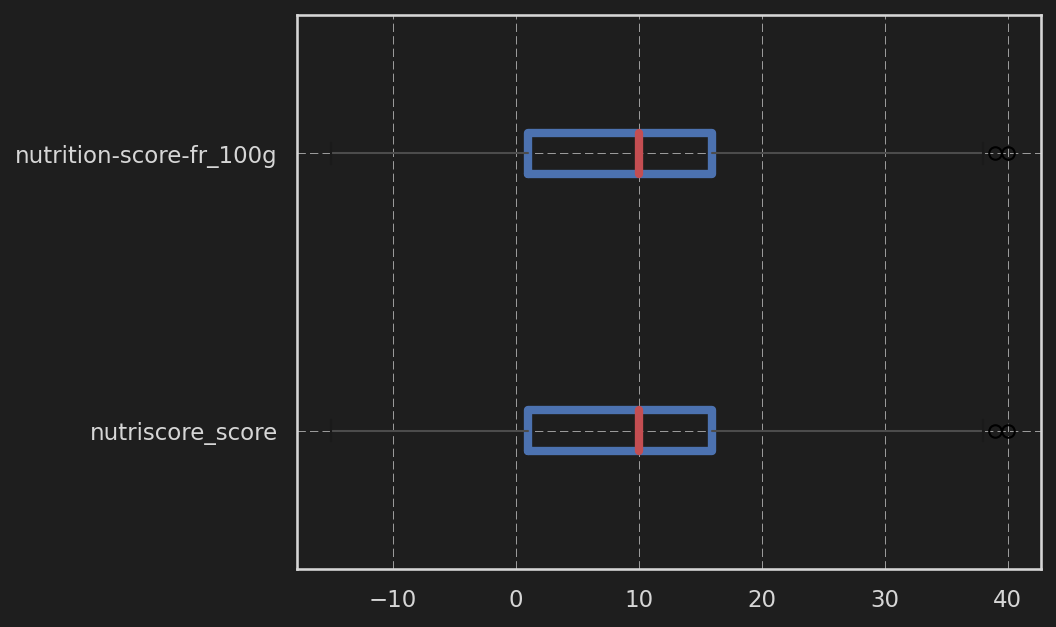

energy-kcal_100g
count     613009.000000
mean         270.542555
std          191.147619
min            0.000000
25%          100.000000
50%          259.000000
75%          400.000000
max          900.000000
IQ           300.000000

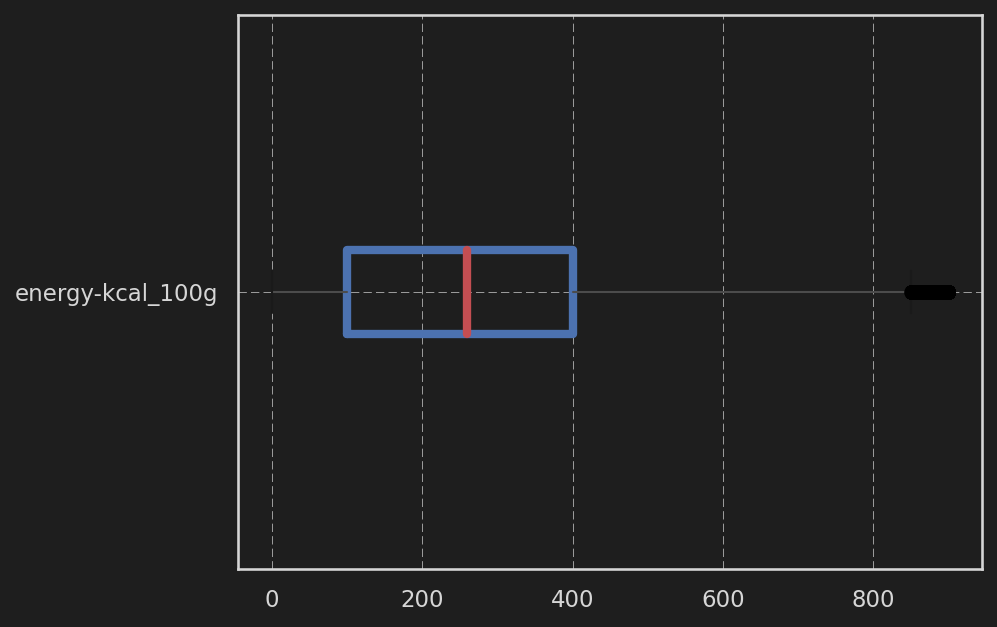

fat_100g  saturated-fat_100g  carbohydrates_100g    sugars_100g  \
count  627690.000000       610569.000000       627529.000000  620299.000000   
mean       13.669906            5.056372           28.078364      13.005056   
std        17.592071            7.756347           27.914560      19.350697   
min         0.000000            0.000000            0.000000       0.000000   
25%         0.800000            0.100000            3.530000       0.600000   
50%         7.000000            1.800000           15.384615       3.570000   
75%        21.210000            7.058824           53.000000      17.400000   
max       100.000000          100.000000          100.000000     100.000000   
IQ         20.410000            6.958824           49.470000      16.800000   

       proteins_100g      salt_100g    sodium_100g  \
count  628226.000000  582539.000000  582533.000000   
mean        8.710977       1.359247       0.543701   
std        10.013554       4.652734       1.861109   
min         0.000000       0.000000       0.000000   
25%         1.330000       0.082500       0.033000   
50%         6.000000       0.582500       0.233000   
75%        12.500000       1.400000       0.560000   
max       100.000000     100.000000      40.000000   
IQ         11.170000       1.317500       0.527000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g  
count                                      272274.000000      
mean                                            8.237656      
std                                            21.662131      
min                                             0.000000      
25%                                             0.000000      
50%                                             0.000000      
75%                                             0.400000      
max                                           100.000000      
IQ                                              0.400000

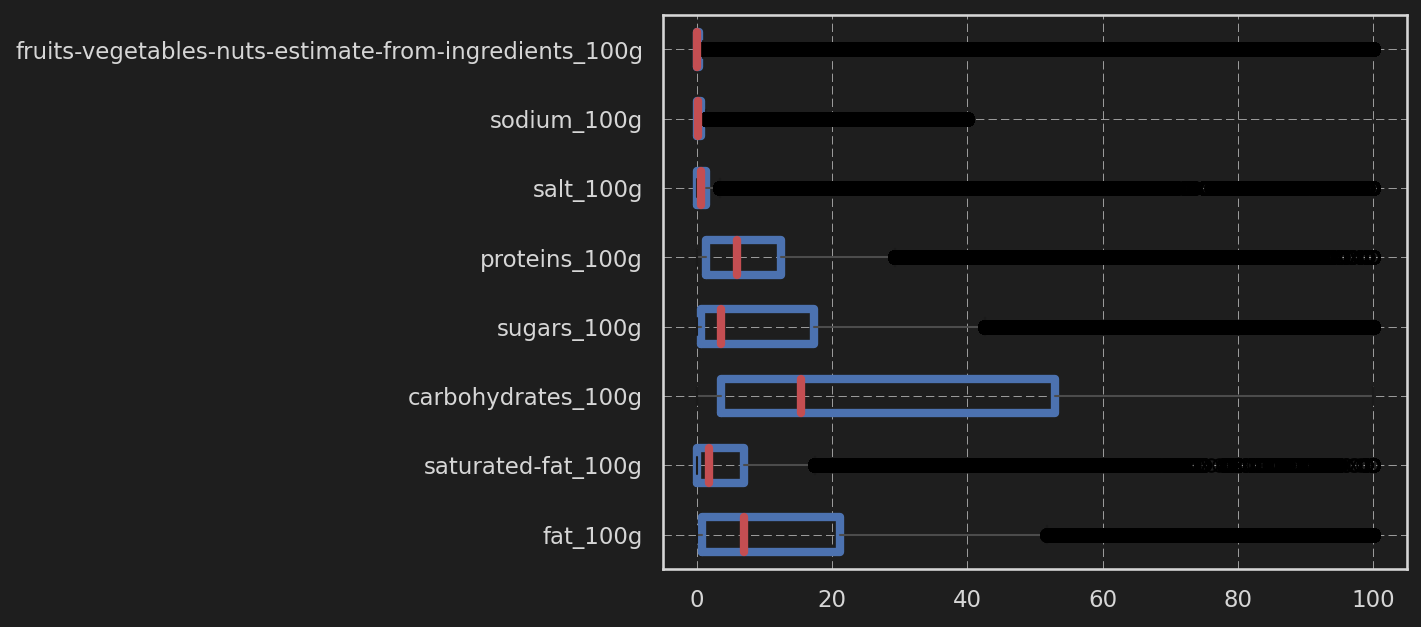

In [ ]:
keys = pd.Series( categories_float )
# keys = keys.loc[ keys!='energy_100g' ]
# keys = keys.loc[ keys.str.contains('_100g|score') ]

keys = keys.loc[ keys.str.contains('100g|score') & (keys!='energy_100g') ]
keys_float = keys.copy()
# print(categories_float)
# print('\n', keys.values)


# NUTRI SCORE
key = 'nutriscore_score'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan
key = 'nutrition-score-fr_100g'
data.loc[ (data[key] < -15.) | (data[key] > 40.) ] = np.nan


# ENERGY
key = 'energy-kcal_100g'
data.loc[ (data[key] < 0.) | (data[key] > 900.) ] = np.nan

# (Values < 0.) | (Values > 100.)
for key in keys[ ~keys.str.contains('score|energy') ]:
    data.loc[ (data[key] < 0.) | (data[key] > 100.) ] = np.nan
    
# SODIUM
key = 'sodium_100g'
data.loc[ data[key] > data['salt_100g'], key ] = np.nan

# SUGARS
key = 'sugars_100g'
data.loc[ data[key] > data['carbohydrates_100g'], key ] = np.nan

# SATURATED_FAT
key = 'saturated-fat_100g'
data.loc[ data[key] > data['fat_100g'], key ] = np.nan

# TOTALtext
key = 'sum_100g'
data[key] = data[ ['proteins_100g', 'carbohydrates_100g', 'fat_100g'] ].fillna(0.).sum(axis=1).round(1)


display( data.loc[ np.round( data['sum_100g'], 1)>100. , ['product_name','proteins_100g', 'carbohydrates_100g', 'fat_100g', 'sum_100g']] )

del key


df_describe = data[ keys ].describe()



IQs = df_describe.loc['75%', :] - df_describe.loc['25%', :]
# IQs.rename( index={0:'IQ'}, inplace=True )

# # display(IQs)
df_describe = pd.concat( (df_describe, IQs.to_frame().T) , ignore_index=False )
df_describe.rename( index={0:'IQ'}, inplace=True )

boxprops = dict(linestyle='-', linewidth=4, color='b')
medianprops = dict(linestyle='-', linewidth=4, color='r')


for keys_tmp in [ keys.astype(str).values[keys.str.contains('score')] , ['energy-kcal_100g'], keys[~keys.str.contains('score|energy')].values ]:
    display( df_describe[keys_tmp] )
    data[keys_tmp].boxplot( showfliers=True, vert=False, boxprops=boxprops, medianprops=medianprops )
    # ax.bxp( df_describe[keys_tmp], boxprops=boxprops, medianprops=medianprops )
    plt.show()
del keys_tmp


# key = 'energy_100g'
# data.loc[ data[key] > df_describe[key]['75%'] + 1.5*df_describe[key]['IQ'] , key ] = np.nan

# df_describe = data[categories_float].describe()
# df_describe.boxplot( showfliers=False, vert=False )
# display( df_describe )


## Nouveau DataFrame et count NaN
<a id="link_prepModel"></a>
Préparation pour modélistation

In [ ]:
keys_categ_score = ['pnns_groups_1', 'nova_group', 'nutriscore_grade', 'nutriscore_score']
key_categ = keys_categ_score[2]
key_classification = keys_categ_score[2]

# copie des données catégorie, classification et float
data_base = data[keys_categ_score].copy()
# if not key_classification in key_categ:
#     data_base[key_classification] = data[key_classification].copy()
data_base[keys_float] = data[keys_float].copy()
isna_base = data_base.isna()
sum_isna_base = isna_base.sum() # sum sur les colonnes

display( 'Number of not NaN (over {:} rows)'.format( len(data)) )
display( len(data)-sum_isna_base )

key_output = 'energy-kcal_100g'
keys_stats = keys_float[ ~keys_float.str.contains( 'score|fruits') ]
keys_input = keys_stats[ keys_stats != key_output ]

b_inputs = ~isna_base[key_categ] & (~isna_base[keys_input]).all( 1 ) # logical and over all columns
b_outputs = (~isna_base[[key_output, key_classification]]).all( 1 )

data_stats = data_base.loc[ b_inputs & b_outputs , :]

print('Number of available data:')
print('inputs          : {:}'.format( b_inputs.sum() ) )
print('inputs & outputs: {:}'.format( ( b_inputs & b_outputs ).sum() ))


'Number of not NaN (over 799996 rows)'

pnns_groups_1                                            294317
nova_group                                               243336
nutriscore_grade                                         277591
nutriscore_score                                         277591
energy-kcal_100g                                         613009
fat_100g                                                 627690
saturated-fat_100g                                       610569
carbohydrates_100g                                       627529
sugars_100g                                              620299
proteins_100g                                            628226
salt_100g                                                582539
sodium_100g                                              582533
fruits-vegetables-nuts-estimate-from-ingredients_100g    272274
nutrition-score-fr_100g                                  277594
dtype: int64

Number of available data:
inputs          : 276185
inputs & outputs: 262646


## Affichage des histogrammes pour les différentes variabes float
- 2 groupes sont visibles pour les carbohydrates
- les autres sont globalement des distribution avec un `skweness empirique > 0`
- 1 second groupe (très petit) est parfois visible

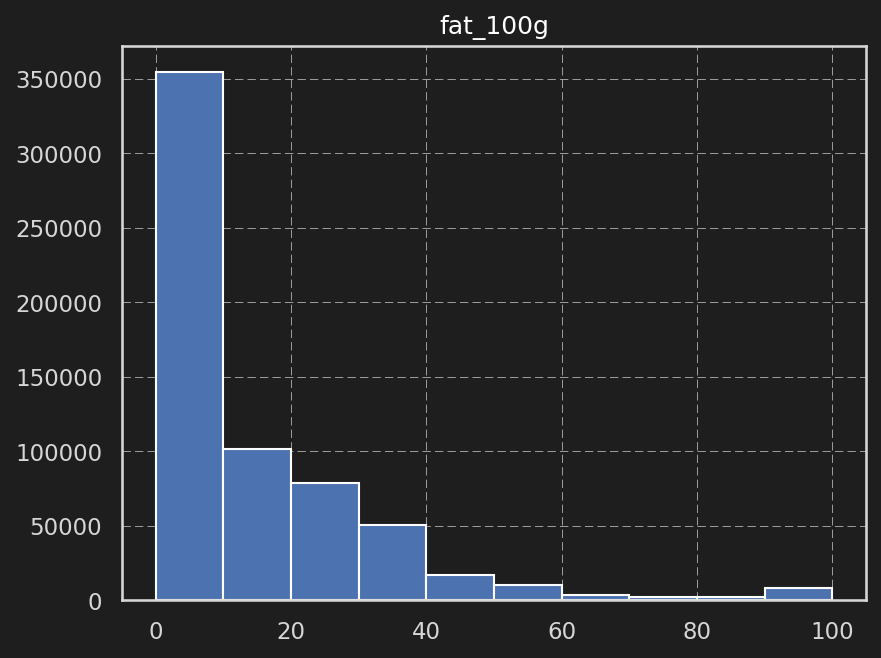

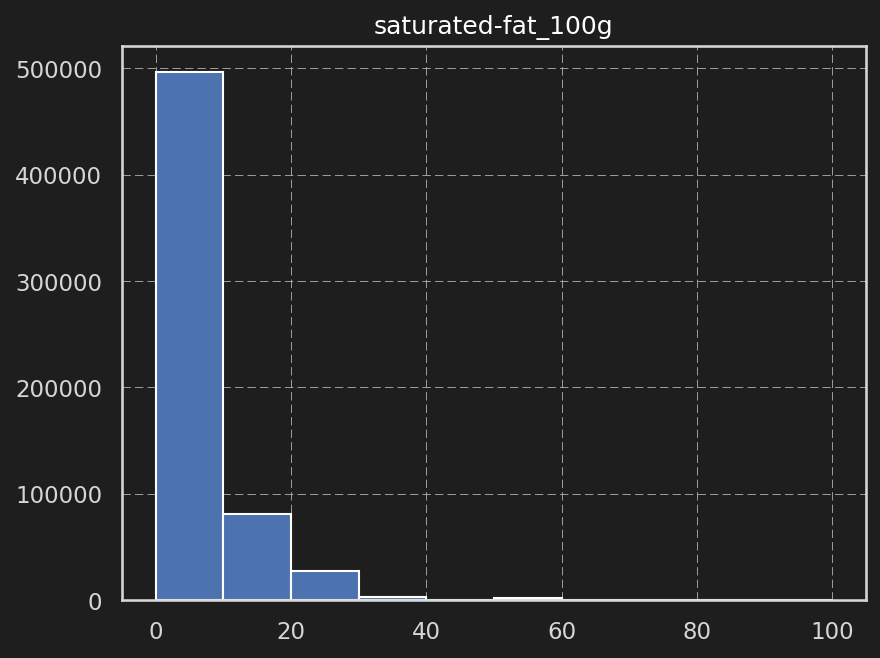

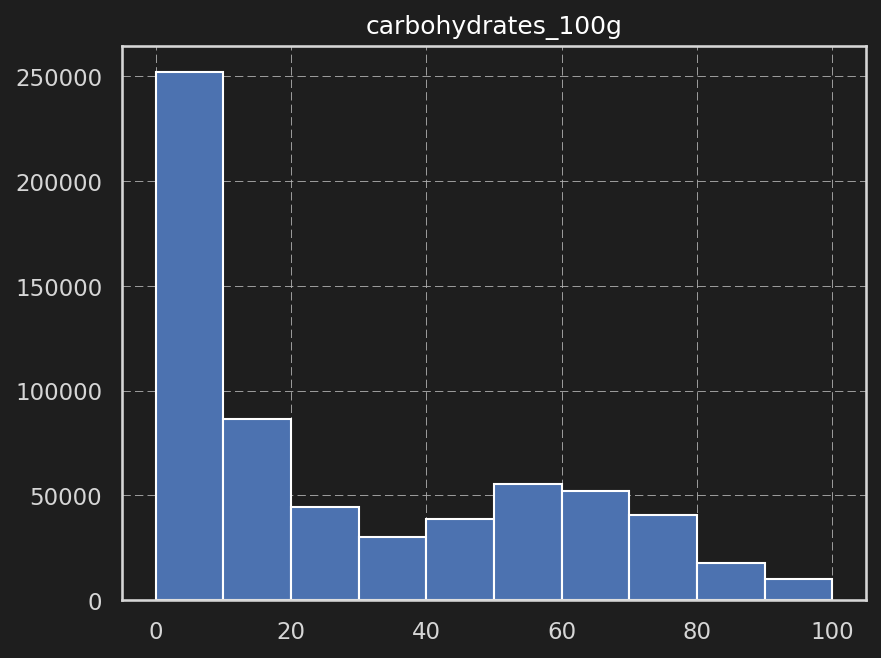

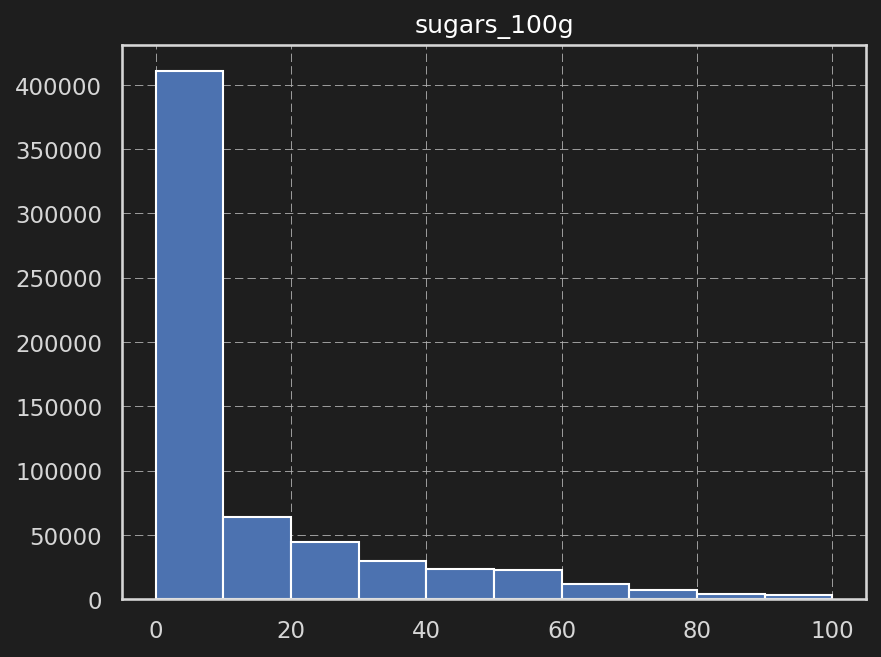

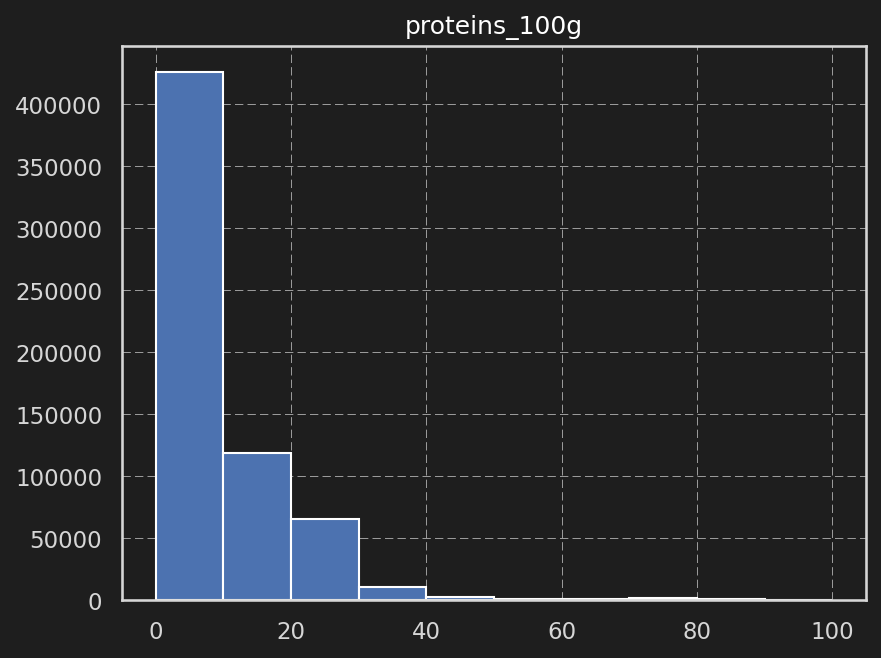

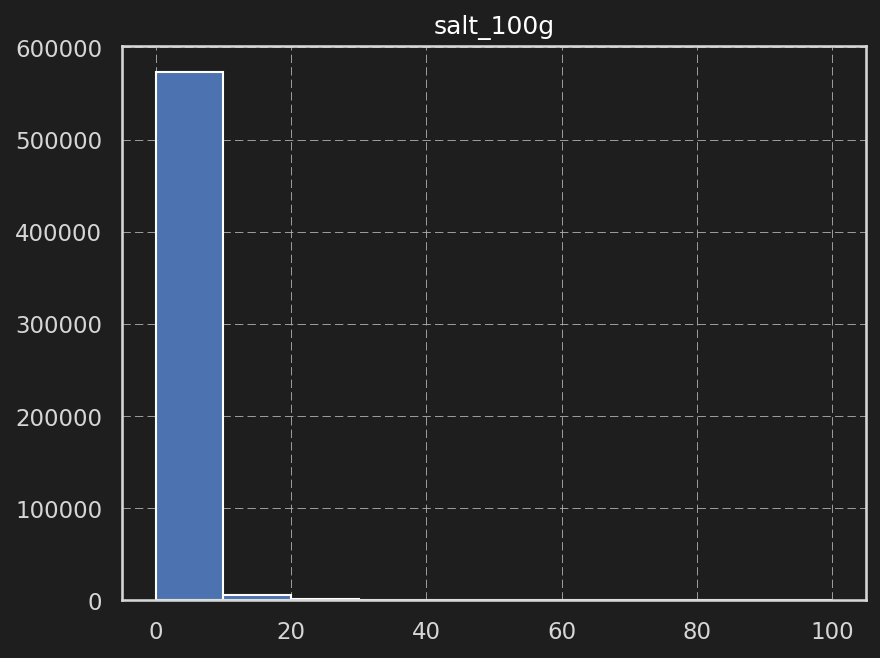

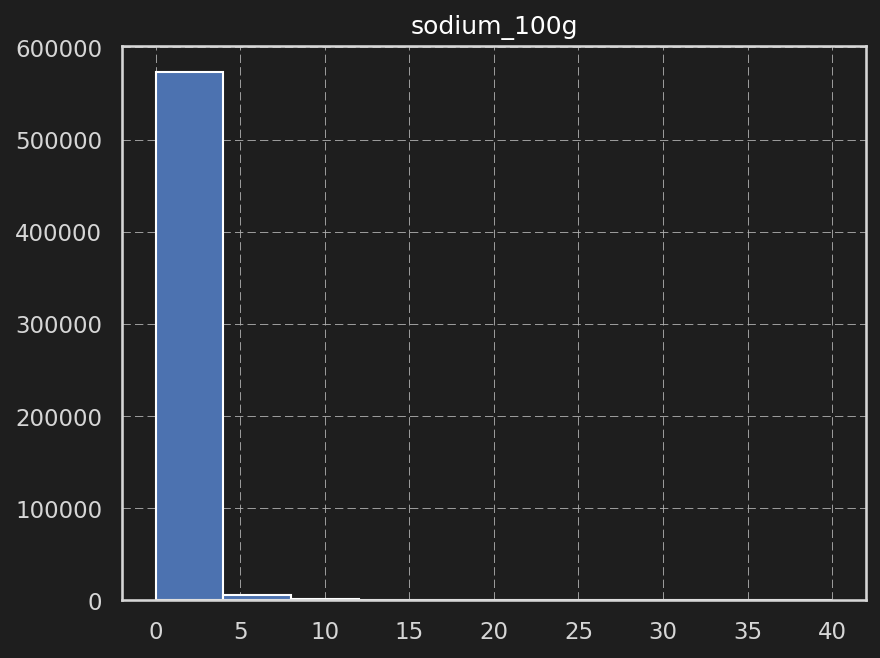

In [ ]:
for key in keys_input:
    fig, ax = plt.subplots()
    data_base[ key ].hist( ax=ax )
    ax.set_title(key)

## Analyse bivariée
Tracés:
- energy_kcal vs fat
- energy_kcal vs carbohydrates
- energy_kcal vs proteins
La couleur code la catégorie choisie ( variable key_categ définie [deux sections avant](#link_prepModel) : pnns_group_1 / food_group / nutriscore_grade)

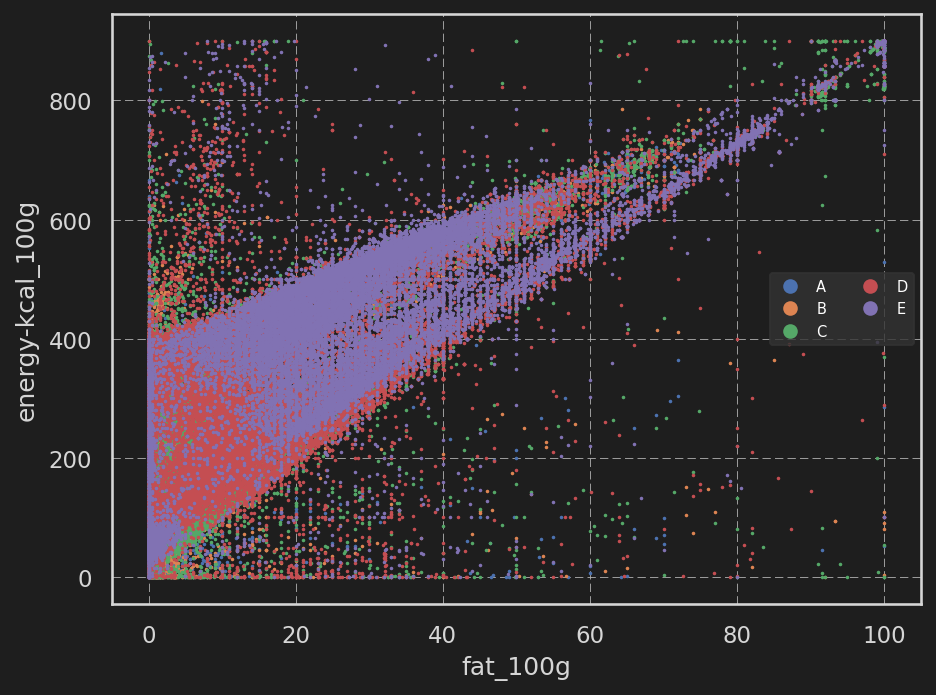

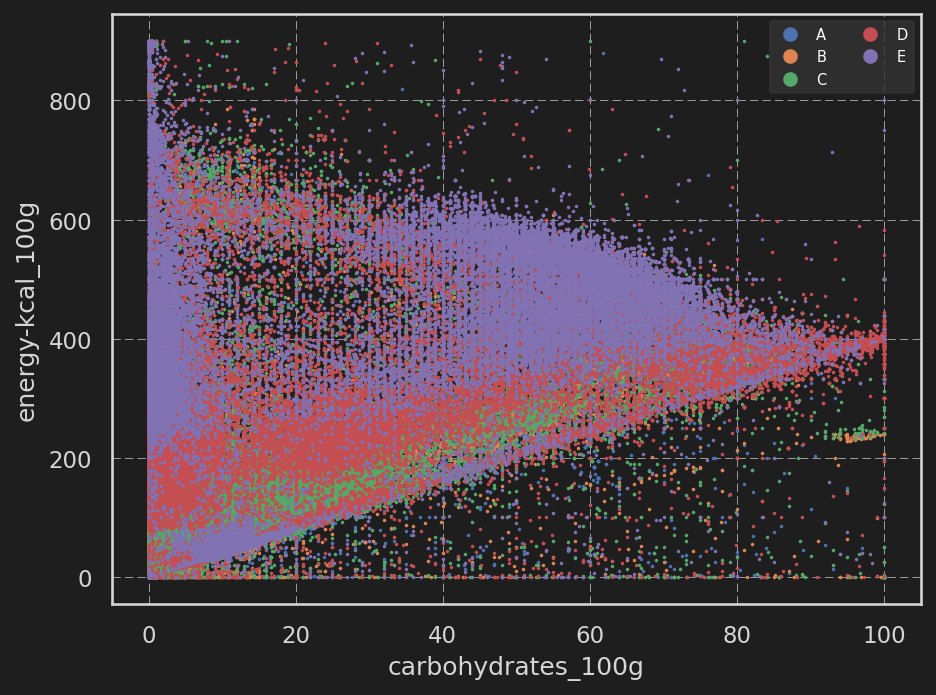

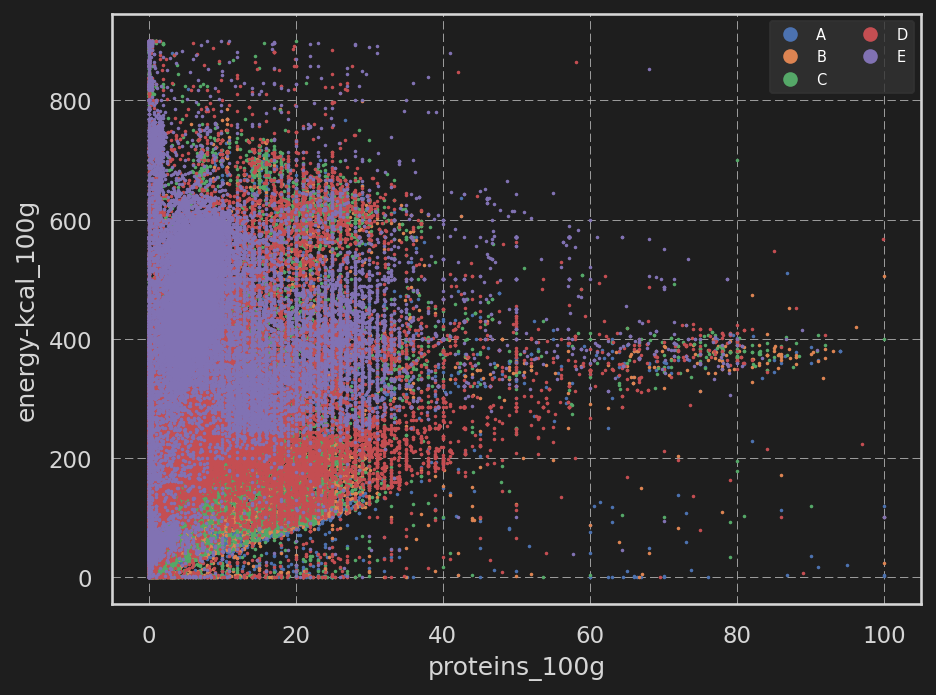

In [ ]:
groups = data_stats.groupby( key_categ )

for key in ['fat_100g', 'carbohydrates_100g', 'proteins_100g']:
    fig, ax = plt.subplots()
    ax.set_xlabel( key )
    ax.set_ylabel( key_output )
    for name, group in groups:
        ax.plot( group[key], group[key_output], 'o', markersize=0.7, label=name )
    lgnd = ax.legend( ncol=2, fontsize=7 )
    for handle in lgnd.legendHandles:
        handle.set_markersize(6.0) # change markersize in legend
    fig.tight_layout( )
    plt.show()

# Modelisation
<!-- Les entrées <span style="color:orange"> "salt" </span> et <span style="color:orange"> "sodium" </span> sont <span style="color:orange"> retirées </span>, car il n'y a <span style="color:orange"> pas de corrélation visible </span>sur les graphiques -->

## Remplir quantitatives avec valeur moyenne
<span style="color:red"> Il y a bien plus de NaN dans les variables groupes que dans les variables quantitées (pour celles gardée en tout cas) <br> $\rightarrow$ quid ? </span>

In [ ]:
# keys_input_model = keys_stats[ ~keys_stats.str.contains('salt|sodium')]
keys_input_model = keys_stats
display( keys_input_model.tolist() )

['energy-kcal_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

## KNN: classification / Regression

'k-nn to fit "nutriscore_grade"'

k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10


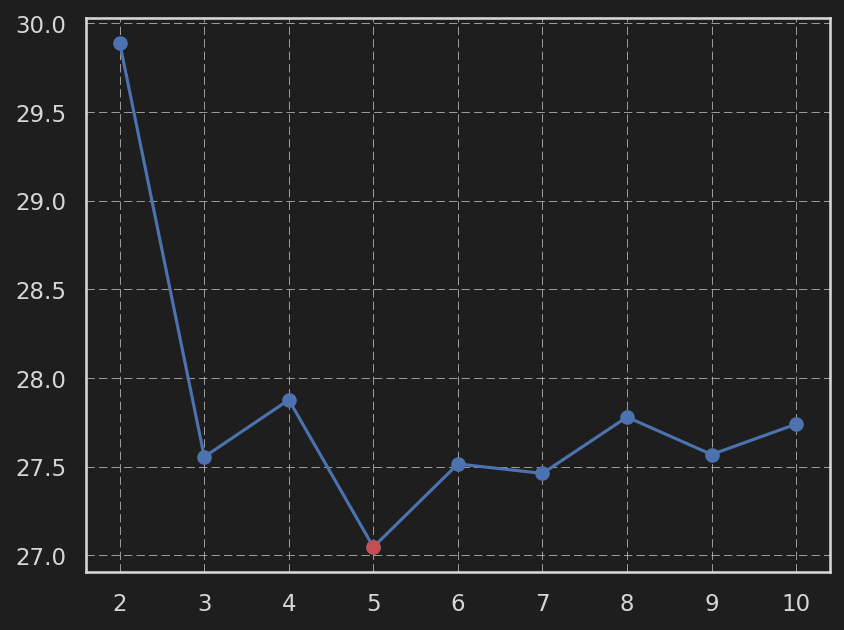

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors



# display( group[keys_stats] )
display( "k-nn to fit \"{:}\"".format( key_classification) )

xtrain, xtest, ytrain, ytest = train_test_split( data_stats[keys_input_model].values , data_stats[key_classification].values, train_size=0.8)


kmin, kmax = 2, 10
fig, ax = plt.subplots()
errors, dico_knn = [], {}
for k in range(kmin, kmax+1):
    print('k:', k)
    if ytrain.dtype in ['object', 'category']:
        knn = neighbors.KNeighborsClassifier(k)
    else:
        knn = neighbors.KNeighborsRegressor(k)
    dico_knn[k] = knn
    # knn.fit(xtrain, ytrain)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
imin = np.argmin(errors)
ax.plot( range(kmin, kmax+1), errors, 'o-b')
ax.plot( [kmin+imin], [errors[imin]], 'or' )
plt.show()


## Iterative imputer

Categories ['A' 'B' 'C' 'D' 'E']
categories_classification ['A' 'B' 'C' 'D' 'E' 'NaN']


'score:'

38.418046830382636

'prediction:'

array(['B', 'E', 'C', 'D', 'B', 'C', 'C', 'B', 'B', 'C'], dtype='<U3')

'true:'

['B', 'E', 'C', 'D', 'A', 'A', 'A', 'B', 'A', 'C']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']

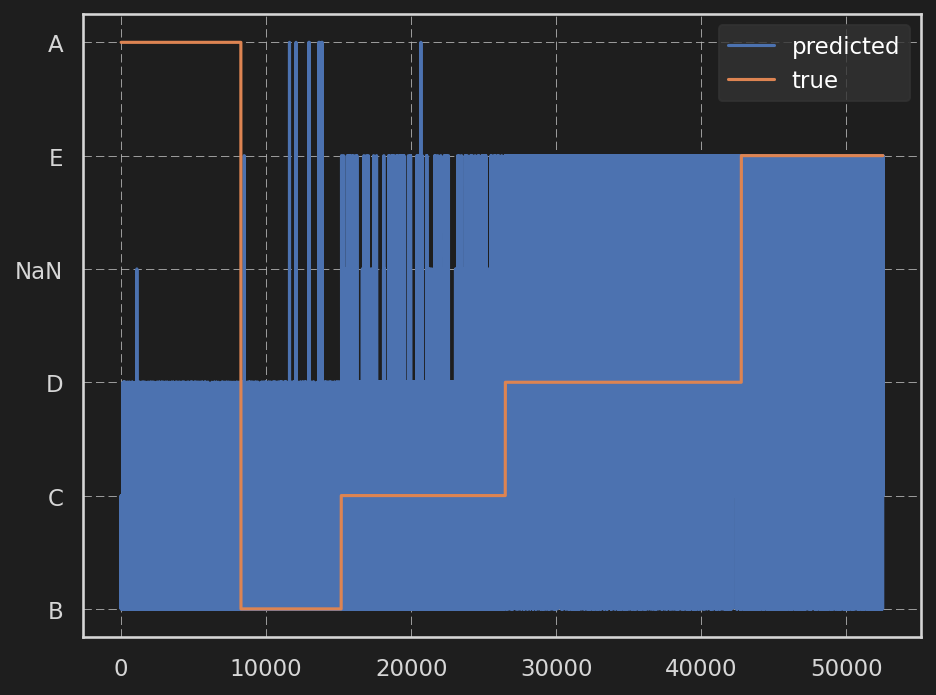

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=20, random_state=0)

# X_fit = np.hstack( (xtrain, ytrain.reshape(-1,1)) )
X_fit = pd.DataFrame( { key:xtrain[:,i] for i, key in enumerate(keys_stats) } )
ytrain_cat = pd.Series( ytrain, dtype='category' )
X_fit[key_classification] = ytrain_cat.cat.rename_categories( {cat:i for i,cat in enumerate( ytrain_cat.cat.categories )} )

# X_fit = [[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]]
# print('X_fit:\n', X_fit)
imp.fit( X_fit.values )
IterativeImputer(random_state=0)
# X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
# print('completed X_test:\n', np.round(imp.transform(X_test)))

# X_test = np.hstack( (xtest, np.full(shape=xtest[:,:1].shape, fill_value=np.nan) ) )
X_test = pd.DataFrame( { key:xtest[:,i] for i, key in enumerate(keys_stats) } )
X_test[key_classification] = np.nan
Y_pred = imp.transform( X_test.values )

print
if "float" in str(ytest.dtype):
    score = 100*(r2_score(y_true=ytest, y_pred=Y_pred[:,-1] ) )
else:
    print( 'Categories', data[key_classification].cat.categories.values )
    prediction = (Y_pred[:,-1] +0.5 ).astype('int')
    categories_classification = np.array( data[key_classification].cat.categories.tolist() + ['NaN'] )
    print( 'categories_classification', categories_classification )
    prediction[ (prediction<0) | (prediction > len(categories_classification)-1) ] = 5
    prediction = categories_classification[ prediction ]
    score = (ytest == prediction).sum() * 100 / ytest.size
display( 'score:', score )

display( 'prediction:', prediction[:10])
display( 'true:', ytest[:10])

argsort = ytest.argsort()
fig, ax = plt.subplots()
ax.plot( prediction[argsort], label='predicted' )
ax.plot( ytest[argsort], label='true' )
ax.legend()
fig.tight_layout()

## Test SVD

In [ ]:
from sklearn.metrics import r2_score

array = np.empty( (xtrain.shape[0], xtrain.shape[1]+1), dtype='float64' )
array[:,:-1] = xtrain[:,:]
display('IF CATEGORY -> TO NUMERIC')
array[:,-1] = ytrain[:]

U,S,VT = np.linalg.svd( array.T @ array )

fig, axs = plt.subplots( ncols=2 )
for i in range(VT.shape[0]):
    axs[0].plot( VT[i] )
    axs[1].plot( U[i] )

np.set_printoptions( formatter={'float':'{:.3E}'.format})

phi = U[:,:-1]
phi2 = U[:,-1:]

estimator = np.linalg.inv( phi @ phi.T ) @ phi

display( phi @ phi.T )

coefs = estimator @ xtest.T

y_pred = (coefs.T @ phi2 ).ravel()


display( ytest[:10] )
display( y_pred[:10] )

display( r2_score( y_true=ytest, y_pred=y_pred ) )


argsort = ytest.argsort()
fig, ax = plt.subplots()
ax.plot( y_pred[argsort], label='predicted' )
ax.plot( ytest[argsort], label='true' )
ax.legend()
fig.tight_layout()

del array

# <span style="color:orange"> FIN PARTIE UTILE </span>

## Labels
Several labels per product

In [ ]:
key = 'labels_en'

print('Example of labels:\n')
i = 0
for value in data[key]:
        if value is np.nan : continue
        print(value)
        i += 1
        if i == 10: break
dico_value_labels = tools.value_count_labels_in_string_series( data.loc[~data[key].isnull(),key] , ',' )
print(dico_value_labels)

## Visiualisation of NaN with missingno
as barplot 

In [ ]:
msno.bar( data )

## Heatmap without fully filled categories

In [ ]:
msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full)] ] )

## Heatmap without fully filled categories (qualitatives + nutriscore)

In [ ]:
ax = msno.heatmap( data[ [key for key in data.keys() if (not key in categories_full) and (not '_100g' in key) or 'score' in key] ] )

## A REGARDER

# END OF NOTEBOOK

In [ ]:
fig = ax.get_figure()
fig.tight_layout()
tools.savefig( fig, 'Figures/test' )